Created by Marina Dunn, Spring 2022

# Training Status

#### Training with year 10 data:

**Model 1b (complete):**

*Accuracy: 63% (Y10 train), 61% (Y10 test), 62% (Y10 validation), 62% (Y1 test)

*Precision (weighted): 67% (Y10 train), 65% (Y10 test), 65% (Y10 validation), 63% (Y1 test)

*Recall (weighted): 63% (Y10 train), 61% (Y10 test), 62% (Y10 validation), 62% (Y1 test)

*F1 (weighted): 64% (Y10 train), 61% (Y10 test), 62% (Y10 validation), 62% (Y1 test)

*higher loss: validation

**Model 3b (complete):**

*Accuracy: 57% (Y10 train), 55% (Y10 test), 57% (Y10 validation), 54% (Y1 test)

*Precision (weighted): 73% (Y10 train), 71% (Y10 test), 71% (Y10 validation), 56% (Y1 test)

*Recall (weighted): 57% (Y10 train), 55% (Y10 test), 57% (Y10 validation), 54% (Y1 test)

*F1 (weighted): 57% (Y10 train), 55% (Y10 test), 57% (Y10 validation), 54% (Y1 test)



**ResNet18 Model (complete):**

*Accuracy: 93% (Y1 train), 81% (Y1 test), 82% (Y1 validation), 58% (Y10 test)

*Precision (weighted): 93% (Y1 train), 82% (Y1 test), 83% (Y1 validation), 63% (Y10 test)

*Recall (weighted): 93% (Y1 train), 81% (Y1 test), 82% (Y1 validation), 58% (Y10 test)

*F1 (weighted): 93% (Y1 train), 81% (Y1 test), 82% (Y1 validation), 57% (Y10 test)


**ResNet18 with Dropout 0.5, no Initializers, with ZeroPadding (complete):**

*Accuracy: 59% (Y10 train), 55% (Y10 test), 57% (Y10 validation), 34% (Y1 test)

*Precision (weighted): 67% (Y10 train), 63% (Y10 test), 66% (Y10 validation), 47% (Y1 test)

*Recall (weighted): 59% (Y10 train), 55% (Y10 test), 57% (Y10 validation), 34% (Y1 test)

*F1 (weighted): 58% (Y10 train), 55% (Y10 test), 56% (Y10 validation), 20% (Y1 test)


## After Transfer Learning:

**ResNet18 with Dropout 0.5, no Initializers, with ZeroPadding (complete):**

*Accuracy: 50% (Y10 test), 51% (Y1 test)

*Precision (weighted): 54% (Y10 test),  53% (Y1 test)

*Recall (weighted): 50% (Y10 test),  51% (Y1 test)

*F1 (weighted):  43% (Y10 test), 52% (Y1 test)

# Load Data & Import Packages

In [2]:
# Import user-defined functions
from ML_training_functions import generate_class_weights, scale_pixels #,mean_std
#from ML_training_functions import plot_filters, plot_filters_scaled, labels_hist

import os
import datetime
import math
import random
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict

# arrays
import numpy as np
np.set_printoptions(edgeitems=25, linewidth=100000)
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_rows = 10000000

# ML
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
import tensorflow_probability as tfp
# data augmentation
# from tensorflow.keras.layers import RandomFlip, RandomZoom, RandomRotation, ReLU
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# training
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import (Callback, ModelCheckpoint, EarlyStopping, 
                                        ReduceLROnPlateau, LambdaCallback, LearningRateScheduler)
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, ZeroPadding2D, ReLU,
                                     AveragePooling2D, Add, Conv2D, MaxPool2D, BatchNormalization, 
                                     Input, Flatten, Dense, Dropout)
from tensorflow.keras.initializers import VarianceScaling, RandomUniform, HeNormal
# tensorflow add-ons
#import tensorflow_addons as tfa
#from tensorflow_addons.optimizers import CyclicalLearningRate, AdamW, ExponentialCyclicalLearningRate
# Load the TensorBoard notebook extension
%load_ext tensorboard

# sklearn metrics and plotting
from sklearn.metrics import (roc_curve, roc_auc_score, auc, log_loss,
                             precision_score, recall_score, f1_score, 
                             accuracy_score, classification_report, 
                             ConfusionMatrixDisplay, confusion_matrix)

## Plotting
import visualkeras
import matplotlib.pyplot as plt
from PIL import ImageFont
#from tensorflow.keras.utils import plot_model
# Graphics in retina format are more sharp and legible
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [3]:
# Load year 1 train, test, validation image files (noisy)
X_train_1 = np.load('images_Y1_train.npy')
X_test_1 = np.load('images_Y1_test.npy')
X_valid_1 = np.load('images_Y1_valid.npy')

In [4]:
# Load year 10 train, test, validation image files (pristine)
X_train_10 = np.load('images_Y10_train.npy')
X_test_10 = np.load('images_Y10_test.npy')
X_valid_10 = np.load('images_Y10_valid.npy')

In [5]:
# Load image label files
Y_train = np.load('labels_train.npy')
Y_test = np.load('labels_test.npy')
Y_valid = np.load('labels_valid.npy')

# Pre-process & Verify Data

In [6]:
# 3 Classes
class_names = ['Spiral', 'Elliptical', 'Merger']
NUM_CLASSES = len(class_names)

In [7]:
# check data sizes
NUM_TRAIN = 23487
NUM_TEST = 6715
NUM_VALIDATION = 3355
NUM_TOTAL = NUM_TRAIN + NUM_TEST + NUM_VALIDATION
print(NUM_TOTAL)
assert NUM_TOTAL == len(X_train_10) + len(X_test_10) + len(X_valid_10), "total\
training, test, validation samples not equal to total samples - exiting"

33557


In [8]:
print( "Data dimensions: ")
# same for years 10 and 1
print("Training Set:", np.shape(X_train_10)) 
print("Test Set:", np.shape(X_test_10))
print("Validation Set:", np.shape(X_valid_10))

Data dimensions: 
Training Set: (23487, 3, 100, 100)
Test Set: (6715, 3, 100, 100)
Validation Set: (3355, 3, 100, 100)


In [9]:
# Dataset is imbalanced, so want to use class weights
class_weights = generate_class_weights(Y_train) # use for training

# See class weights for each set
print('Training class weights:', generate_class_weights(Y_train))
print('Test class weights:', generate_class_weights(Y_test))
print('Validation class weights:', generate_class_weights(Y_valid))

Training class weights: {0: 0.7815713287411401, 1: 1.372304995617879, 2: 1.0082421120412106}
Test class weights: {0: 0.7818139480731168, 1: 1.3723686899652565, 2: 1.0078042923607984}
Validation class weights: {0: 0.7809590316573557, 1: 1.3721881390593047, 2: 1.0093261131167268}


### Plot histograms of pixel values for each filter before scaling

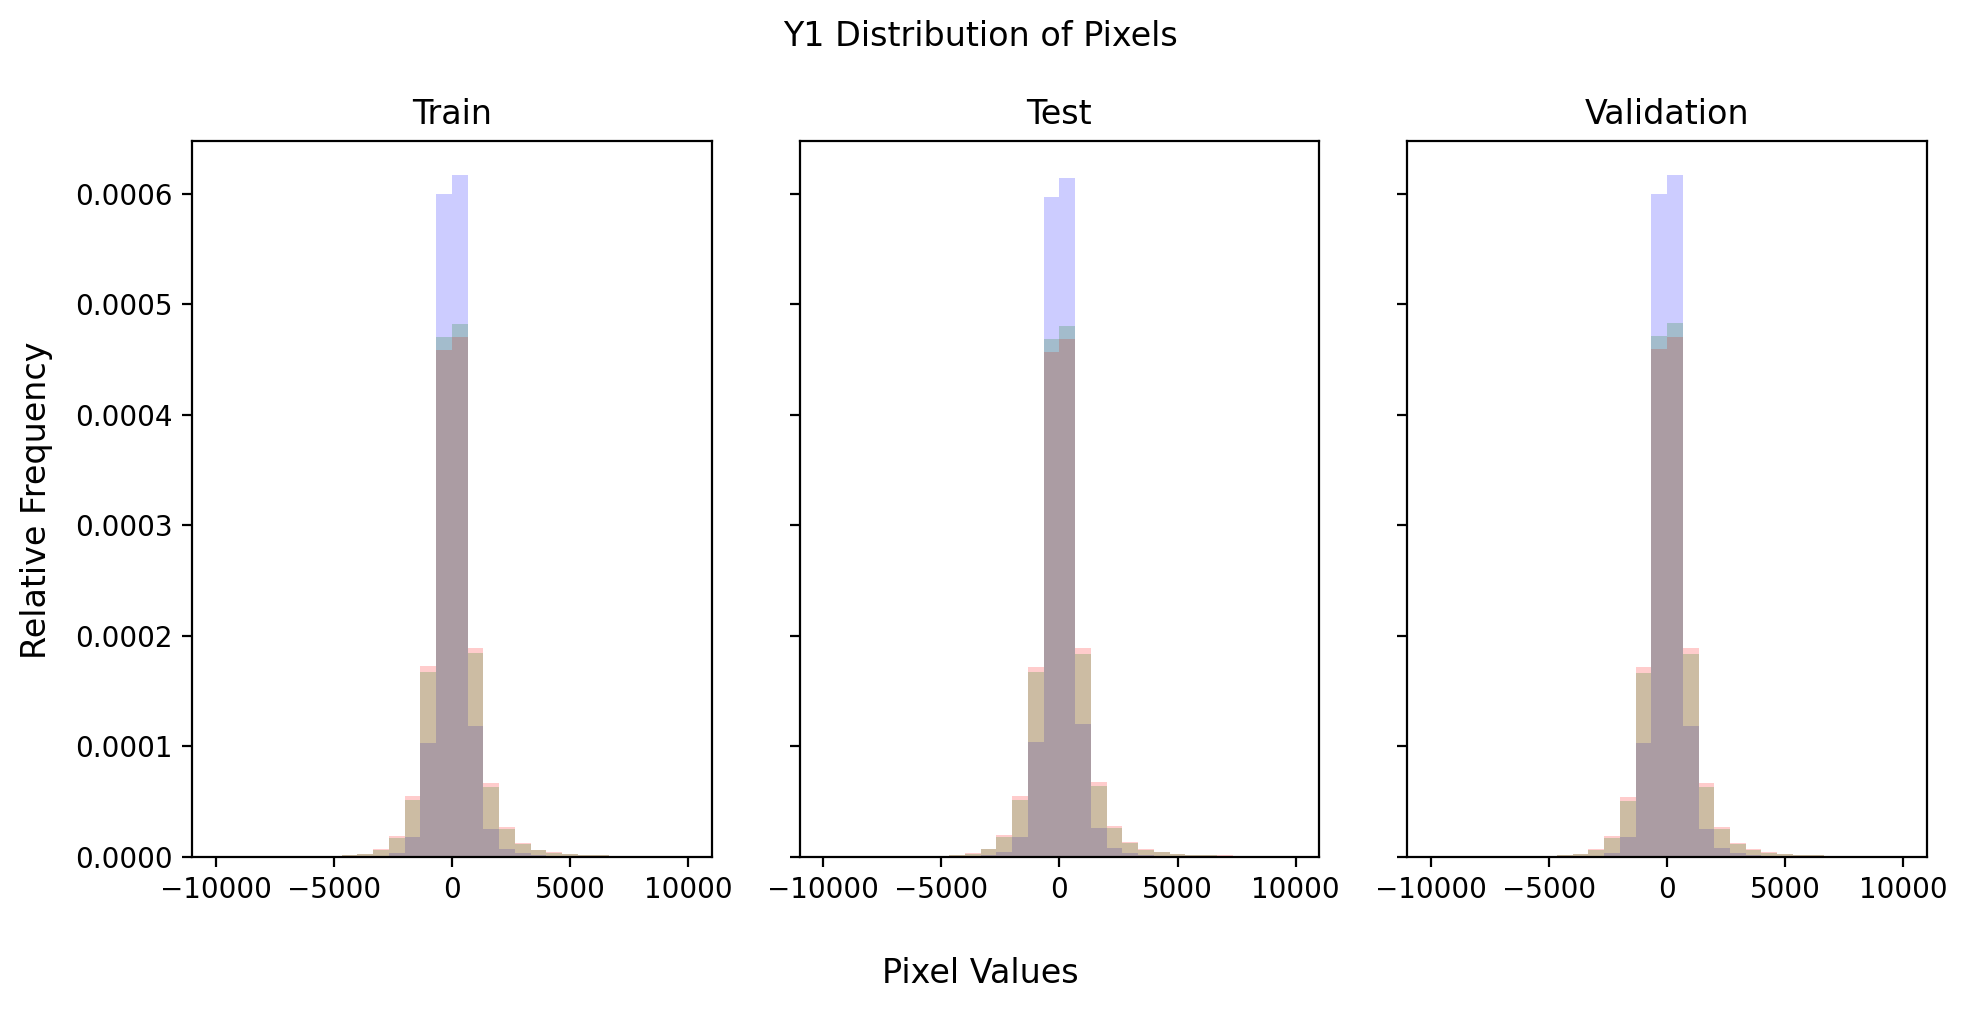

Train:

Min: -13510.646, Max: 1178185.250
Min: -24637.709, Max: 2572829.750
Min: -21624.816, Max: 2082440.500

Test:

Min: -13510.646, Max: 1178185.250
Min: -21407.996, Max: 2572829.750
Min: -18490.619, Max: 2082440.500

Validation:

Min: -8950.646, Max: 456532.875
Min: -17342.955, Max: 952291.688
Min: -18021.842, Max: 765298.688


In [12]:
# Year 1
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5), sharex=True, sharey=True)

ax1.hist(X_train_1[:, 0].ravel(), bins=30, color = 'blue', alpha = 0.2, 
        density=True, range=[-10000, 10000], stacked=True)
ax1.hist(X_train_1[:, 1].ravel(), bins=30, color = 'red', alpha = 0.2, 
        density=True, range=[-10000, 10000], stacked=True)
ax1.hist(X_train_1[:, 2].ravel(), bins=30, color = 'green', alpha = 0.2, density=True, range=[-10000, 10000], stacked=True)
ax1.set_title("Train")

ax2.hist(X_test_1[:, 0].ravel(), bins=30, color = 'blue', alpha = 0.2, 
        density=True, range=[-10000, 10000], stacked=True)
ax2.hist(X_test_1[:, 1].ravel(), bins=30, color = 'red', alpha = 0.2, 
        density=True, range=[-10000, 10000], stacked=True)
ax2.hist(X_test_1[:, 2].ravel(), bins=30, color = 'green', alpha = 0.2, density=True, range=[-10000, 10000], stacked=True)
ax2.set_title("Test")

ax3.hist(X_valid_1[:, 0].ravel(), bins=30, color = 'blue', alpha = 0.2, 
        density=True, range=[-10000, 10000], stacked=True)
ax3.hist(X_valid_1[:, 1].ravel(), bins=30, color = 'red', alpha = 0.2, 
        density=True, range=[-10000, 10000], stacked=True)
ax3.hist(X_valid_1[:, 2].ravel(), bins=30, color = 'green', alpha = 0.2, 
        density=True, range=[-10000, 10000], stacked=True)
ax3.set_title("Validation")

fig.suptitle("Y1 Distribution of Pixels")
fig.supxlabel("Pixel Values")
fig.supylabel("Relative Frequency")
plt.tight_layout()
#plt.savefig("Y1_pixels.jpg")
plt.show()

print('Train:\n')
print('Min: %.3f, Max: %.3f' % (np.amin(X_train_1[:, 0]), np.amax(X_train_1[:, 0])))
print('Min: %.3f, Max: %.3f' % (np.amin(X_train_1[:, 1]), np.amax(X_train_1[:, 1])))
print('Min: %.3f, Max: %.3f' % (np.amin(X_train_1[:, 2]), np.amax(X_train_1[:, 2])))

print('\nTest:\n')
print('Min: %.3f, Max: %.3f' % (np.amin(X_test_1[:, 0]), np.amax(X_test_1[:, 0])))
print('Min: %.3f, Max: %.3f' % (np.amin(X_test_1[:, 1]), np.amax(X_test_1[:, 1])))
print('Min: %.3f, Max: %.3f' % (np.amin(X_test_1[:, 2]), np.amax(X_test_1[:, 2])))

print('\nValidation:\n')
print('Min: %.3f, Max: %.3f' % (np.amin(X_valid_1[:, 0]), np.amax(X_valid_1[:, 0])))
print('Min: %.3f, Max: %.3f' % (np.amin(X_valid_1[:, 1]), np.amax(X_valid_1[:, 1])))
print('Min: %.3f, Max: %.3f' % (np.amin(X_valid_1[:, 2]), np.amax(X_valid_1[:, 2])))

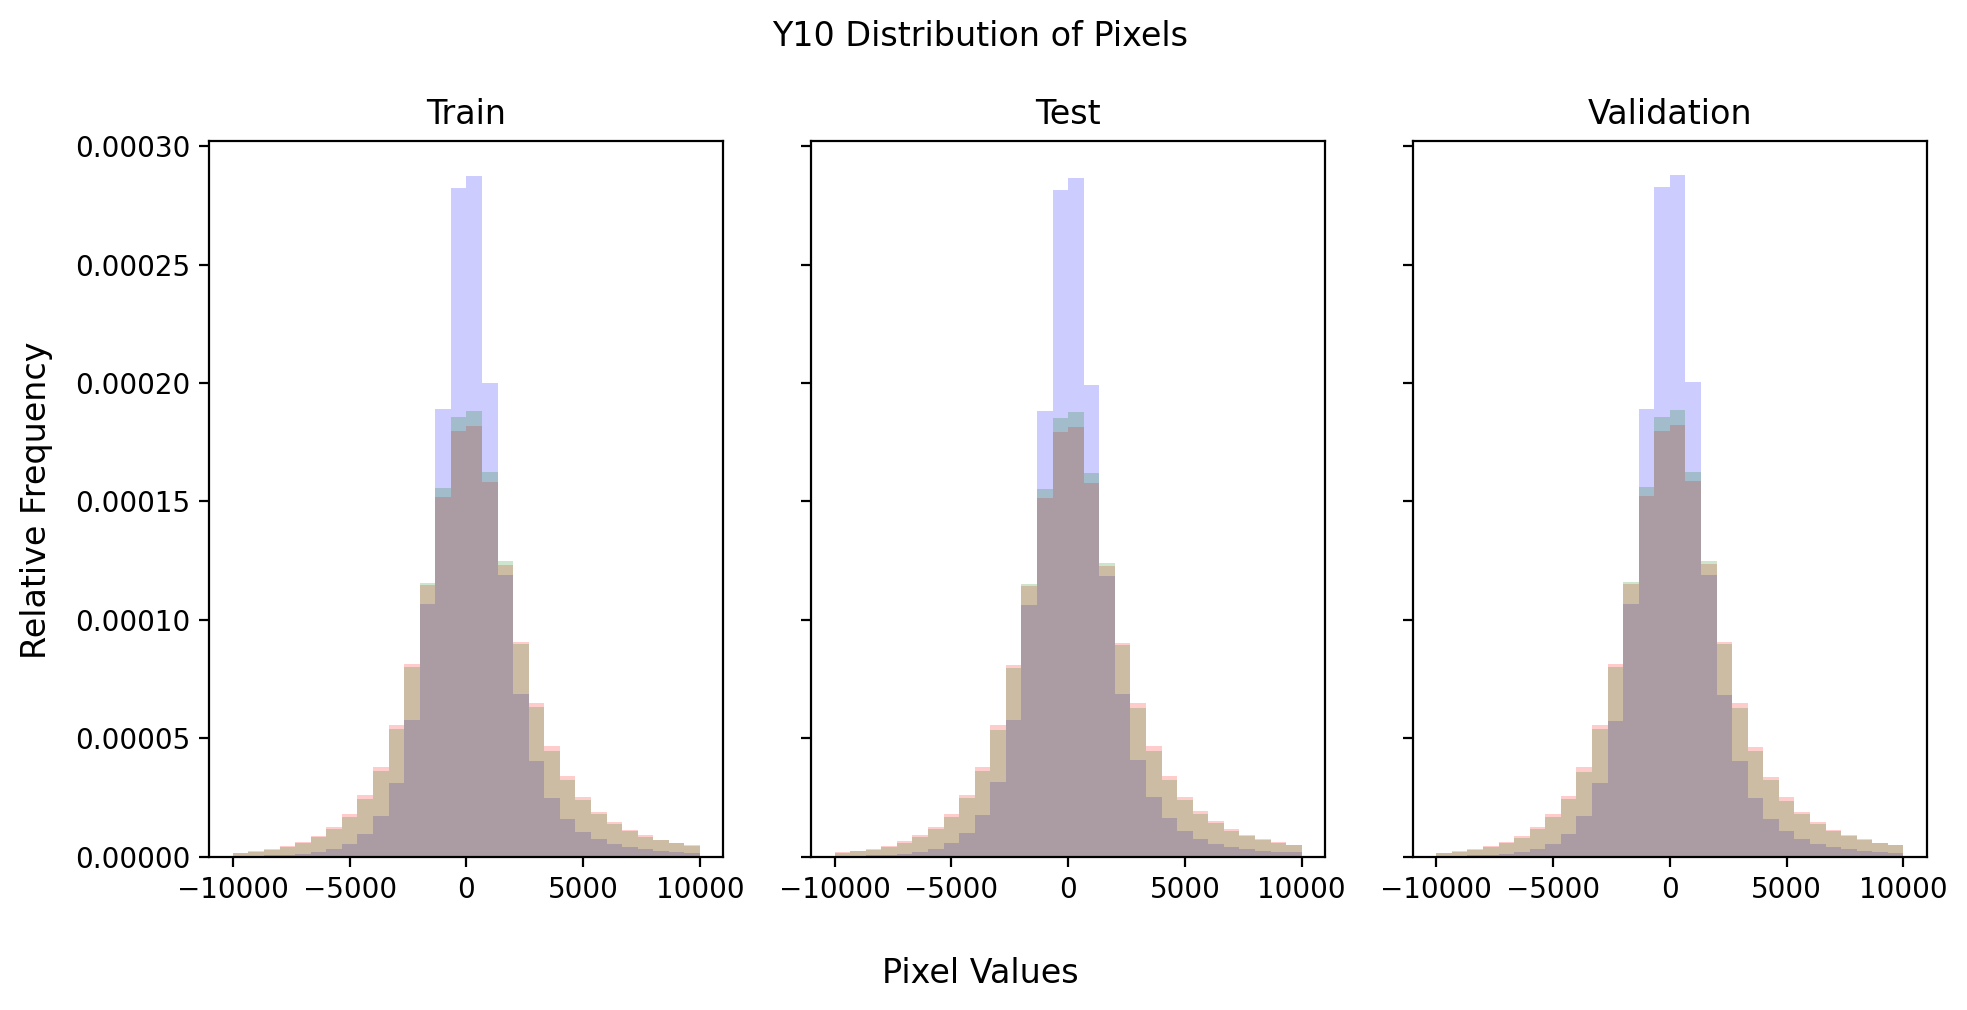

Train:

Min: -45121.941, Max: 11785052.000
Min: -61172.262, Max: 25809146.000
Min: -71376.992, Max: 20926832.000

Test:

Min: -39141.316, Max: 11785052.000
Min: -50422.684, Max: 25809146.000
Min: -57522.105, Max: 20926832.000

Validation:

Min: -24953.631, Max: 4572029.500
Min: -48626.875, Max: 9514766.000
Min: -53579.691, Max: 7667693.500


In [13]:
# Year 10
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5), sharex=True, sharey=True)

ax1.hist(X_train_10[:, 0].ravel(), bins=30, color = 'blue', alpha = 0.2, 
        density=True, range=[-10000, 10000], stacked=True)
ax1.hist(X_train_10[:, 1].ravel(), bins=30, color = 'red', alpha = 0.2, 
        density=True, range=[-10000, 10000], stacked=True)
ax1.hist(X_train_10[:, 2].ravel(), bins=30, color = 'green', alpha = 0.2, 
        density=True, range=[-10000, 10000], stacked=True)
ax1.set_title("Train")

ax2.hist(X_test_10[:, 0].ravel(), bins=30, color = 'blue', alpha = 0.2, 
        density=True, range=[-10000, 10000], stacked=True)
ax2.hist(X_test_10[:, 1].ravel(), bins=30, color = 'red', alpha = 0.2, 
        density=True, range=[-10000, 10000], stacked=True)
ax2.hist(X_test_10[:, 2].ravel(), bins=30, color = 'green', alpha = 0.2, 
        density=True, range=[-10000, 10000], stacked=True)
ax2.set_title("Test")

ax3.hist(X_valid_10[:, 0].ravel(), bins=30, color = 'blue', alpha = 0.2, 
        density=True, range=[-10000, 10000], stacked=True)
ax3.hist(X_valid_10[:, 1].ravel(), bins=30, color = 'red', alpha = 0.2, 
        density=True, range=[-10000, 10000], stacked=True)
ax3.hist(X_valid_10[:, 2].ravel(), bins=30, color = 'green', alpha = 0.2, 
        density=True, range=[-10000, 10000], stacked=True)
ax3.set_title("Validation")

fig.suptitle("Y10 Distribution of Pixels")
fig.supxlabel("Pixel Values")
fig.supylabel("Relative Frequency")
plt.tight_layout()
#plt.savefig("Y10_pixels.jpg")
plt.show()

print('Train:\n')
print('Min: %.3f, Max: %.3f' % (np.amin(X_train_10[:, 0]), np.amax(X_train_10[:, 0])))
print('Min: %.3f, Max: %.3f' % (np.amin(X_train_10[:, 1]), np.amax(X_train_10[:, 1])))
print('Min: %.3f, Max: %.3f' % (np.amin(X_train_10[:, 2]), np.amax(X_train_10[:, 2])))

print('\nTest:\n')
print('Min: %.3f, Max: %.3f' % (np.amin(X_test_10[:, 0]), np.amax(X_test_10[:, 0])))
print('Min: %.3f, Max: %.3f' % (np.amin(X_test_10[:, 1]), np.amax(X_test_10[:, 1])))
print('Min: %.3f, Max: %.3f' % (np.amin(X_test_10[:, 2]), np.amax(X_test_10[:, 2])))

print('\nValidation:\n')
print('Min: %.3f, Max: %.3f' % (np.amin(X_valid_10[:, 0]), np.amax(X_valid_10[:, 0])))
print('Min: %.3f, Max: %.3f' % (np.amin(X_valid_10[:, 1]), np.amax(X_valid_10[:, 1])))
print('Min: %.3f, Max: %.3f' % (np.amin(X_valid_10[:, 2]), np.amax(X_valid_10[:, 2])))

### Normalize Pixel Values

In [10]:
from numpy import arcsinh as arcsinh

def scale_pixels(t):
    #first clip outliers based on global values
    global_min = np.percentile(t, 0.1)
    global_max = np.percentile(t, 99.9)

    for i in range(0, 3):
        #g, r, i
        c = .85/global_max #gets you close to arcsinh(max_x) = 1, arcsinh(min_x) = 0
        t[:,i] = np.clip(t[:,i], global_min, global_max)
        t[:,i] = arcsinh(c*t[:, i])
        t[:,i] = (t[:,i] + 1.0) / 2.0
        
scale_pixels(X_train_1)
scale_pixels(X_test_1)
scale_pixels(X_valid_1)

scale_pixels(X_train_10)
scale_pixels(X_test_10)
scale_pixels(X_valid_10)

### Plot histograms of pixel values for each filter after scaling

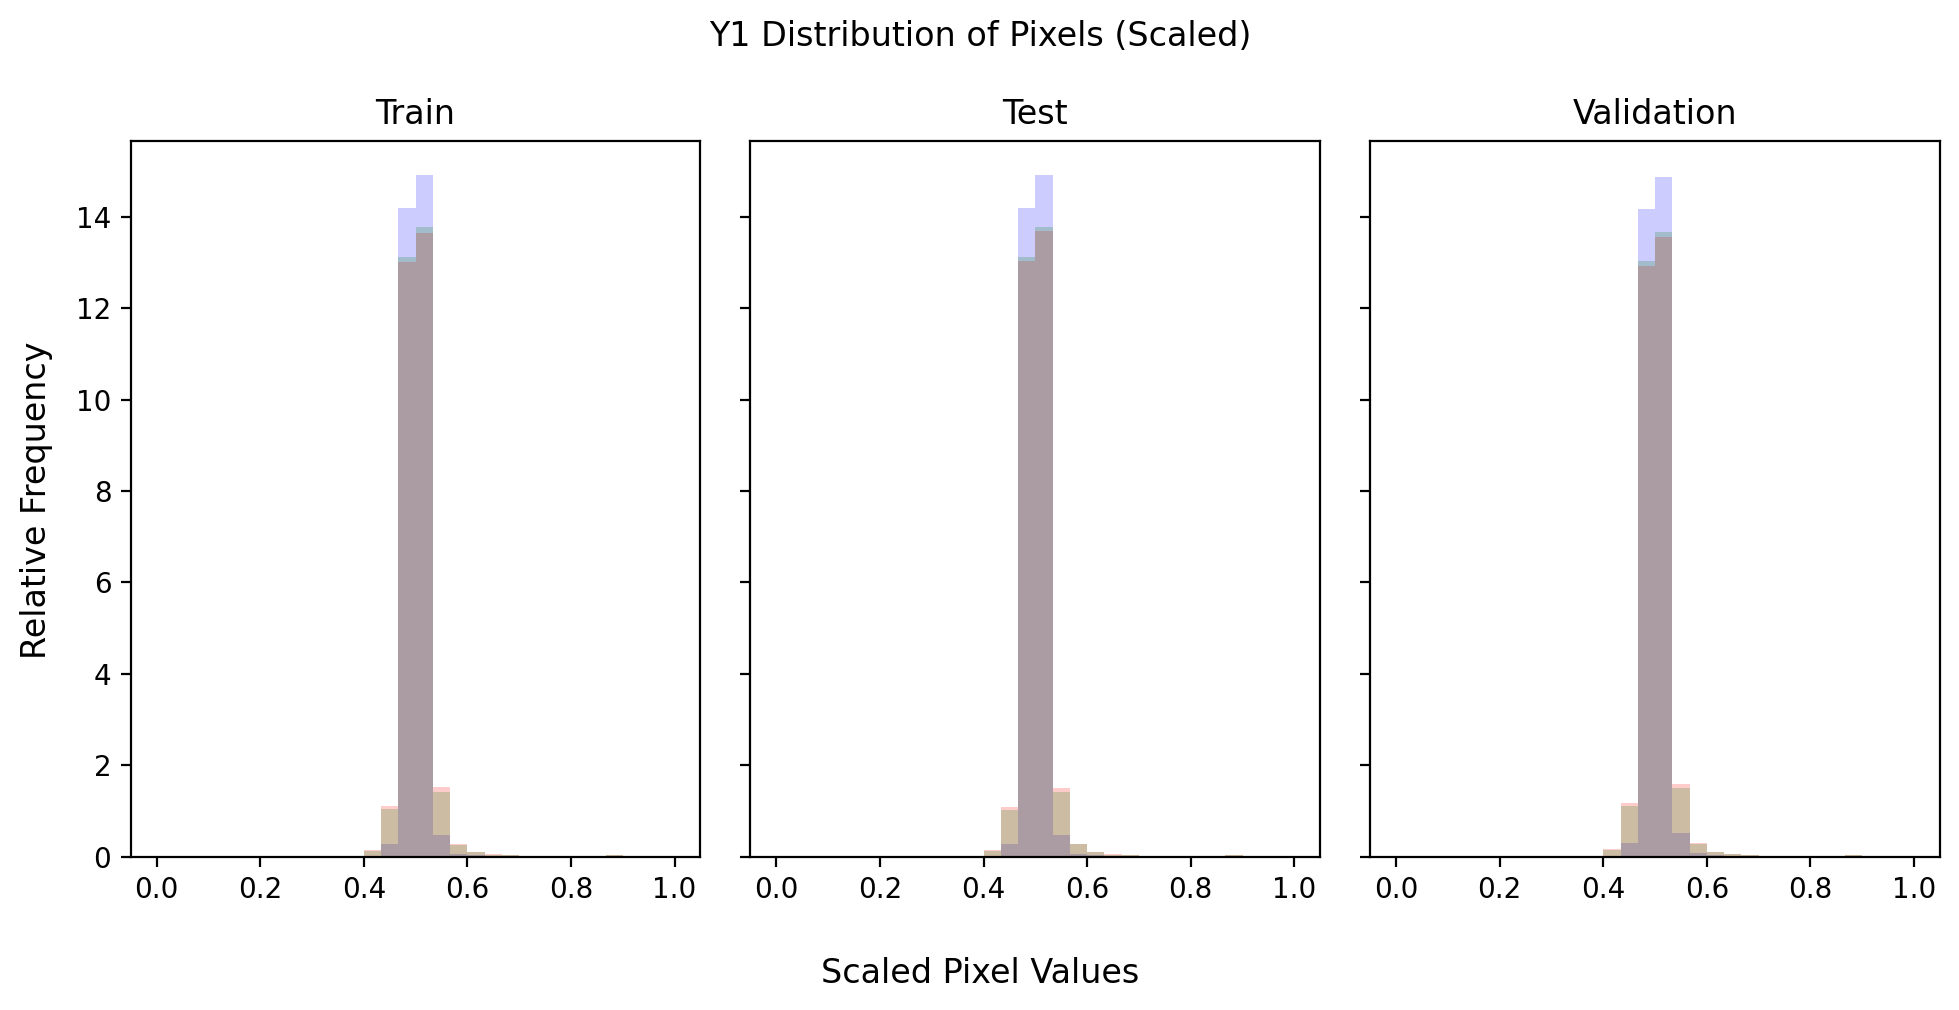

Train:

Min: 0.412, Max: 0.886
Min: 0.412, Max: 0.886
Min: 0.412, Max: 0.886

Test:

Min: 0.412, Max: 0.886
Min: 0.412, Max: 0.886
Min: 0.412, Max: 0.886

Validation:

Min: 0.410, Max: 0.886
Min: 0.410, Max: 0.886
Min: 0.410, Max: 0.886


In [15]:
# year 1
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5), sharex=True, sharey=True)

ax1.hist(X_train_1[:, 0].ravel(), bins=30, color = 'blue', alpha = 0.2, 
        density=True, range=[0, 1], stacked=True)
ax1.hist(X_train_1[:, 1].ravel(), bins=30, color = 'red', alpha = 0.2, 
        density=True, range=[0, 1], stacked=True)
ax1.hist(X_train_1[:, 2].ravel(), bins=30, color = 'green', alpha = 0.2, 
        density=True, range=[0, 1], stacked=True)
ax1.set_title("Train")

ax2.hist(X_test_1[:, 0].ravel(), bins=30, color = 'blue', alpha = 0.2, 
        density=True, range=[0, 1], stacked=True)
ax2.hist(X_test_1[:, 1].ravel(), bins=30, color = 'red', alpha = 0.2, 
        density=True, range=[0, 1], stacked=True)
ax2.hist(X_test_1[:, 2].ravel(), bins=30, color = 'green', alpha = 0.2, 
        density=True, range=[0, 1], stacked=True)
ax2.set_title("Test")

ax3.hist(X_valid_1[:, 0].ravel(), bins=30, color = 'blue', alpha = 0.2, 
        density=True, range=[0, 1], stacked=True)
ax3.hist(X_valid_1[:, 1].ravel(), bins=30, color = 'red', alpha = 0.2, 
        density=True, range=[0, 1], stacked=True)
ax3.hist(X_valid_1[:, 2].ravel(), bins=30, color = 'green', alpha = 0.2, 
        density=True, range=[0, 1], stacked=True)
ax3.set_title("Validation")

fig.suptitle("Y1 Distribution of Pixels (Scaled)")
fig.supxlabel("Scaled Pixel Values")
fig.supylabel("Relative Frequency")
plt.tight_layout()
#plt.savefig("Y1_pixels_scaled.jpg")
plt.show()

print('Train:\n')
print('Min: %.3f, Max: %.3f' % (np.amin(X_train_1[:, 0]), np.amax(X_train_1[:, 0])))
print('Min: %.3f, Max: %.3f' % (np.amin(X_train_1[:, 1]), np.amax(X_train_1[:, 1])))
print('Min: %.3f, Max: %.3f' % (np.amin(X_train_1[:, 2]), np.amax(X_train_1[:, 2])))

print('\nTest:\n')
print('Min: %.3f, Max: %.3f' % (np.amin(X_test_1[:, 0]), np.amax(X_test_1[:, 0])))
print('Min: %.3f, Max: %.3f' % (np.amin(X_test_1[:, 1]), np.amax(X_test_1[:, 1])))
print('Min: %.3f, Max: %.3f' % (np.amin(X_test_1[:, 2]), np.amax(X_test_1[:, 2])))

print('\nValidation:\n')
print('Min: %.3f, Max: %.3f' % (np.amin(X_valid_1[:, 0]), np.amax(X_valid_1[:, 0])))
print('Min: %.3f, Max: %.3f' % (np.amin(X_valid_1[:, 1]), np.amax(X_valid_1[:, 1])))
print('Min: %.3f, Max: %.3f' % (np.amin(X_valid_1[:, 2]), np.amax(X_valid_1[:, 2])))

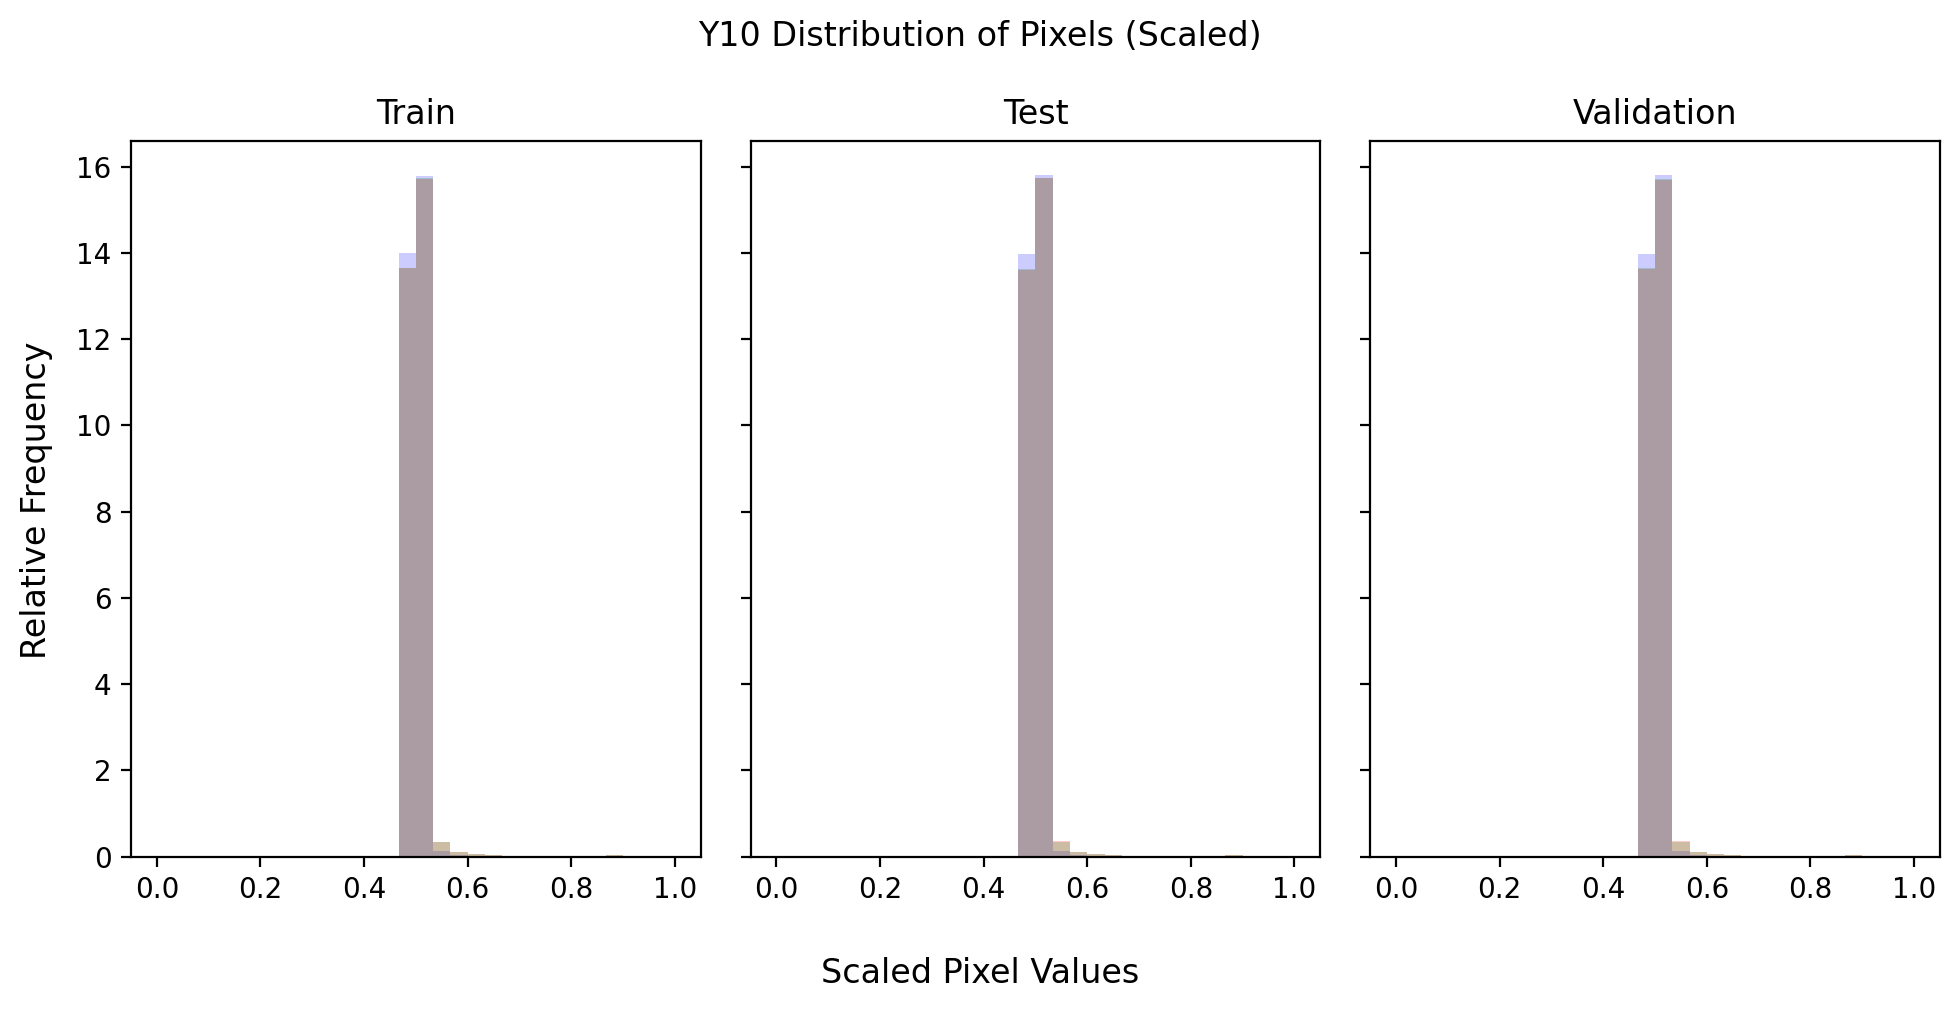

Train:

Min: 0.474, Max: 0.886
Min: 0.474, Max: 0.886
Min: 0.474, Max: 0.886

Test:

Min: 0.474, Max: 0.886
Min: 0.474, Max: 0.886
Min: 0.474, Max: 0.886

Validation:

Min: 0.473, Max: 0.886
Min: 0.473, Max: 0.886
Min: 0.473, Max: 0.886


In [16]:
# year 10
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5), sharex=True, sharey=True)

ax1.hist(X_train_10[:, 0].ravel(), bins=30, color = 'blue', alpha = 0.2, 
        density=True, range=[0, 1], stacked=True)
ax1.hist(X_train_10[:, 1].ravel(), bins=30, color = 'red', alpha = 0.2, 
        density=True, range=[0, 1], stacked=True)
ax1.hist(X_train_10[:, 2].ravel(), bins=30, color = 'green', alpha = 0.2, 
        density=True, range=[0, 1], stacked=True)
ax1.set_title("Train")

ax2.hist(X_test_10[:, 0].ravel(), bins=30, color = 'blue', alpha = 0.2, 
        density=True, range=[0, 1], stacked=True)
ax2.hist(X_test_10[:, 1].ravel(), bins=30, color = 'red', alpha = 0.2, 
        density=True, range=[0, 1], stacked=True)
ax2.hist(X_test_10[:, 2].ravel(), bins=30, color = 'green', alpha = 0.2, 
        density=True, range=[0, 1], stacked=True)
ax2.set_title("Test")

ax3.hist(X_valid_10[:, 0].ravel(), bins=30, color = 'blue', alpha = 0.2, 
        density=True, range=[0, 1], stacked=True)
ax3.hist(X_valid_10[:, 1].ravel(), bins=30, color = 'red', alpha = 0.2, 
        density=True, range=[0, 1], stacked=True)
ax3.hist(X_valid_10[:, 2].ravel(), bins=30, color = 'green', alpha = 0.2, 
        density=True, range=[0, 1], stacked=True)
ax3.set_title("Validation")

fig.suptitle("Y10 Distribution of Pixels (Scaled)")
fig.supxlabel("Scaled Pixel Values")
fig.supylabel("Relative Frequency")
plt.tight_layout()
#plt.savefig("Y10_pixels_scaled.jpg")
plt.show()

print('Train:\n')
print('Min: %.3f, Max: %.3f' % (np.amin(X_train_10[:, 0]), np.amax(X_train_10[:, 0])))
print('Min: %.3f, Max: %.3f' % (np.amin(X_train_10[:, 1]), np.amax(X_train_10[:, 1])))
print('Min: %.3f, Max: %.3f' % (np.amin(X_train_10[:, 2]), np.amax(X_train_10[:, 2])))

print('\nTest:\n')
print('Min: %.3f, Max: %.3f' % (np.amin(X_test_10[:, 0]), np.amax(X_test_10[:, 0])))
print('Min: %.3f, Max: %.3f' % (np.amin(X_test_10[:, 1]), np.amax(X_test_10[:, 1])))
print('Min: %.3f, Max: %.3f' % (np.amin(X_test_10[:, 2]), np.amax(X_test_10[:, 2])))

print('\nValidation:\n')
print('Min: %.3f, Max: %.3f' % (np.amin(X_valid_10[:, 0]), np.amax(X_valid_10[:, 0])))
print('Min: %.3f, Max: %.3f' % (np.amin(X_valid_10[:, 1]), np.amax(X_valid_10[:, 1])))
print('Min: %.3f, Max: %.3f' % (np.amin(X_valid_10[:, 2]), np.amax(X_valid_10[:, 2])))

### Example Images

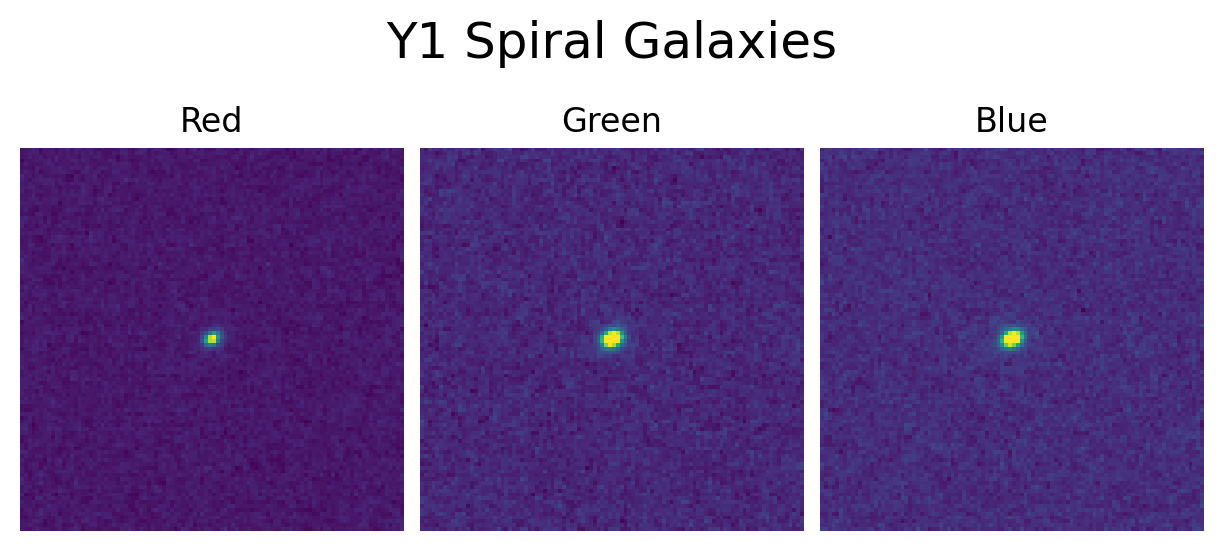

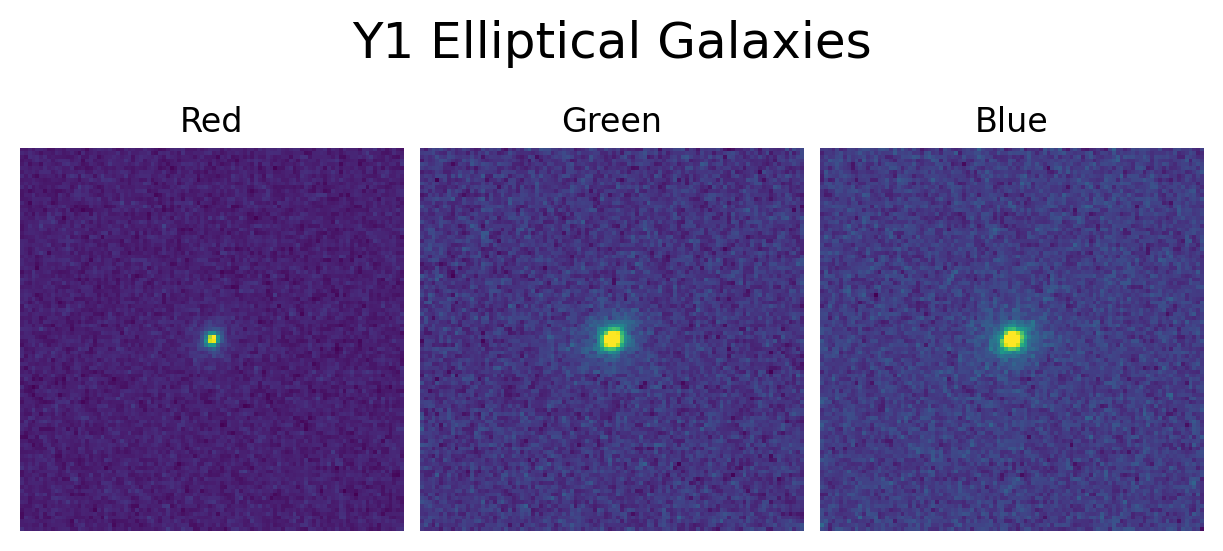

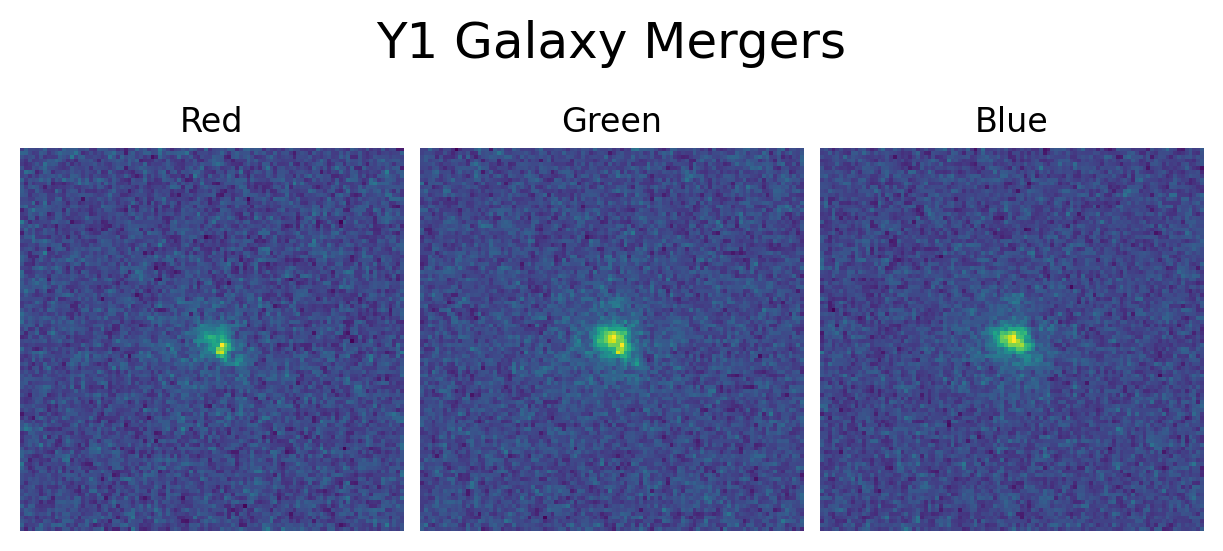

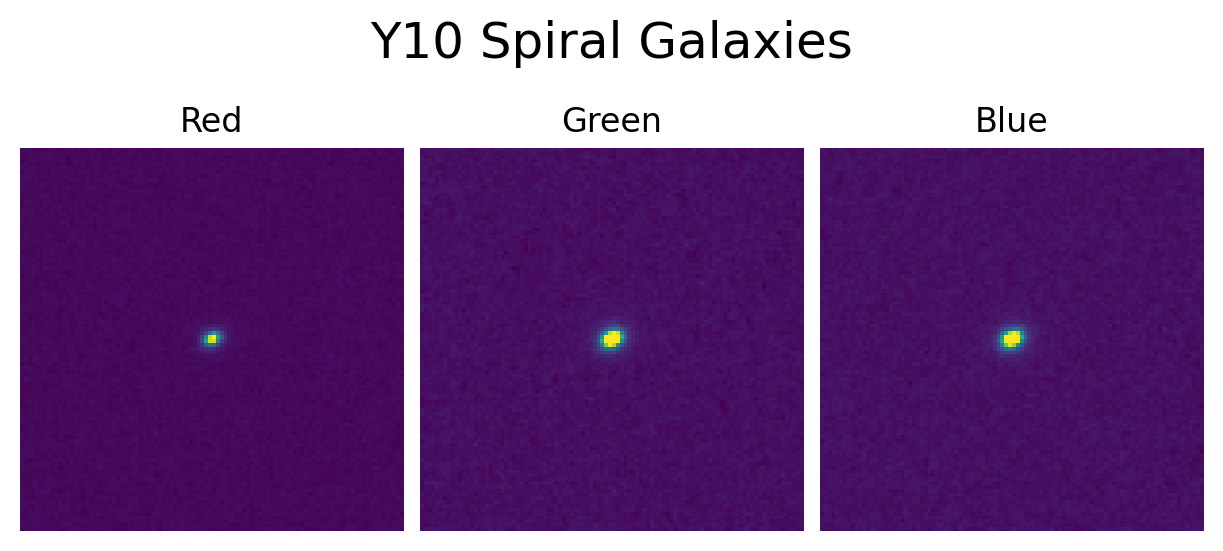

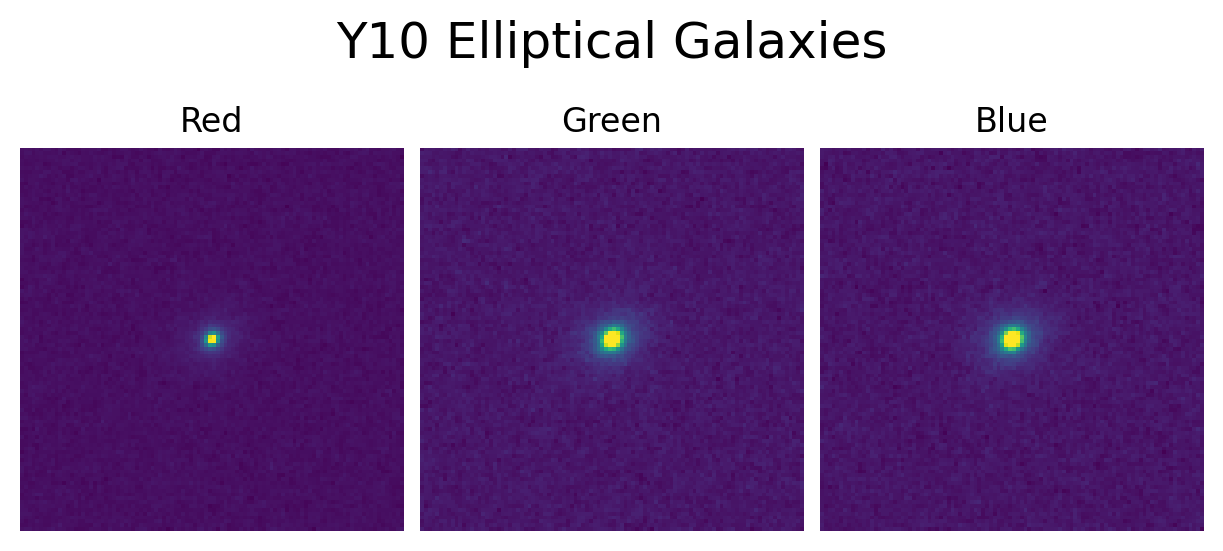

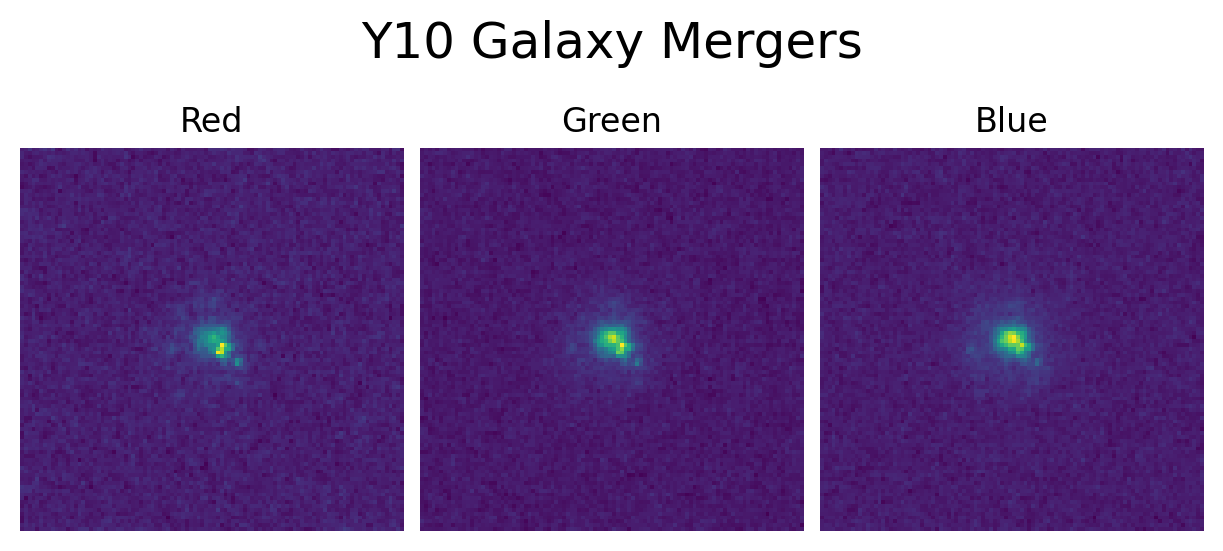

In [11]:
# Plot Y1 and Y10 images by RGB Filters
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(6,4), constrained_layout=True)
fig.suptitle('Y1 Spiral Galaxies', y=0.9, fontsize=18)
ax1.imshow(X_train_1[42,0])
ax1.axis("off")
ax1.set_title("Red")
ax2.imshow(X_train_1[42,1])
ax2.axis("off")
ax2.set_title("Green")
ax3.imshow(X_train_1[42,2])
ax3.axis("off")
ax3.set_title("Blue")
#plt.savefig("Y1 Spiral Example RGB Images")
plt.show()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(6,4), constrained_layout=True)
fig.suptitle('Y1 Elliptical Galaxies', y=0.9, fontsize=18)
ax1.imshow(X_train_1[14000,0])
ax1.axis("off")
ax1.set_title("Red")
ax2.imshow(X_train_1[14000,1])
ax2.axis("off")
ax2.set_title("Green")
ax3.imshow(X_train_1[14000,2])
ax3.axis("off")
ax3.set_title("Blue")
#plt.savefig("Y1 Elliptical Example RGB Images")
plt.show()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(6,4), constrained_layout=True)
fig.suptitle('Y1 Galaxy Mergers', y=0.9, fontsize=18)
ax1.imshow(X_train_1[23200,0])
ax1.axis("off")
ax1.set_title("Red")
ax2.imshow(X_train_1[23200,1])
ax2.axis("off")
ax2.set_title("Green")
ax3.imshow(X_train_1[23200,2])
ax3.axis("off")
ax3.set_title("Blue")
#plt.savefig("Y1 Mergers Example RGB Images")
plt.show()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(6,4), constrained_layout=True)
fig.suptitle('Y10 Spiral Galaxies', y=0.9, fontsize=18)
ax1.imshow(X_train_10[42,0])
ax1.axis("off")
ax1.set_title("Red")
ax2.imshow(X_train_10[42,1])
ax2.axis("off")
ax2.set_title("Green")
ax3.imshow(X_train_10[42,2])
ax3.axis("off")
ax3.set_title("Blue")
#plt.savefig("Y10 Spiral Example RGB Images")
plt.show()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(6,4), constrained_layout=True)
fig.suptitle('Y10 Elliptical Galaxies', y=0.9, fontsize=18)
ax1.imshow(X_train_10[14000,0])
ax1.axis("off")
ax1.set_title("Red")
ax2.imshow(X_train_10[14000,1])
ax2.axis("off")
ax2.set_title("Green")
ax3.imshow(X_train_10[14000,2])
ax3.axis("off")
ax3.set_title("Blue")
#plt.savefig("Y10 Elliptical Example RGB Images")
plt.show()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(6,4), constrained_layout=True)
fig.suptitle('Y10 Galaxy Mergers', y=0.9, fontsize=18)
ax1.imshow(X_train_10[23200,0])
ax1.axis("off")
ax1.set_title("Red")
ax2.imshow(X_train_10[23200,1])
ax2.axis("off")
ax2.set_title("Green")
ax3.imshow(X_train_10[23200,2])
ax3.axis("off")
ax3.set_title("Blue")
#plt.savefig("Y10 Mergers Example RGB Images")
plt.show()

# Exploratory Data Analysis

In [9]:
# Labels are one-hot encoded
Y_train_df = pd.DataFrame(Y_train)
Y_test_df = pd.DataFrame(Y_test)
Y_valid_df = pd.DataFrame(Y_valid)

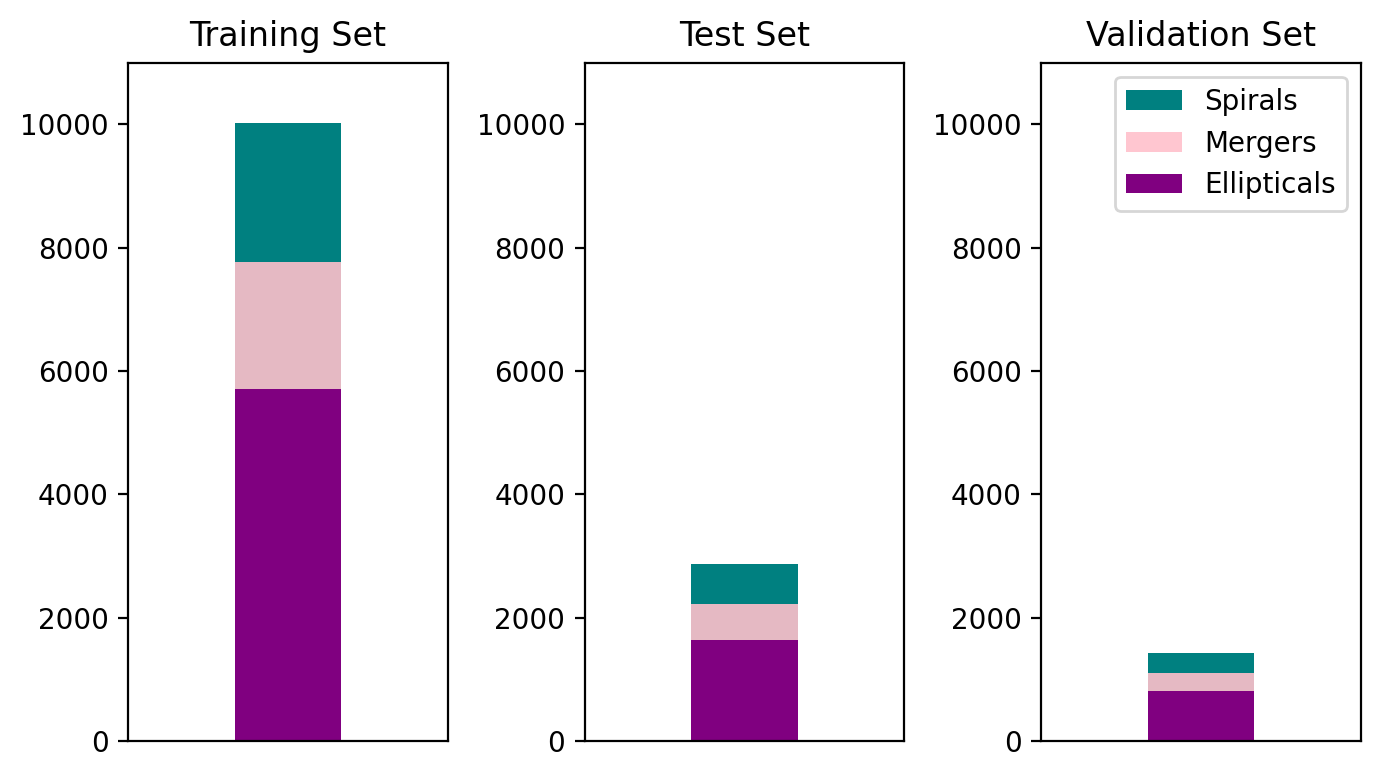

In [10]:
# Datasets by label
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(7, 4))

ax1.hist(Y_train_df[0].loc[Y_train_df[0] == 1.], label='Spirals', histtype='bar', color='teal')
ax1.hist(Y_train_df[2].loc[Y_train_df[2] == 1.], label='Mergers', histtype='bar', color='pink', alpha = 0.9)
ax1.hist(Y_train_df[1].loc[Y_train_df[1] == 1.], label='Ellipticals', histtype='bar', color='purple')
ax1.get_xaxis().set_visible(False)
ax1.set_xlim(0.9,1.2)
ax1.set_ylim(0,11000)
ax1.set_title('Training Set')

ax2.hist(Y_test_df[0].loc[Y_test_df[0] == 1.], label='Spirals', histtype='bar', color='teal')
ax2.hist(Y_test_df[2].loc[Y_test_df[2] == 1.], label='Mergers', histtype='bar', color='pink', alpha = 0.9)  
ax2.hist(Y_test_df[1].loc[Y_test_df[1] == 1.], label='Ellipticals', histtype='bar', color='purple')
ax2.get_xaxis().set_visible(False)
ax2.set_xlim(0.9,1.2)
ax2.set_ylim(0,11000)
ax2.set_title('Test Set')

ax3.hist(Y_valid_df[0].loc[Y_valid_df[0] == 1.], label='Spirals', histtype='bar', color='teal')
ax3.hist(Y_valid_df[2].loc[Y_valid_df[2] == 1.], label='Mergers', histtype='bar', color='pink', alpha = 0.9)
ax3.hist(Y_valid_df[1].loc[Y_valid_df[1] == 1.], label='Ellipticals', histtype='bar', color='purple')
ax3.get_xaxis().set_visible(False)
ax3.set_xlim(0.9,1.2)
ax3.set_ylim(0,11000)
ax3.set_title('Validation Set')

plt.tight_layout()
plt.legend()
#plt.savefig("Dataset by Label")
plt.show()

# Create Deterministic CNN Model

### Model 1b

Similar to DeepMerge architecture

Loss: Categorical Cross-entropy

Optimizer: Adam (default learning rate too large- try 1e-4)

Uses Image Augmentation: False

In [13]:
# Set seed for reproducibility
random.seed(0)

## Define model architecture with the Functional API
# channels first: (channels, rows, cols)
input_shape = (3, 100, 100)

# Input layer (visible layer)
x = Input(shape=input_shape)

# Hidden layers
c0 = Conv2D(8, (5, 5), activation='relu', strides=(1, 1), padding='same', 
            data_format='channels_first', name='conv_1')(x)
b0 = BatchNormalization()(c0)
d0 = MaxPool2D(pool_size=(2, 2), strides=None, padding='valid', 
               data_format='channels_first', name='maxpool_1')(b0)
e0 = Dropout(0.1)(d0)

c1 = Conv2D(16, (3, 3), activation='relu', strides=(1, 1), padding='same', 
            data_format='channels_first', name='conv_2')(e0)
b1 = BatchNormalization()(c1)
d1 = MaxPool2D(pool_size=(2, 2), strides=None, padding='valid', 
               data_format='channels_first', name='maxpool_2')(b1)
e1 = Dropout(0.1)(d1)

c2 = Conv2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same', 
            data_format='channels_first', name='conv_3')(e1)
b2 = BatchNormalization()(c2)
d2 = MaxPool2D(pool_size=(2, 2), strides=None, padding='valid', 
            data_format='channels_first', name='maxpool_3')(b2)
e2 = Dropout(0.1)(d2)

# Flatten the 3D output to 1D
f = Flatten()(e2)
z0 = Dense(64, activation='relu', kernel_regularizer=l2(0.0001), name='dense_1')(f)
z1 = Dense(32, activation='relu', kernel_regularizer=l2(0.0001), name='dense_2')(z0)
# Output layer: creates 3 one-hot encoded output values, one for each class
y = Dense(NUM_CLASSES, activation='softmax', name='output')(z1)

model = Model(inputs=x, outputs=y, name="Model-1b")

## Compile Model
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()
model.compile(loss = loss, optimizer = optimizer, metrics = ['accuracy'])
model.summary()

Model: "Model-1b"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 3, 100, 100)]     0         
                                                                 
 conv_1 (Conv2D)             (None, 8, 100, 100)       608       
                                                                 
 batch_normalization_6 (Batc  (None, 8, 100, 100)      400       
 hNormalization)                                                 
                                                                 
 maxpool_1 (MaxPooling2D)    (None, 8, 50, 50)         0         
                                                                 
 dropout_6 (Dropout)         (None, 8, 50, 50)         0         
                                                                 
 conv_2 (Conv2D)             (None, 16, 50, 50)        1168      
                                                          

In [14]:
## Define Callback Functions
es = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10),
      ModelCheckpoint(filepath=f'Y10_{model.name}_best_weights', monitor='val_accuracy',
                      mode='max', verbose=0, save_best_only=True)
      ]

In [15]:
## Train Model
# Set seed for reproducibility
random.seed(0)

batch_size = 128
NUM_EPOCH = 200
history = model.fit(X_train_10, Y_train,
                    batch_size = batch_size,
                    epochs = NUM_EPOCH,
                    validation_data = (X_valid_10, Y_valid),                
                    shuffle = True,
                    class_weight = class_weights,
                    verbose = 1,
                    callbacks = es
            )

Epoch 1/200


2022-10-18 12:47:22.551534: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-18 12:47:23.257021: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


184/184 [==============================] - ETA: 0s - loss: 1.1236 - accuracy: 0.3780

2022-10-18 12:48:30.785503: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


184/184 [==============================] - 69s 373ms/step - loss: 1.1236 - accuracy: 0.3780 - val_loss: 1.0841 - val_accuracy: 0.4411
Epoch 2/200
184/184 [==============================] - 66s 361ms/step - loss: 1.0731 - accuracy: 0.4578 - val_loss: 1.0600 - val_accuracy: 0.4650
Epoch 3/200
184/184 [==============================] - 67s 364ms/step - loss: 1.0541 - accuracy: 0.4966 - val_loss: 1.0458 - val_accuracy: 0.4882
Epoch 4/200
184/184 [==============================] - 67s 364ms/step - loss: 1.0395 - accuracy: 0.5068 - val_loss: 1.0357 - val_accuracy: 0.4814
Epoch 5/200
184/184 [==============================] - 67s 365ms/step - loss: 1.0207 - accuracy: 0.5138 - val_loss: 1.0209 - val_accuracy: 0.4799
Epoch 6/200
184/184 [==============================] - 74s 400ms/step - loss: 0.9898 - accuracy: 0.5416 - val_loss: 1.0006 - val_accuracy: 0.4909
Epoch 7/200
184/184 [==============================] - 67s 364ms/step - loss: 0.9650 - accuracy: 0.5483 - val_loss: 1.0096 - val_accurac

INFO:tensorflow:Assets written to: Model-1b.json/assets


INFO:tensorflow:Assets written to: Model-1b.json/assets


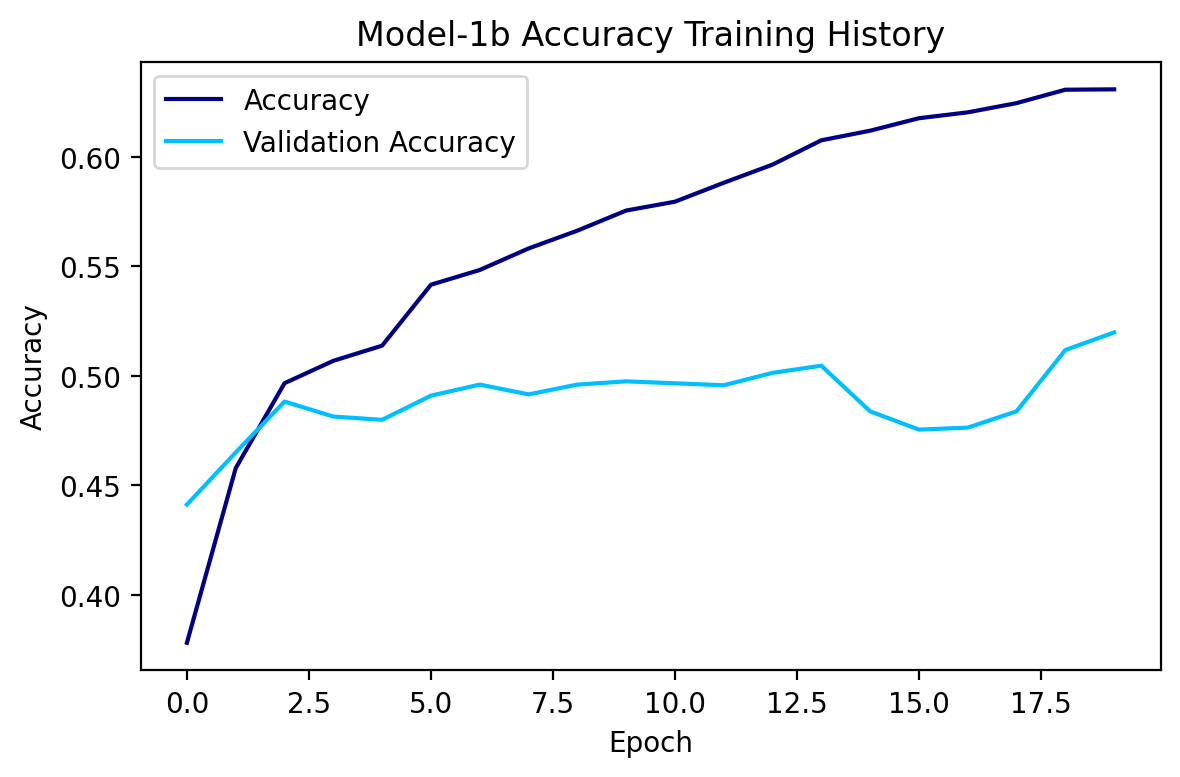

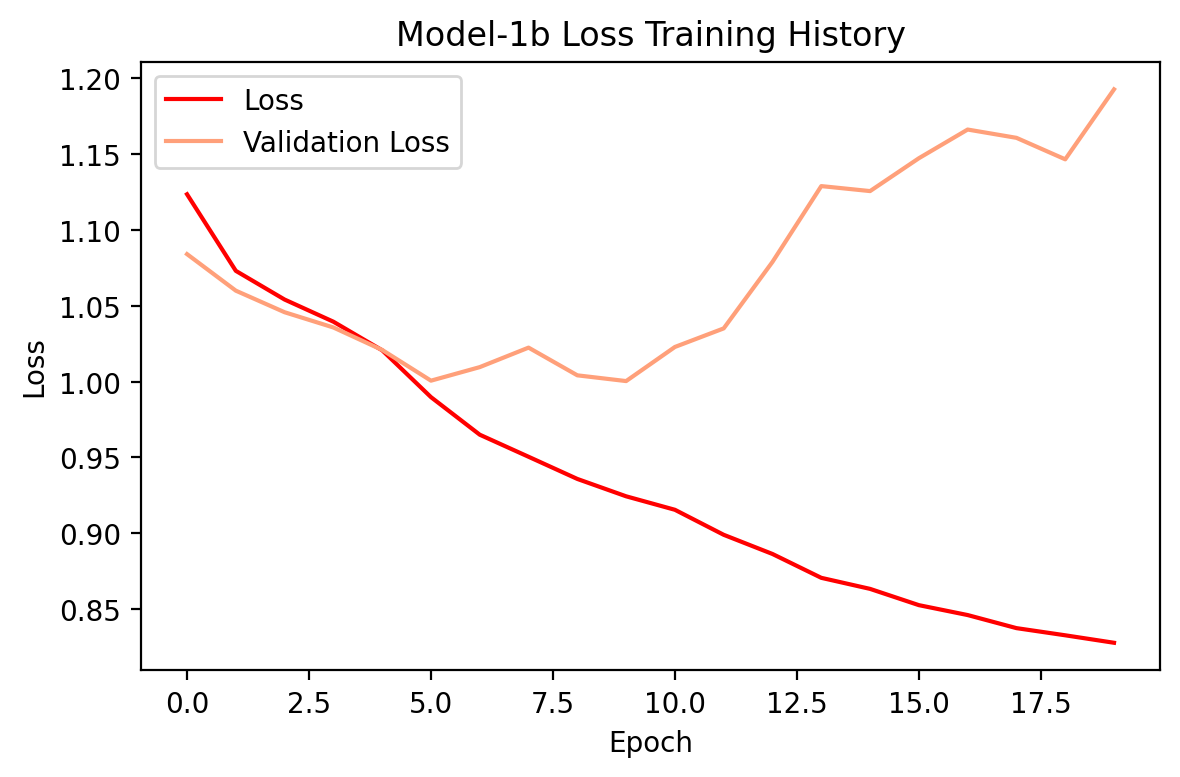

In [16]:
# Save model data
save_model_data(model, history)

# Plot training history
plot_training(model, history)

In [ ]:
# Make Classification report, Confusion Matrix, and compute ROC & AUC for each class in each dataset
y_pred = model.predict(X_train_10)
        
# Classification report
classification_metrics = make_classification_report(
    np.argmax(Y_train, axis=1), 
    np.argmax(y_pred, axis=1)
    )
print("Train:\n" + classification_metrics + '\n')

# Confusion Matrix
cd = make_cm(model, 
              np.argmax(Y_train, axis=1), 
              np.argmax(model.predict(X_train_10), axis=1)
              )
cd.plot(values_format='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title(f'{model.name} Train Confusion Matrix')
plt.tight_layout()
plt.savefig(f'{model.name}_train_CM')
plt.show()

## ROC curves & AUC for a categorical classifier
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], thresholds = roc_curve(Y_train[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize = (6, 5), tight_layout=True)
colors = ['blue', 'red', 'green', 'brown', 'purple', 'pink', 'orange', 'black', 'yellow', 'cyan']
for i, color, lbl in zip(range(NUM_CLASSES), colors, class_names):
    plt.plot(fpr[i], tpr[i], color = color, lw = 1.5,
    label = 'ROC Curve of class {0} (area = {1:0.3f})'.format(lbl, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Selectivity)')
plt.legend(loc="lower right")
plt.title(f'{model.name}Train ROC Curves')
plt.savefig(f'{model.name}_train_ROC')
plt.show()

210/210 [==============================] - 2s 11ms/step
Test:
              precision    recall  f1-score   support

      Spiral       0.80      0.65      0.72      2863
  Elliptical       0.45      0.77      0.57      1631
      Merger       0.61      0.44      0.51      2221

    accuracy                           0.61      6715
   macro avg       0.62      0.62      0.60      6715
weighted avg       0.65      0.61      0.61      6715


210/210 [==============================] - 2s 11ms/step


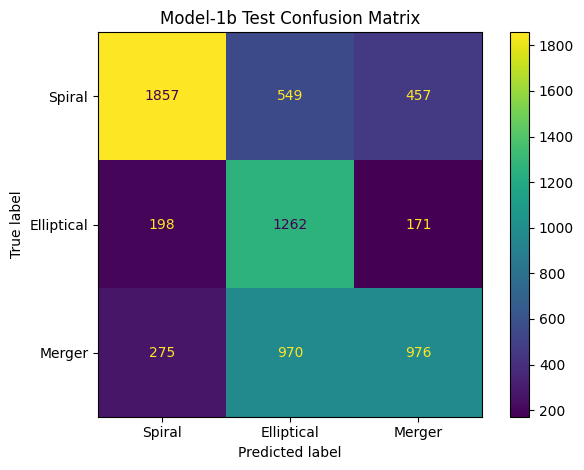

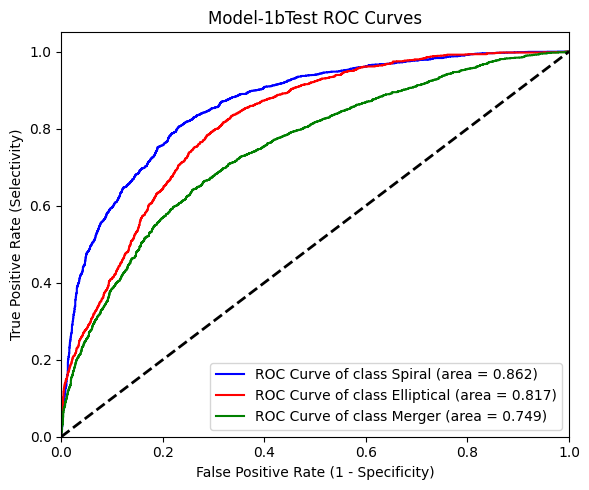

In [ ]:
# Make Classification report, Confusion Matrix, and compute ROC & AUC for each class in each dataset
y_pred = model.predict(X_test_10)
        
# Classification report
classification_metrics = make_classification_report(
    np.argmax(Y_test, axis=1), 
    np.argmax(y_pred, axis=1)
    )
print("Test:\n" + classification_metrics + '\n')

# Confusion Matrix
cd = make_cm(model, 
              np.argmax(Y_test, axis=1), 
              np.argmax(model.predict(X_test_10), axis=1)
              )
cd.plot(values_format='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title(f'{model.name} Test Confusion Matrix')
plt.tight_layout()
plt.savefig(f'{model.name}_test_CM')
plt.show()

## ROC curves & AUC for a categorical classifier
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], thresholds = roc_curve(Y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize = (6, 5), tight_layout=True)
colors = ['blue', 'red', 'green', 'brown', 'purple', 'pink', 'orange', 'black', 'yellow', 'cyan']
for i, color, lbl in zip(range(NUM_CLASSES), colors, class_names):
    plt.plot(fpr[i], tpr[i], color = color, lw = 1.5,
    label = 'ROC Curve of class {0} (area = {1:0.3f})'.format(lbl, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Selectivity)')
plt.legend(loc="lower right")
plt.title(f'{model.name} Test ROC Curves')
plt.savefig(f'{model.name}_test_ROC')
plt.show()

105/105 [==============================] - 1s 11ms/step
Validation:
              precision    recall  f1-score   support

      Spiral       0.80      0.66      0.72      1432
  Elliptical       0.48      0.78      0.59       815
      Merger       0.59      0.45      0.51      1108

    accuracy                           0.62      3355
   macro avg       0.62      0.63      0.61      3355
weighted avg       0.65      0.62      0.62      3355


105/105 [==============================] - 1s 11ms/step


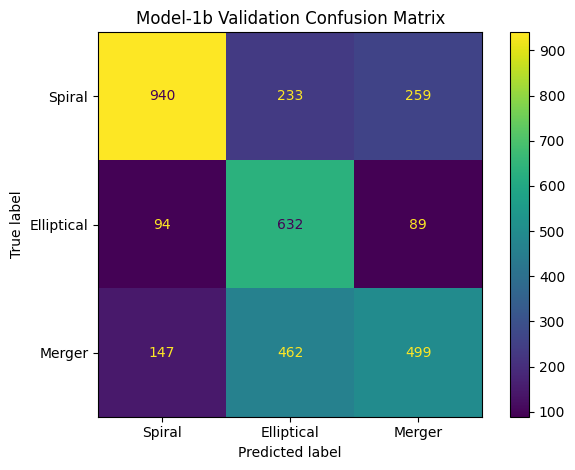

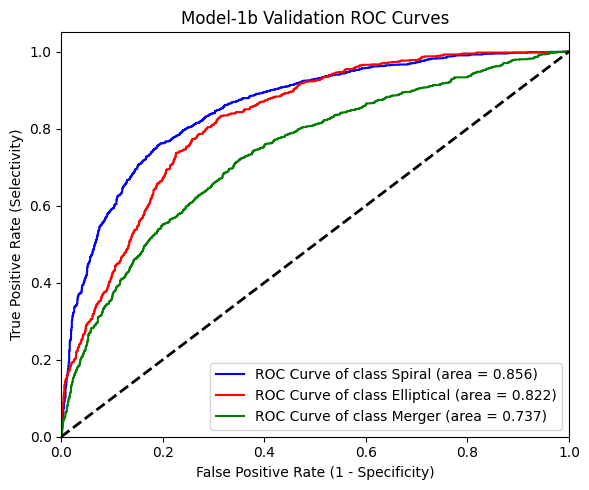

In [ ]:
# Make Classification report, Confusion Matrix, and compute ROC & AUC for each class in each dataset
y_pred = model.predict(X_valid_10)
        
# Classification report
classification_metrics = make_classification_report(
    np.argmax(Y_valid, axis=1), 
    np.argmax(y_pred, axis=1)
    )
print("Validation:\n" + classification_metrics + '\n')

# Confusion Matrix
cd = make_cm(model, 
              np.argmax(Y_valid, axis=1), 
              np.argmax(model.predict(X_valid_10), axis=1)
              )
cd.plot(values_format='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title(f'{model.name} Validation Confusion Matrix')
plt.tight_layout()
plt.savefig(f'{model.name}_validation_CM')
plt.show()

## ROC curves & AUC for a categorical classifier
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], thresholds = roc_curve(Y_valid[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize = (6, 5), tight_layout=True)
colors = ['blue', 'red', 'green', 'brown', 'purple', 'pink', 'orange', 'black', 'yellow', 'cyan']
for i, color, lbl in zip(range(NUM_CLASSES), colors, class_names):
    plt.plot(fpr[i], tpr[i], color = color, lw = 1.5,
    label = 'ROC Curve of class {0} (area = {1:0.3f})'.format(lbl, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Selectivity)')
plt.legend(loc="lower right")
plt.title(f'{model.name} Validation ROC Curves')
plt.tight_layout()
plt.savefig(f'{model.name}_validation_ROC')
plt.show()

In [ ]:
# Make Classification report, Confusion Matrix, and compute ROC & AUC for each class in each dataset
y_pred = model.predict(X_test_1)
        
# Classification report
classification_metrics = make_classification_report(
    np.argmax(Y_test, axis=1), 
    np.argmax(y_pred, axis=1)
    )
print("Year 1 Test:\n" + classification_metrics + '\n')

210/210 [==============================] - 2s 11ms/step
Year 1 Test:
              precision    recall  f1-score   support

      Spiral       0.74      0.69      0.72      2863
  Elliptical       0.51      0.40      0.45      1631
      Merger       0.55      0.69      0.62      2221

    accuracy                           0.62      6715
   macro avg       0.60      0.60      0.59      6715
weighted avg       0.63      0.62      0.62      6715




### Model 3b
Similar to DeepMerge architecture but added pooling padding

Loss: Categorical Cross-entropy

Optimizer: Adam

Uses Image Augmentation: False

Change: Back to Model 1 architecture; try padding in pooling

In [52]:
# Set seed for reproducibility
random.seed(0)

## Define model architecture with the Functional API
input_shape = (3, 100, 100)
x = Input(shape=input_shape)

c0 = Conv2D(8, kernel_size=(5, 5), activation='relu', strides=(1, 1), padding='same', data_format='channels_first', name='conv_1')(x)
b0 = BatchNormalization()(c0)
d0 = MaxPooling2D(pool_size=(2, 2), strides=2, padding='same', data_format='channels_first', name='maxpool_1')(b0)
e0 = Dropout(0.1)(d0)

c1 = Conv2D(16, kernel_size=(3, 3), activation='relu', strides=(1, 1), padding='same', data_format='channels_first', name='conv_2')(e0)
b1 = BatchNormalization()(c1)
d1 = MaxPooling2D(pool_size=(2, 2), strides=2, padding='same', data_format='channels_first', name='maxpool_2')(b1)
e1 = Dropout(0.1)(d1)

c2 = Conv2D(32, kernel_size=(3, 3), activation='relu', strides=(1, 1), padding='same', data_format='channels_first', name='conv_3')(e1)
b2 = BatchNormalization()(c2)
d2 = MaxPooling2D(pool_size=(2, 2), strides=2, padding='same', data_format='channels_first', name='maxpool_3')(b2)
e2 = Dropout(0.1)(d2)

f = Flatten()(e2)
z0 = Dense(64, activation='relu', kernel_regularizer=l2(0.0001), name='dense_1')(f)
z1 = Dense(32, activation='relu', kernel_regularizer=l2(0.0001), name='dense_2')(z0)
y = Dense(NUM_CLASSES, activation='softmax', name='output')(z1)

model_3 = Model(inputs=x, outputs=y, name="Model-3b")

## Compile Model
loss = CategoricalCrossentropy(from_logits=True)
optimizer = Adam()
compile_model(model_3, loss=loss, optimizer = optimizer)

Model: "Model-3b"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 3, 100, 100)]     0         
                                                                 
 conv_1 (Conv2D)             (None, 8, 100, 100)       608       
                                                                 
 batch_normalization_12 (Bat  (None, 8, 100, 100)      400       
 chNormalization)                                                
                                                                 
 maxpool_1 (MaxPooling2D)    (None, 8, 50, 50)         0         
                                                                 
 dropout_12 (Dropout)        (None, 8, 50, 50)         0         
                                                                 
 conv_2 (Conv2D)             (None, 16, 50, 50)        1168      
                                                          

In [53]:
## Define Callback Functions
es = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10),
        ModelCheckpoint(filepath='Y10_best_weights.h5', monitor='val_accuracy', 
                        mode='max', verbose=1, save_best_only=True)
      ]

In [54]:
## Train model
# Set seed for reproducibility
random.seed(0)

batch_size = 128
NUM_EPOCH = 200
history_3 = model_3.fit(X_train_10, Y_train,
                    batch_size = batch_size,
                    epochs = NUM_EPOCH,
                    validation_data = (X_valid_10, Y_valid),
                    shuffle = True,
                    class_weight = class_weights,
                    verbose = 1,
                    callbacks = es
            )

Epoch 1/200


2022-10-06 12:33:09.613626: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


184/184 [==============================] - ETA: 0s - loss: 1.1605 - accuracy: 0.3669

2022-10-06 12:34:20.067856: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.42683, saving model to Y10_best_weights.h5
184/184 [==============================] - 72s 386ms/step - loss: 1.1605 - accuracy: 0.3669 - val_loss: 1.2535 - val_accuracy: 0.4268
Epoch 2/200
184/184 [==============================] - ETA: 0s - loss: 1.0683 - accuracy: 0.4673
Epoch 2: val_accuracy did not improve from 0.42683
184/184 [==============================] - 67s 365ms/step - loss: 1.0683 - accuracy: 0.4673 - val_loss: 2.2769 - val_accuracy: 0.2429
Epoch 3/200
184/184 [==============================] - ETA: 0s - loss: 1.0316 - accuracy: 0.5184
Epoch 3: val_accuracy did not improve from 0.42683
184/184 [==============================] - 67s 366ms/step - loss: 1.0316 - accuracy: 0.5184 - val_loss: 3.5800 - val_accuracy: 0.2429
Epoch 4/200
184/184 [==============================] - ETA: 0s - loss: 0.9987 - accuracy: 0.5385
Epoch 4: val_accuracy did not improve from 0.42683
184/184 [==============================] - 68s 369ms/step - loss

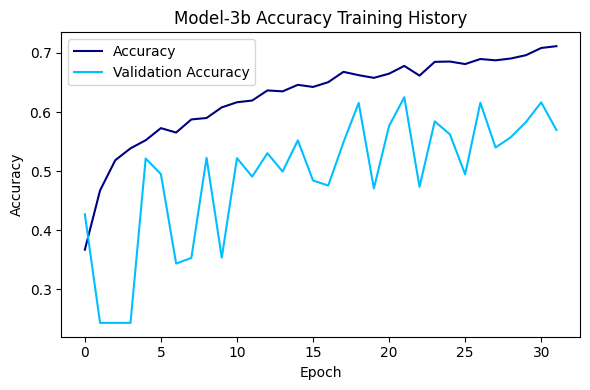

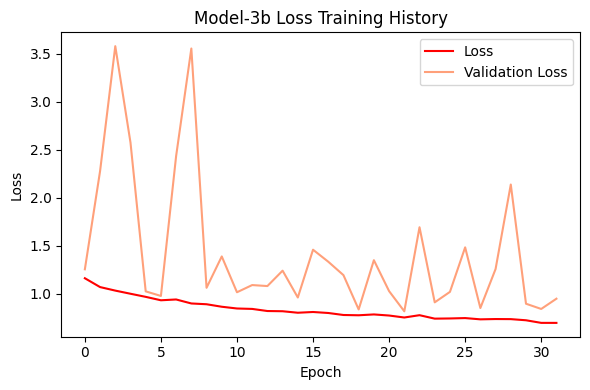

In [57]:
## Save model data
save_model_data(model_3, history_3)

# Plot training history
plot_training(model_3, history_3)

2022-10-06 13:20:21.216150: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


734/734 [==============================] - 11s 12ms/step
Train:
              precision    recall  f1-score   support

      Spiral       0.90      0.57      0.70     10017
  Elliptical       0.38      0.95      0.55      5705
      Merger       0.78      0.30      0.43      7765

    accuracy                           0.57     23487
   macro avg       0.69      0.61      0.56     23487
weighted avg       0.73      0.57      0.57     23487


734/734 [==============================] - 9s 11ms/step


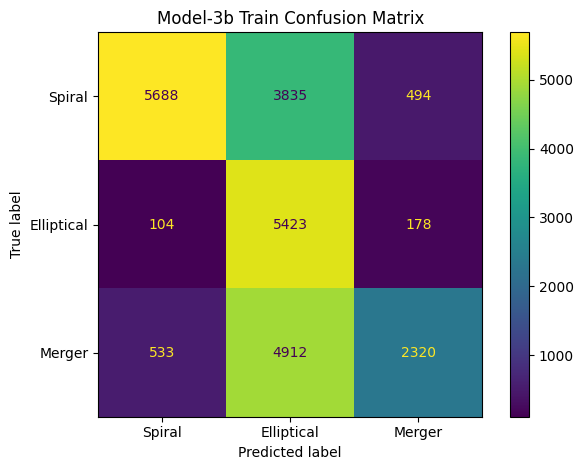

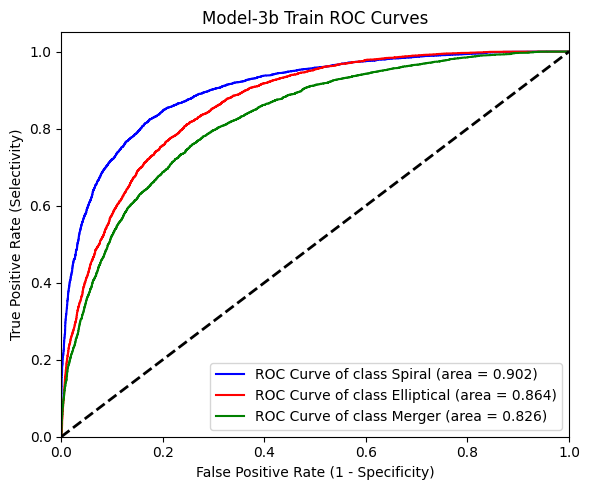

In [58]:
# Make Classification report, Confusion Matrix, and compute ROC & AUC for each class in each dataset
y_pred = model_3.predict(X_train_10)
        
# Classification report
classification_metrics = make_classification_report(
    np.argmax(Y_train, axis=1), 
    np.argmax(y_pred, axis=1)
    )
print("Train:\n" + classification_metrics + '\n')

# Confusion Matrix
cd = make_cm(model_3, 
              np.argmax(Y_train, axis=1), 
              np.argmax(model_3.predict(X_train_10), axis=1)
              )
cd.plot(values_format='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title(f'{model_3.name} Train Confusion Matrix')
plt.tight_layout()
plt.savefig(f'{model_3.name}_train_CM')
plt.show()

## ROC curves & AUC for a categorical classifier
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], thresholds = roc_curve(Y_train[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize = (6, 5), tight_layout=True)
colors = ['blue', 'red', 'green', 'brown', 'purple', 'pink', 'orange', 'black', 'yellow', 'cyan']
for i, color, lbl in zip(range(NUM_CLASSES), colors, class_names):
    plt.plot(fpr[i], tpr[i], color = color, lw = 1.5,
    label = 'ROC Curve of class {0} (area = {1:0.3f})'.format(lbl, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Selectivity)')
plt.legend(loc="lower right")
plt.title(f'{model_3.name} Train ROC Curves')
plt.savefig(f'{model_3.name}_train_ROC')
plt.show()

210/210 [==============================] - 2s 11ms/step
Test:
              precision    recall  f1-score   support

      Spiral       0.88      0.54      0.67      2863
  Elliptical       0.37      0.94      0.53      1631
      Merger       0.73      0.27      0.39      2221

    accuracy                           0.55      6715
   macro avg       0.66      0.58      0.53      6715
weighted avg       0.71      0.55      0.55      6715


210/210 [==============================] - 2s 12ms/step


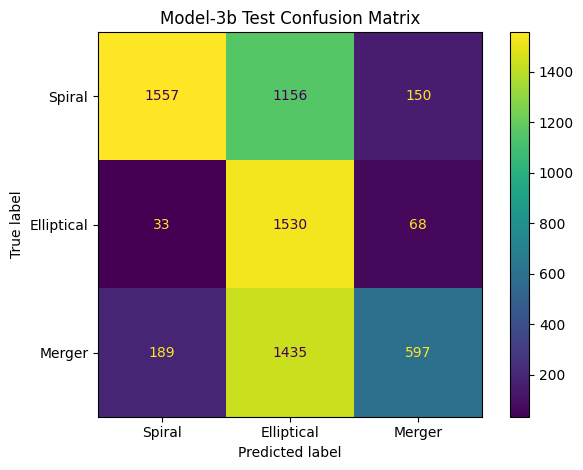

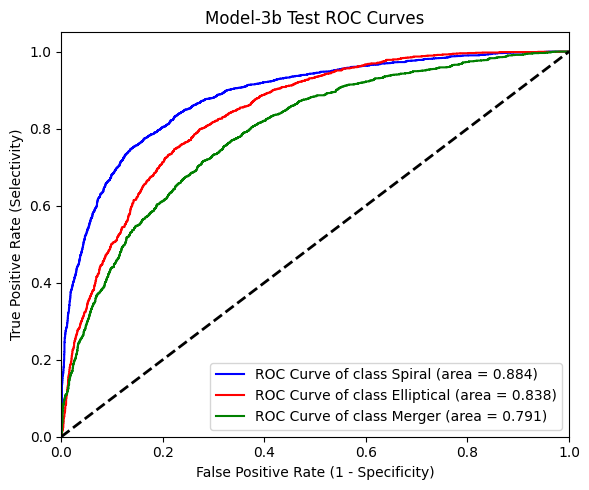

In [60]:
# Make Classification report, Confusion Matrix, and compute ROC & AUC for each class in each dataset
y_pred = model_3.predict(X_test_10)
        
# Classification report
classification_metrics = make_classification_report(
    np.argmax(Y_test, axis=1), 
    np.argmax(y_pred, axis=1)
    )
print("Test:\n" + classification_metrics + '\n')

# Confusion Matrix
cd = make_cm(model_3, 
              np.argmax(Y_test, axis=1), 
              np.argmax(model_3.predict(X_test_10), axis=1)
              )
cd.plot(values_format='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title(f'{model_3.name} Test Confusion Matrix')
plt.tight_layout()
plt.savefig(f'{model_3.name}_test_CM')
plt.show()

## ROC curves & AUC for a categorical classifier
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], thresholds = roc_curve(Y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize = (6, 5), tight_layout=True)
colors = ['blue', 'red', 'green', 'brown', 'purple', 'pink', 'orange', 'black', 'yellow', 'cyan']
for i, color, lbl in zip(range(NUM_CLASSES), colors, class_names):
    plt.plot(fpr[i], tpr[i], color = color, lw = 1.5,
    label = 'ROC Curve of class {0} (area = {1:0.3f})'.format(lbl, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Selectivity)')
plt.legend(loc="lower right")
plt.title(f'{model_3.name} Test ROC Curves')
plt.savefig(f'{model_3.name}_test_ROC')
plt.show()

105/105 [==============================] - 1s 11ms/step
Validation:
              precision    recall  f1-score   support

      Spiral       0.88      0.57      0.69      1432
  Elliptical       0.38      0.93      0.54       815
      Merger       0.73      0.30      0.43      1108

    accuracy                           0.57      3355
   macro avg       0.67      0.60      0.56      3355
weighted avg       0.71      0.57      0.57      3355


105/105 [==============================] - 1s 11ms/step


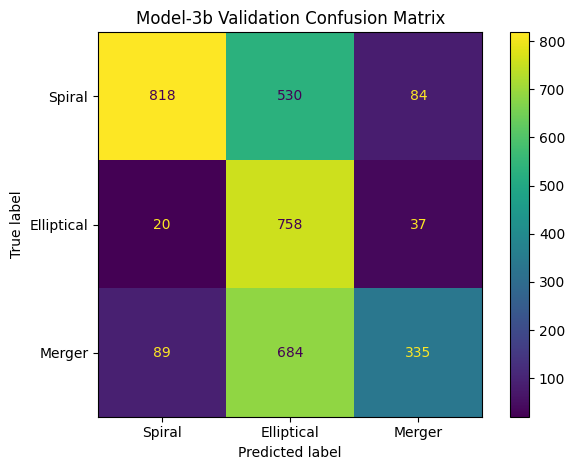

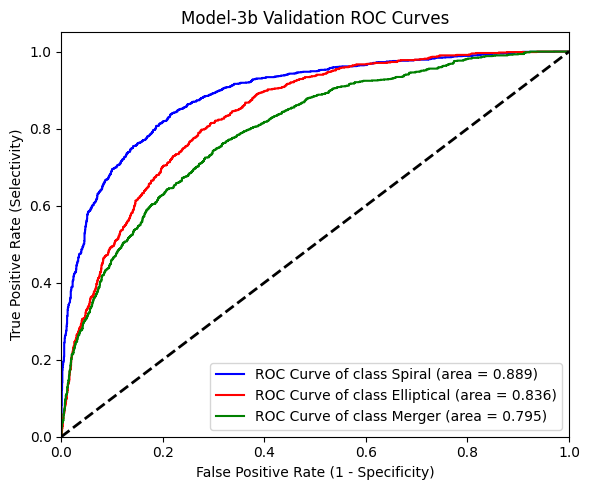

In [61]:
# Make Classification report, Confusion Matrix, and compute ROC & AUC for each class in each dataset
y_pred = model_3.predict(X_valid_10)
        
# Classification report
classification_metrics = make_classification_report(
    np.argmax(Y_valid, axis=1), 
    np.argmax(y_pred, axis=1)
    )
print("Validation:\n" + classification_metrics + '\n')

# Confusion Matrix
cd = make_cm(model_3, 
              np.argmax(Y_valid, axis=1), 
              np.argmax(model_3.predict(X_valid_10), axis=1)
              )
cd.plot(values_format='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title(f'{model_3.name} Validation Confusion Matrix')
plt.tight_layout()
plt.savefig(f'{model_3.name}_validation_CM')
plt.show()

## ROC curves & AUC for a categorical classifier
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], thresholds = roc_curve(Y_valid[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize = (6, 5), tight_layout=True)
colors = ['blue', 'red', 'green', 'brown', 'purple', 'pink', 'orange', 'black', 'yellow', 'cyan']
for i, color, lbl in zip(range(NUM_CLASSES), colors, class_names):
    plt.plot(fpr[i], tpr[i], color = color, lw = 1.5,
    label = 'ROC Curve of class {0} (area = {1:0.3f})'.format(lbl, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Selectivity)')
plt.legend(loc="lower right")
plt.title(f'{model_3.name} Validation ROC Curves')
plt.savefig(f'{model_3.name}_validation_ROC')
plt.show()

In [ ]:
# Make Classification report, Confusion Matrix, and compute ROC & AUC for each class in each dataset
y_pred = model_3.predict(X_test_1)
        
# Classification report
classification_metrics = make_classification_report(
    np.argmax(Y_test, axis=1), 
    np.argmax(y_pred, axis=1)
    )
print("Year 1 Test:\n" + classification_metrics + '\n')

### ResNet18b Model

Use ResNet18 architecture

Loss: Categorical Cross-entropy

Optimizer: Adam

Uses Image Augmentation: False

Change: use ResNet18 model

In [17]:
# Set seed for reproducibility
random.seed(0)

# Alternate way of setting up ResNet
class ResnetBlock(Model):
    """
    A standard resnet block.
    """

    def __init__(self, channels: int, down_sample=False):
        """
        channels: same as number of convolution kernels
        """
        super().__init__()

        self.__channels = channels
        self.__down_sample = down_sample
        self.__strides = [2, 1] if down_sample else [1, 1]

        KERNEL_SIZE = (3, 3)
        # use He initialization, instead of Xavier (a.k.a 'glorot_uniform' in Keras), as suggested in [2]
        INIT_SCHEME = "he_normal"

        self.conv_1 = Conv2D(self.__channels, strides=self.__strides[0], data_format='channels_first',
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_1 = BatchNormalization()
        self.conv_2 = Conv2D(self.__channels, strides=self.__strides[1], data_format='channels_first',
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_2 = BatchNormalization()
        self.merge = Add()

        if self.__down_sample:
            # perform down sampling using stride of 2, according to [1].
            self.res_conv = Conv2D(self.__channels, strides=2, kernel_size=(1, 1), data_format='channels_first',
                                   kernel_initializer=INIT_SCHEME, padding="same")
            self.res_bn = BatchNormalization()

    def call(self, inputs):
        res = inputs

        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)

        if self.__down_sample:
            res = self.res_conv(res)
            res = self.res_bn(res)

        # if not perform down sample, then add a shortcut directly
        x = self.merge([x, res])
        out = tf.nn.relu(x)
        return out


class ResNet18(Model):

    def __init__(self, num_classes, **kwargs):
        """
            num_classes: number of classes in specific classification task.
        """
        super().__init__(**kwargs)
        self.conv_1 = Conv2D(64, (7, 7), strides=2, data_format='channels_first',
                             padding="same", kernel_initializer="he_normal")
        self.init_bn = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=(2, 2), data_format='channels_first', strides=2, padding="same")
        self.res_1_1 = ResnetBlock(64)
        self.res_1_2 = ResnetBlock(64)
        self.res_2_1 = ResnetBlock(128, down_sample=True)
        self.res_2_2 = ResnetBlock(128)
        self.res_3_1 = ResnetBlock(256, down_sample=True)
        self.res_3_2 = ResnetBlock(256)
        self.res_4_1 = ResnetBlock(512, down_sample=True)
        self.res_4_2 = ResnetBlock(512)
        self.dout = Dropout(0.5)
        self.avg_pool = GlobalAveragePooling2D(data_format='channels_first')
        self.flat = Flatten()
        self.fc = Dense(num_classes, activation="softmax")

    def call(self, inputs):
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        out = self.pool_2(out)
        for res_block in [self.res_1_1, self.res_1_2, self.res_2_1, self.res_2_2, 
                          self.res_3_1, self.res_3_2, self.res_4_1, self.res_4_2
                          ]:
            out = res_block(out)
        out = self.dout(out)
        out = self.avg_pool(out)
        out = self.flat(out)
        out = self.fc(out)
        return out

In [18]:
# Initialize ResNet-18 model
resnet18b_model_alt_dropout = ResNet18(NUM_CLASSES)
resnet18b_model_alt_dropout.build(input_shape = (None, 3, 100, 100))

## Compile Model
loss = CategoricalCrossentropy(from_logits=True)
optimizer = Adam(1e-6) 
resnet18b_model_alt_dropout.compile(loss = loss, optimizer = optimizer, metrics = ['accuracy'])
resnet18b_model_alt_dropout.summary()

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-10-27 12:32:16.359908: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-27 12:32:16.361557: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "res_net18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  9472      
                                                                 
 batch_normalization (BatchN  multiple                 200       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 resnet_block (ResnetBlock)  multiple          

In [20]:
## Define Callback Functions

# Add tensorboard callback and log output folder
log_dir = "Y10_logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

es = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10), 
      ModelCheckpoint(filepath='Y10_resnet18_best_weights', monitor='val_accuracy', 
                      mode='max', verbose=1, save_best_only=True),
      tensorboard_callback
      ]

In [21]:
## Train Model
# Set seed for reproducibility
random.seed(0)

batch_size = 128
NUM_EPOCH = 200
history_resnet18b = resnet18_model.fit(X_train_10, Y_train,
                                    batch_size = batch_size,
                                    epochs = NUM_EPOCH,
                                    validation_data = (X_valid_10, Y_valid),                
                                    shuffle = True,
                                    class_weight = class_weights,
                                    verbose = 1,
                                    callbacks = es
                                    )

Epoch 1/200


2022-10-27 12:35:19.541014: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-27 12:35:21.311258: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


184/184 [==============================] - ETA: 0s - loss: 1.1235 - accuracy: 0.3594

2022-10-27 12:37:38.182163: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.46796, saving model to Y10_resnet18_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


184/184 [==============================] - 151s 795ms/step - loss: 1.1235 - accuracy: 0.3594 - val_loss: 1.0665 - val_accuracy: 0.4680
Epoch 2/200
184/184 [==============================] - ETA: 0s - loss: 1.0836 - accuracy: 0.4039
Epoch 2: val_accuracy did not improve from 0.46796
184/184 [==============================] - 136s 738ms/step - loss: 1.0836 - accuracy: 0.4039 - val_loss: 1.1149 - val_accuracy: 0.3490
Epoch 3/200
184/184 [==============================] - ETA: 0s - loss: 1.0664 - accuracy: 0.4314
Epoch 3: val_accuracy improved from 0.46796 to 0.48227, saving model to Y10_resnet18_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


184/184 [==============================] - 144s 780ms/step - loss: 1.0664 - accuracy: 0.4314 - val_loss: 1.0397 - val_accuracy: 0.4823
Epoch 4/200
184/184 [==============================] - ETA: 0s - loss: 1.0267 - accuracy: 0.4892
Epoch 4: val_accuracy improved from 0.48227 to 0.51714, saving model to Y10_resnet18_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


184/184 [==============================] - 145s 787ms/step - loss: 1.0267 - accuracy: 0.4892 - val_loss: 1.0183 - val_accuracy: 0.5171
Epoch 5/200
184/184 [==============================] - ETA: 0s - loss: 0.9849 - accuracy: 0.5149
Epoch 5: val_accuracy improved from 0.51714 to 0.55320, saving model to Y10_resnet18_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


184/184 [==============================] - 153s 832ms/step - loss: 0.9849 - accuracy: 0.5149 - val_loss: 0.9370 - val_accuracy: 0.5532
Epoch 6/200
184/184 [==============================] - ETA: 0s - loss: 0.9484 - accuracy: 0.5354
Epoch 6: val_accuracy improved from 0.55320 to 0.55768, saving model to Y10_resnet18_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


184/184 [==============================] - 153s 831ms/step - loss: 0.9484 - accuracy: 0.5354 - val_loss: 0.9039 - val_accuracy: 0.5577
Epoch 7/200
184/184 [==============================] - ETA: 0s - loss: 0.9158 - accuracy: 0.5615
Epoch 7: val_accuracy improved from 0.55768 to 0.59285, saving model to Y10_resnet18_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


184/184 [==============================] - 154s 838ms/step - loss: 0.9158 - accuracy: 0.5615 - val_loss: 0.8631 - val_accuracy: 0.5928
Epoch 8/200
184/184 [==============================] - ETA: 0s - loss: 0.8705 - accuracy: 0.5902
Epoch 8: val_accuracy improved from 0.59285 to 0.59940, saving model to Y10_resnet18_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


184/184 [==============================] - 149s 811ms/step - loss: 0.8705 - accuracy: 0.5902 - val_loss: 0.8808 - val_accuracy: 0.5994
Epoch 9/200
184/184 [==============================] - ETA: 0s - loss: 0.8461 - accuracy: 0.6051
Epoch 9: val_accuracy did not improve from 0.59940
184/184 [==============================] - 135s 733ms/step - loss: 0.8461 - accuracy: 0.6051 - val_loss: 0.8952 - val_accuracy: 0.5645
Epoch 10/200
184/184 [==============================] - ETA: 0s - loss: 0.8193 - accuracy: 0.6232
Epoch 10: val_accuracy improved from 0.59940 to 0.63428, saving model to Y10_resnet18_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


184/184 [==============================] - 144s 784ms/step - loss: 0.8193 - accuracy: 0.6232 - val_loss: 0.7863 - val_accuracy: 0.6343
Epoch 11/200
184/184 [==============================] - ETA: 0s - loss: 0.7870 - accuracy: 0.6430
Epoch 11: val_accuracy did not improve from 0.63428
184/184 [==============================] - 136s 737ms/step - loss: 0.7870 - accuracy: 0.6430 - val_loss: 0.7889 - val_accuracy: 0.6322
Epoch 12/200
184/184 [==============================] - ETA: 0s - loss: 0.7629 - accuracy: 0.6559
Epoch 12: val_accuracy did not improve from 0.63428
184/184 [==============================] - 134s 728ms/step - loss: 0.7629 - accuracy: 0.6559 - val_loss: 0.8313 - val_accuracy: 0.6316
Epoch 13/200
184/184 [==============================] - ETA: 0s - loss: 0.7585 - accuracy: 0.6571
Epoch 13: val_accuracy improved from 0.63428 to 0.66379, saving model to Y10_resnet18_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


184/184 [==============================] - 141s 768ms/step - loss: 0.7585 - accuracy: 0.6571 - val_loss: 0.7402 - val_accuracy: 0.6638
Epoch 14/200
184/184 [==============================] - ETA: 0s - loss: 0.7246 - accuracy: 0.6761
Epoch 14: val_accuracy improved from 0.66379 to 0.69031, saving model to Y10_resnet18_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


184/184 [==============================] - 142s 774ms/step - loss: 0.7246 - accuracy: 0.6761 - val_loss: 0.7166 - val_accuracy: 0.6903
Epoch 15/200
184/184 [==============================] - ETA: 0s - loss: 0.7113 - accuracy: 0.6857
Epoch 15: val_accuracy did not improve from 0.69031
184/184 [==============================] - 134s 726ms/step - loss: 0.7113 - accuracy: 0.6857 - val_loss: 0.7347 - val_accuracy: 0.6775
Epoch 16/200
184/184 [==============================] - ETA: 0s - loss: 0.6955 - accuracy: 0.6954
Epoch 16: val_accuracy did not improve from 0.69031
184/184 [==============================] - 134s 729ms/step - loss: 0.6955 - accuracy: 0.6954 - val_loss: 0.7145 - val_accuracy: 0.6781
Epoch 17/200
184/184 [==============================] - ETA: 0s - loss: 0.6935 - accuracy: 0.6940
Epoch 17: val_accuracy did not improve from 0.69031
184/184 [==============================] - 133s 724ms/step - loss: 0.6935 - accuracy: 0.6940 - val_loss: 0.7092 - val_accuracy: 0.6838
Epoch 18/2

INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


184/184 [==============================] - 141s 769ms/step - loss: 0.6756 - accuracy: 0.7063 - val_loss: 0.6864 - val_accuracy: 0.6948
Epoch 19/200
184/184 [==============================] - ETA: 0s - loss: 0.6599 - accuracy: 0.7138
Epoch 19: val_accuracy did not improve from 0.69478
184/184 [==============================] - 135s 733ms/step - loss: 0.6599 - accuracy: 0.7138 - val_loss: 0.6921 - val_accuracy: 0.6885
Epoch 20/200
184/184 [==============================] - ETA: 0s - loss: 0.6496 - accuracy: 0.7207
Epoch 20: val_accuracy improved from 0.69478 to 0.71088, saving model to Y10_resnet18_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


184/184 [==============================] - 141s 768ms/step - loss: 0.6496 - accuracy: 0.7207 - val_loss: 0.6730 - val_accuracy: 0.7109
Epoch 21/200
184/184 [==============================] - ETA: 0s - loss: 0.6402 - accuracy: 0.7213
Epoch 21: val_accuracy did not improve from 0.71088
184/184 [==============================] - 134s 725ms/step - loss: 0.6402 - accuracy: 0.7213 - val_loss: 0.7568 - val_accuracy: 0.6581
Epoch 22/200
184/184 [==============================] - ETA: 0s - loss: 0.6209 - accuracy: 0.7343
Epoch 22: val_accuracy improved from 0.71088 to 0.71177, saving model to Y10_resnet18_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


184/184 [==============================] - 141s 765ms/step - loss: 0.6209 - accuracy: 0.7343 - val_loss: 0.6563 - val_accuracy: 0.7118
Epoch 23/200
184/184 [==============================] - ETA: 0s - loss: 0.6200 - accuracy: 0.7320
Epoch 23: val_accuracy did not improve from 0.71177
184/184 [==============================] - 133s 725ms/step - loss: 0.6200 - accuracy: 0.7320 - val_loss: 0.6419 - val_accuracy: 0.7088
Epoch 24/200
184/184 [==============================] - ETA: 0s - loss: 0.6055 - accuracy: 0.7407
Epoch 24: val_accuracy did not improve from 0.71177
184/184 [==============================] - 134s 728ms/step - loss: 0.6055 - accuracy: 0.7407 - val_loss: 0.6693 - val_accuracy: 0.6930
Epoch 25/200
184/184 [==============================] - ETA: 0s - loss: 0.6035 - accuracy: 0.7410
Epoch 25: val_accuracy improved from 0.71177 to 0.73353, saving model to Y10_resnet18_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


184/184 [==============================] - 142s 772ms/step - loss: 0.6035 - accuracy: 0.7410 - val_loss: 0.6191 - val_accuracy: 0.7335
Epoch 26/200
184/184 [==============================] - ETA: 0s - loss: 0.5705 - accuracy: 0.7587
Epoch 26: val_accuracy did not improve from 0.73353
184/184 [==============================] - 135s 733ms/step - loss: 0.5705 - accuracy: 0.7587 - val_loss: 0.6419 - val_accuracy: 0.7261
Epoch 27/200
184/184 [==============================] - ETA: 0s - loss: 0.5693 - accuracy: 0.7592
Epoch 27: val_accuracy did not improve from 0.73353
184/184 [==============================] - 134s 727ms/step - loss: 0.5693 - accuracy: 0.7592 - val_loss: 0.6118 - val_accuracy: 0.7332
Epoch 28/200
184/184 [==============================] - ETA: 0s - loss: 0.5697 - accuracy: 0.7582
Epoch 28: val_accuracy did not improve from 0.73353
184/184 [==============================] - 133s 725ms/step - loss: 0.5697 - accuracy: 0.7582 - val_loss: 0.6626 - val_accuracy: 0.7159
Epoch 29/2

INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


184/184 [==============================] - 143s 777ms/step - loss: 0.5269 - accuracy: 0.7790 - val_loss: 0.5760 - val_accuracy: 0.7610
Epoch 33/200
184/184 [==============================] - ETA: 0s - loss: 0.5088 - accuracy: 0.7883
Epoch 33: val_accuracy did not improve from 0.76095
184/184 [==============================] - 135s 736ms/step - loss: 0.5088 - accuracy: 0.7883 - val_loss: 0.5880 - val_accuracy: 0.7452
Epoch 34/200
184/184 [==============================] - ETA: 0s - loss: 0.5135 - accuracy: 0.7855
Epoch 34: val_accuracy did not improve from 0.76095
184/184 [==============================] - 135s 734ms/step - loss: 0.5135 - accuracy: 0.7855 - val_loss: 0.6117 - val_accuracy: 0.7461
Epoch 35/200
184/184 [==============================] - ETA: 0s - loss: 0.4939 - accuracy: 0.7946
Epoch 35: val_accuracy did not improve from 0.76095
184/184 [==============================] - 136s 741ms/step - loss: 0.4939 - accuracy: 0.7946 - val_loss: 0.7218 - val_accuracy: 0.6909
Epoch 36/2

INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


184/184 [==============================] - 147s 799ms/step - loss: 0.4605 - accuracy: 0.8115 - val_loss: 0.5598 - val_accuracy: 0.7660
Epoch 39/200
184/184 [==============================] - ETA: 0s - loss: 0.4594 - accuracy: 0.8099
Epoch 39: val_accuracy did not improve from 0.76602
184/184 [==============================] - 142s 770ms/step - loss: 0.4594 - accuracy: 0.8099 - val_loss: 0.7260 - val_accuracy: 0.6930
Epoch 40/200
184/184 [==============================] - ETA: 0s - loss: 0.4583 - accuracy: 0.8135
Epoch 40: val_accuracy did not improve from 0.76602
184/184 [==============================] - 139s 755ms/step - loss: 0.4583 - accuracy: 0.8135 - val_loss: 0.5601 - val_accuracy: 0.7618
Epoch 41/200
184/184 [==============================] - ETA: 0s - loss: 0.4300 - accuracy: 0.8266
Epoch 41: val_accuracy did not improve from 0.76602
184/184 [==============================] - 140s 760ms/step - loss: 0.4300 - accuracy: 0.8266 - val_loss: 0.6000 - val_accuracy: 0.7458
Epoch 42/2

INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


184/184 [==============================] - 144s 785ms/step - loss: 0.4218 - accuracy: 0.8294 - val_loss: 0.5540 - val_accuracy: 0.7744
Epoch 44/200
184/184 [==============================] - ETA: 0s - loss: 0.4233 - accuracy: 0.8268
Epoch 44: val_accuracy did not improve from 0.77437
184/184 [==============================] - 136s 741ms/step - loss: 0.4233 - accuracy: 0.8268 - val_loss: 0.5484 - val_accuracy: 0.7672
Epoch 45/200
184/184 [==============================] - ETA: 0s - loss: 0.4005 - accuracy: 0.8396
Epoch 45: val_accuracy improved from 0.77437 to 0.77526, saving model to Y10_resnet18_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


184/184 [==============================] - 145s 786ms/step - loss: 0.4005 - accuracy: 0.8396 - val_loss: 0.5417 - val_accuracy: 0.7753
Epoch 46/200
184/184 [==============================] - ETA: 0s - loss: 0.4061 - accuracy: 0.8361
Epoch 46: val_accuracy did not improve from 0.77526
184/184 [==============================] - 137s 747ms/step - loss: 0.4061 - accuracy: 0.8361 - val_loss: 0.5885 - val_accuracy: 0.7541
Epoch 47/200
184/184 [==============================] - ETA: 0s - loss: 0.3888 - accuracy: 0.8441
Epoch 47: val_accuracy did not improve from 0.77526
184/184 [==============================] - 140s 758ms/step - loss: 0.3888 - accuracy: 0.8441 - val_loss: 0.5672 - val_accuracy: 0.7735
Epoch 48/200
184/184 [==============================] - ETA: 0s - loss: 0.3929 - accuracy: 0.8419
Epoch 48: val_accuracy did not improve from 0.77526
184/184 [==============================] - 139s 757ms/step - loss: 0.3929 - accuracy: 0.8419 - val_loss: 0.6141 - val_accuracy: 0.7478
Epoch 49/2

INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


184/184 [==============================] - 146s 796ms/step - loss: 0.3729 - accuracy: 0.8518 - val_loss: 0.5364 - val_accuracy: 0.7839
Epoch 50/200
184/184 [==============================] - ETA: 0s - loss: 0.3742 - accuracy: 0.8492
Epoch 50: val_accuracy improved from 0.78390 to 0.78957, saving model to Y10_resnet18_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


184/184 [==============================] - 147s 800ms/step - loss: 0.3742 - accuracy: 0.8492 - val_loss: 0.5291 - val_accuracy: 0.7896
Epoch 51/200
184/184 [==============================] - ETA: 0s - loss: 0.3614 - accuracy: 0.8587
Epoch 51: val_accuracy did not improve from 0.78957
184/184 [==============================] - 139s 756ms/step - loss: 0.3614 - accuracy: 0.8587 - val_loss: 0.5915 - val_accuracy: 0.7613
Epoch 52/200
184/184 [==============================] - ETA: 0s - loss: 0.3551 - accuracy: 0.8597
Epoch 52: val_accuracy did not improve from 0.78957
184/184 [==============================] - 139s 757ms/step - loss: 0.3551 - accuracy: 0.8597 - val_loss: 0.6082 - val_accuracy: 0.7627
Epoch 53/200
184/184 [==============================] - ETA: 0s - loss: 0.3449 - accuracy: 0.8647
Epoch 53: val_accuracy improved from 0.78957 to 0.79225, saving model to Y10_resnet18_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


184/184 [==============================] - 148s 806ms/step - loss: 0.3449 - accuracy: 0.8647 - val_loss: 0.5244 - val_accuracy: 0.7923
Epoch 54/200
184/184 [==============================] - ETA: 0s - loss: 0.3409 - accuracy: 0.8650
Epoch 54: val_accuracy did not improve from 0.79225
184/184 [==============================] - 138s 752ms/step - loss: 0.3409 - accuracy: 0.8650 - val_loss: 0.5799 - val_accuracy: 0.7651
Epoch 55/200
184/184 [==============================] - ETA: 0s - loss: 0.3133 - accuracy: 0.8784
Epoch 55: val_accuracy improved from 0.79225 to 0.80328, saving model to Y10_resnet18_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


184/184 [==============================] - 146s 796ms/step - loss: 0.3133 - accuracy: 0.8784 - val_loss: 0.5116 - val_accuracy: 0.8033
Epoch 56/200
184/184 [==============================] - ETA: 0s - loss: 0.3238 - accuracy: 0.8738
Epoch 56: val_accuracy improved from 0.80328 to 0.81371, saving model to Y10_resnet18_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


184/184 [==============================] - 148s 804ms/step - loss: 0.3238 - accuracy: 0.8738 - val_loss: 0.4852 - val_accuracy: 0.8137
Epoch 57/200
184/184 [==============================] - ETA: 0s - loss: 0.3138 - accuracy: 0.8774
Epoch 57: val_accuracy did not improve from 0.81371
184/184 [==============================] - 139s 755ms/step - loss: 0.3138 - accuracy: 0.8774 - val_loss: 0.5287 - val_accuracy: 0.7946
Epoch 58/200
184/184 [==============================] - ETA: 0s - loss: 0.3112 - accuracy: 0.8779
Epoch 58: val_accuracy did not improve from 0.81371
184/184 [==============================] - 139s 757ms/step - loss: 0.3112 - accuracy: 0.8779 - val_loss: 0.5733 - val_accuracy: 0.7845
Epoch 59/200
184/184 [==============================] - ETA: 0s - loss: 0.3117 - accuracy: 0.8790
Epoch 59: val_accuracy did not improve from 0.81371
184/184 [==============================] - 141s 767ms/step - loss: 0.3117 - accuracy: 0.8790 - val_loss: 0.6151 - val_accuracy: 0.7651
Epoch 60/2

INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


184/184 [==============================] - 144s 781ms/step - loss: 0.2814 - accuracy: 0.8899 - val_loss: 0.4861 - val_accuracy: 0.8188
Epoch 62/200
184/184 [==============================] - ETA: 0s - loss: 0.2787 - accuracy: 0.8935
Epoch 62: val_accuracy did not improve from 0.81878
184/184 [==============================] - 136s 738ms/step - loss: 0.2787 - accuracy: 0.8935 - val_loss: 0.5049 - val_accuracy: 0.8113
Epoch 63/200
184/184 [==============================] - ETA: 0s - loss: 0.2757 - accuracy: 0.8939
Epoch 63: val_accuracy did not improve from 0.81878
184/184 [==============================] - 136s 741ms/step - loss: 0.2757 - accuracy: 0.8939 - val_loss: 0.5333 - val_accuracy: 0.7976
Epoch 64/200
184/184 [==============================] - ETA: 0s - loss: 0.2775 - accuracy: 0.8915
Epoch 64: val_accuracy did not improve from 0.81878
184/184 [==============================] - 136s 741ms/step - loss: 0.2775 - accuracy: 0.8915 - val_loss: 0.4900 - val_accuracy: 0.8182
Epoch 65/2

INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


184/184 [==============================] - 144s 781ms/step - loss: 0.2580 - accuracy: 0.9011 - val_loss: 0.4787 - val_accuracy: 0.8265
Epoch 67/200
184/184 [==============================] - ETA: 0s - loss: 0.2453 - accuracy: 0.9079
Epoch 67: val_accuracy did not improve from 0.82653
184/184 [==============================] - 135s 736ms/step - loss: 0.2453 - accuracy: 0.9079 - val_loss: 0.4852 - val_accuracy: 0.8218
Epoch 68/200
184/184 [==============================] - ETA: 0s - loss: 0.2542 - accuracy: 0.9028
Epoch 68: val_accuracy did not improve from 0.82653
184/184 [==============================] - 137s 744ms/step - loss: 0.2542 - accuracy: 0.9028 - val_loss: 0.5096 - val_accuracy: 0.8152
Epoch 69/200
184/184 [==============================] - ETA: 0s - loss: 0.2551 - accuracy: 0.8999
Epoch 69: val_accuracy did not improve from 0.82653
184/184 [==============================] - 136s 737ms/step - loss: 0.2551 - accuracy: 0.8999 - val_loss: 0.5754 - val_accuracy: 0.7964
Epoch 70/2

In [ ]:
%tensorboard --logdir Y10_logs

INFO:tensorflow:Assets written to: ResNet18-Y10/assets


INFO:tensorflow:Assets written to: ResNet18-Y10/assets


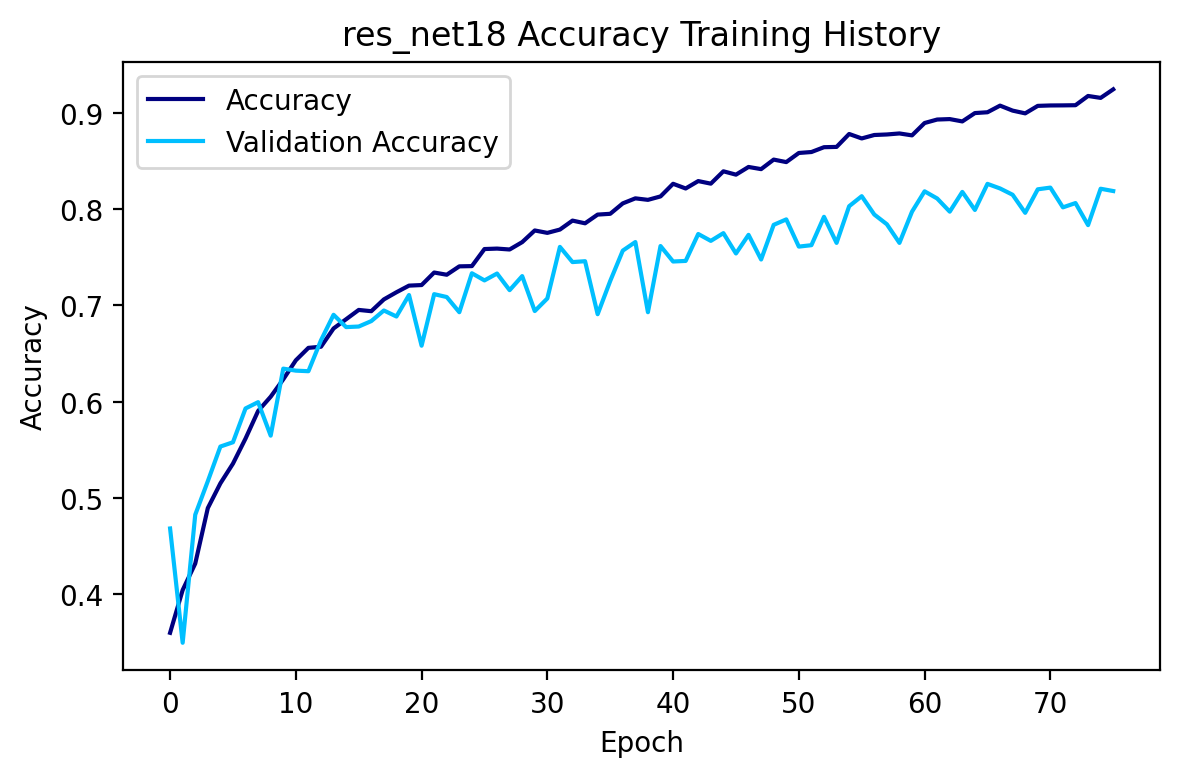

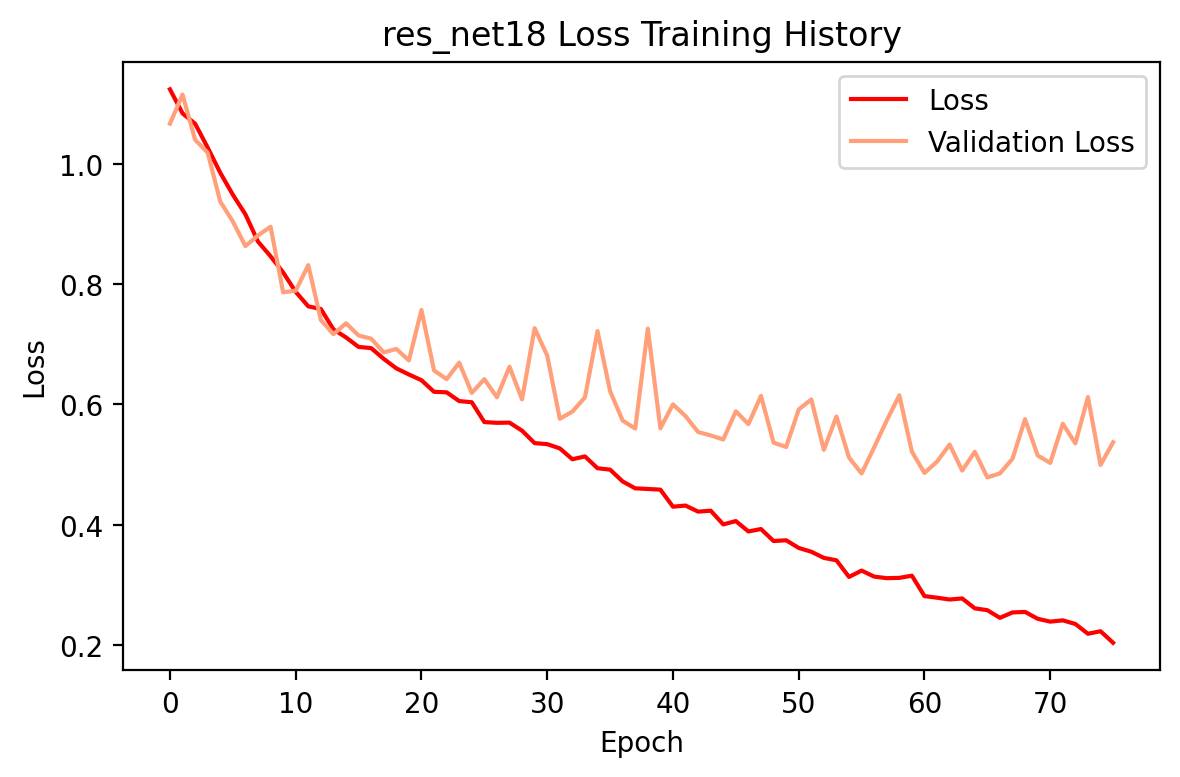

In [23]:
# Save model data
resnet18_model.save(filepath = 'ResNet18-Y10',
           include_optimizer = True, 
           overwrite = True)
    
# Saving history as .npy file for future use
np.save('history_resnet18b.npy', history_resnet18b.history)

# Plot training history
plot_training(resnet18_model, history_resnet18b)

2022-10-27 16:59:13.928682: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


734/734 [==============================] - 27s 36ms/step
Train:
              precision    recall  f1-score   support

      Spiral       0.96      0.92      0.94     10017
  Elliptical       0.82      0.98      0.89      5705
      Merger       0.97      0.89      0.93      7765

    accuracy                           0.93     23487
   macro avg       0.92      0.93      0.92     23487
weighted avg       0.93      0.93      0.93     23487


734/734 [==============================] - 35s 45ms/step


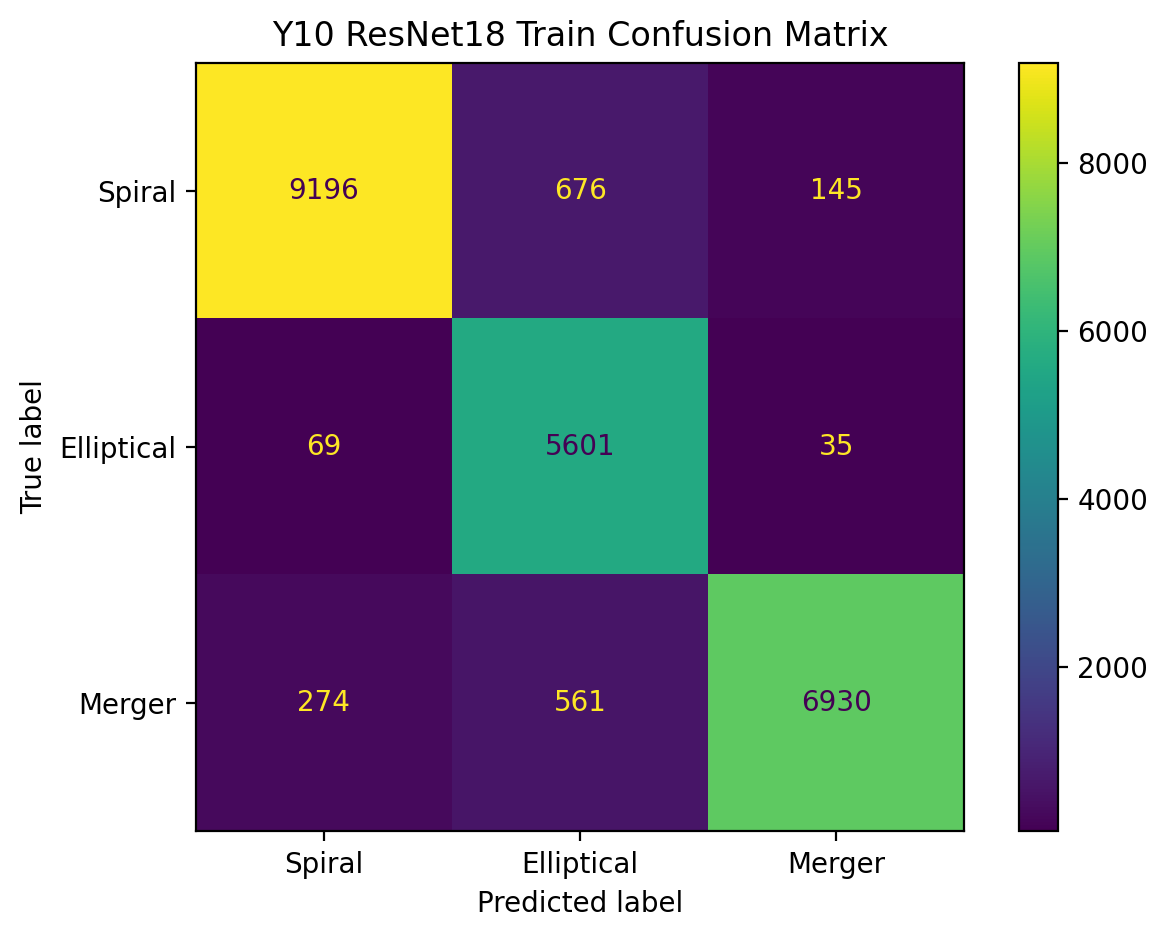

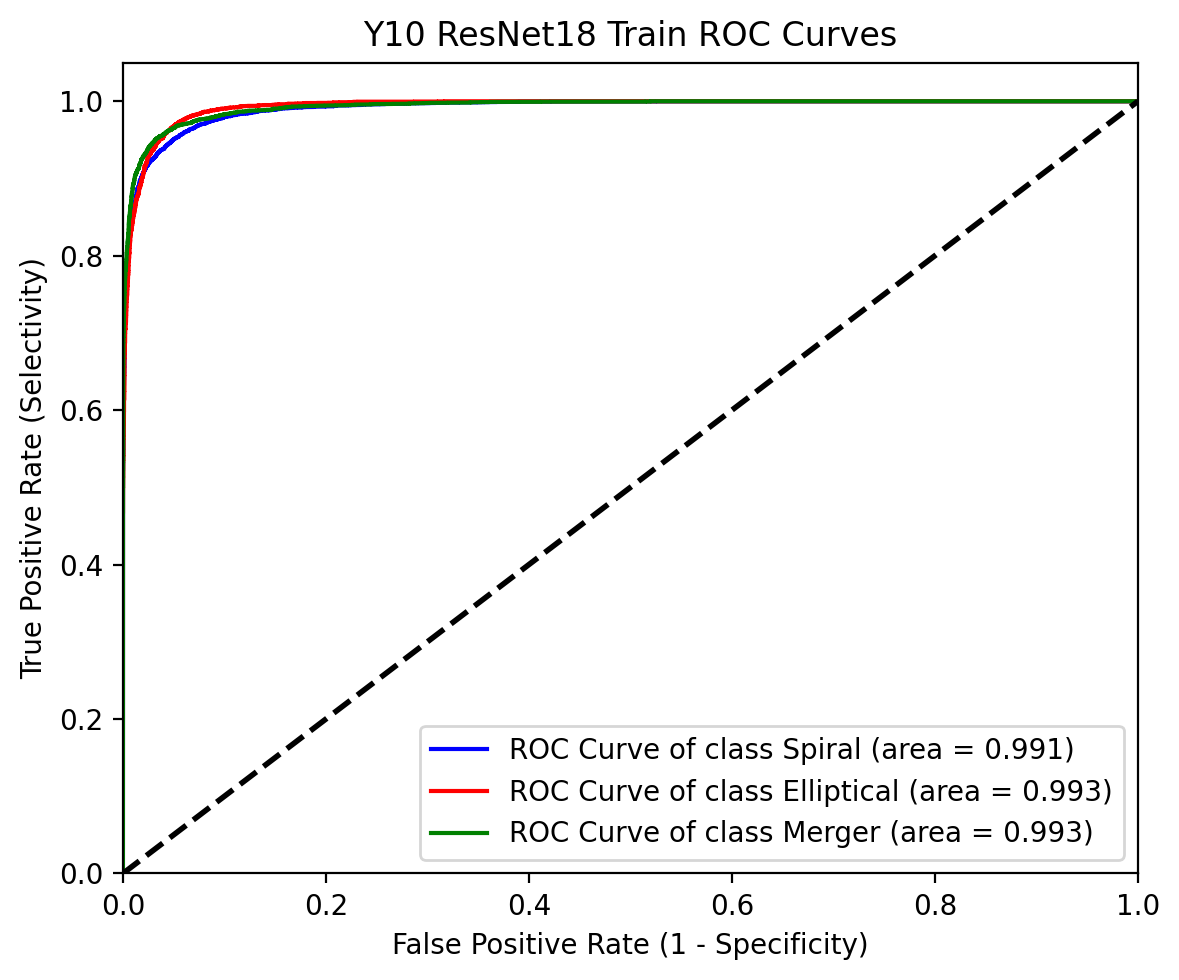

In [25]:
# Make Classification report, Confusion Matrix, and compute ROC & AUC for each class in each dataset
y_pred = resnet18_model.predict(X_train_10)
        
# Classification report
classification_metrics = classification_report(np.argmax(Y_train, axis=1), 
                                               np.argmax(y_pred, axis=1), 
                                               target_names=class_names)
print("Train:\n" + classification_metrics + '\n')

# Confusion Matrix
cm = confusion_matrix(np.argmax(Y_train, axis=1), 
                      np.argmax(resnet18_model.predict(X_train_10), axis=1),
                      labels=[0, 1, 2])
cm = cm.astype('float')
cd = ConfusionMatrixDisplay(cm, display_labels=class_names)
cd.plot(values_format='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Y10 ResNet18 Train Confusion Matrix')
plt.tight_layout()
plt.savefig('Y10_ResNet18_train_CM')
plt.show()

## ROC curves & AUC for a categorical classifier
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], thresholds = roc_curve(Y_train[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize = (6, 5), tight_layout=True)
colors = ['blue', 'red', 'green', 'brown', 'purple', 'pink', 'orange', 'black', 'yellow', 'cyan']
for i, color, lbl in zip(range(NUM_CLASSES), colors, class_names):
    plt.plot(fpr[i], tpr[i], color = color, lw = 1.5,
    label = 'ROC Curve of class {0} (area = {1:0.3f})'.format(lbl, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Selectivity)')
plt.legend(loc="lower right")
plt.title('Y10 ResNet18 Train ROC Curves')
plt.savefig('Y10_ResNet18_train_ROC')
plt.show()

210/210 [==============================] - 9s 42ms/step
Train:
              precision    recall  f1-score   support

      Spiral       0.88      0.84      0.86      2863
  Elliptical       0.67      0.87      0.76      1631
      Merger       0.86      0.72      0.78      2221

    accuracy                           0.81      6715
   macro avg       0.80      0.81      0.80      6715
weighted avg       0.82      0.81      0.81      6715


210/210 [==============================] - 7s 33ms/step


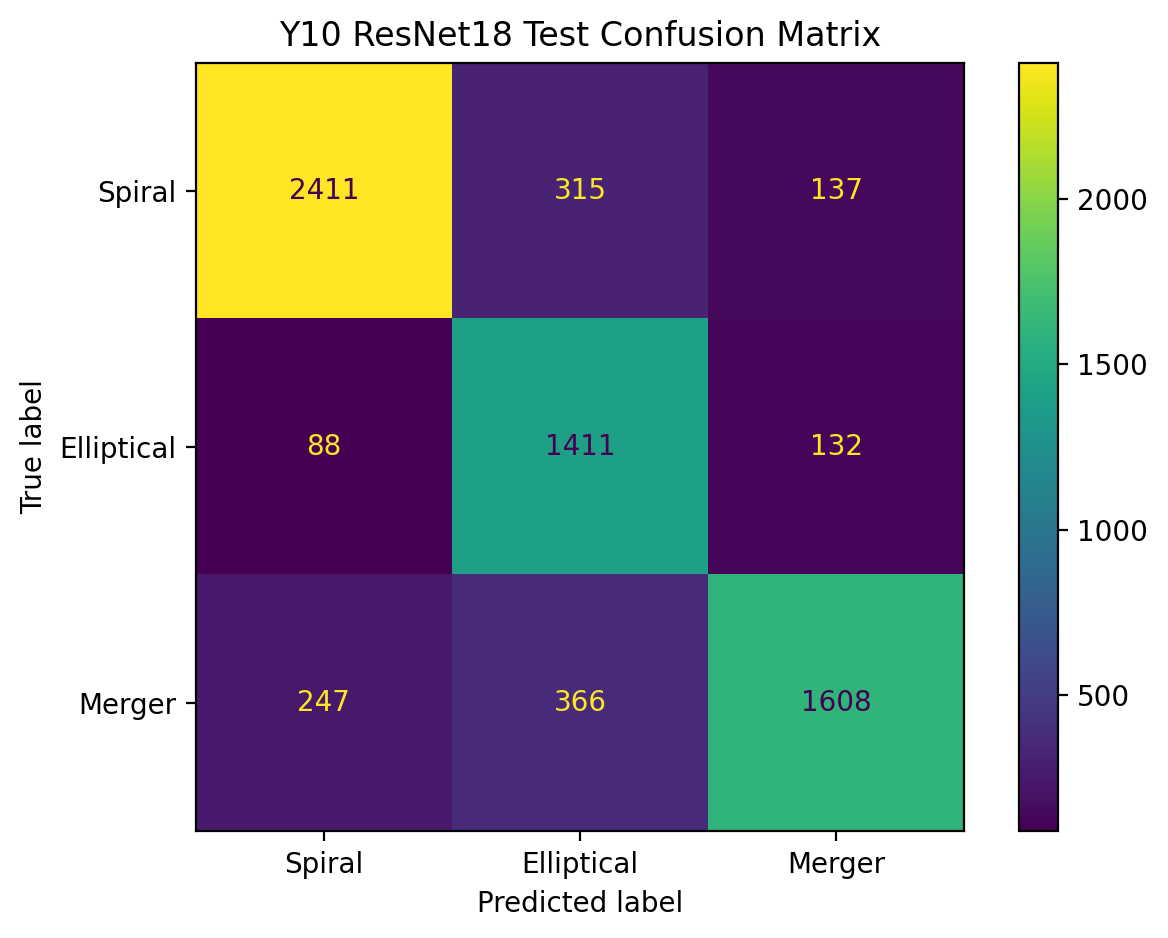

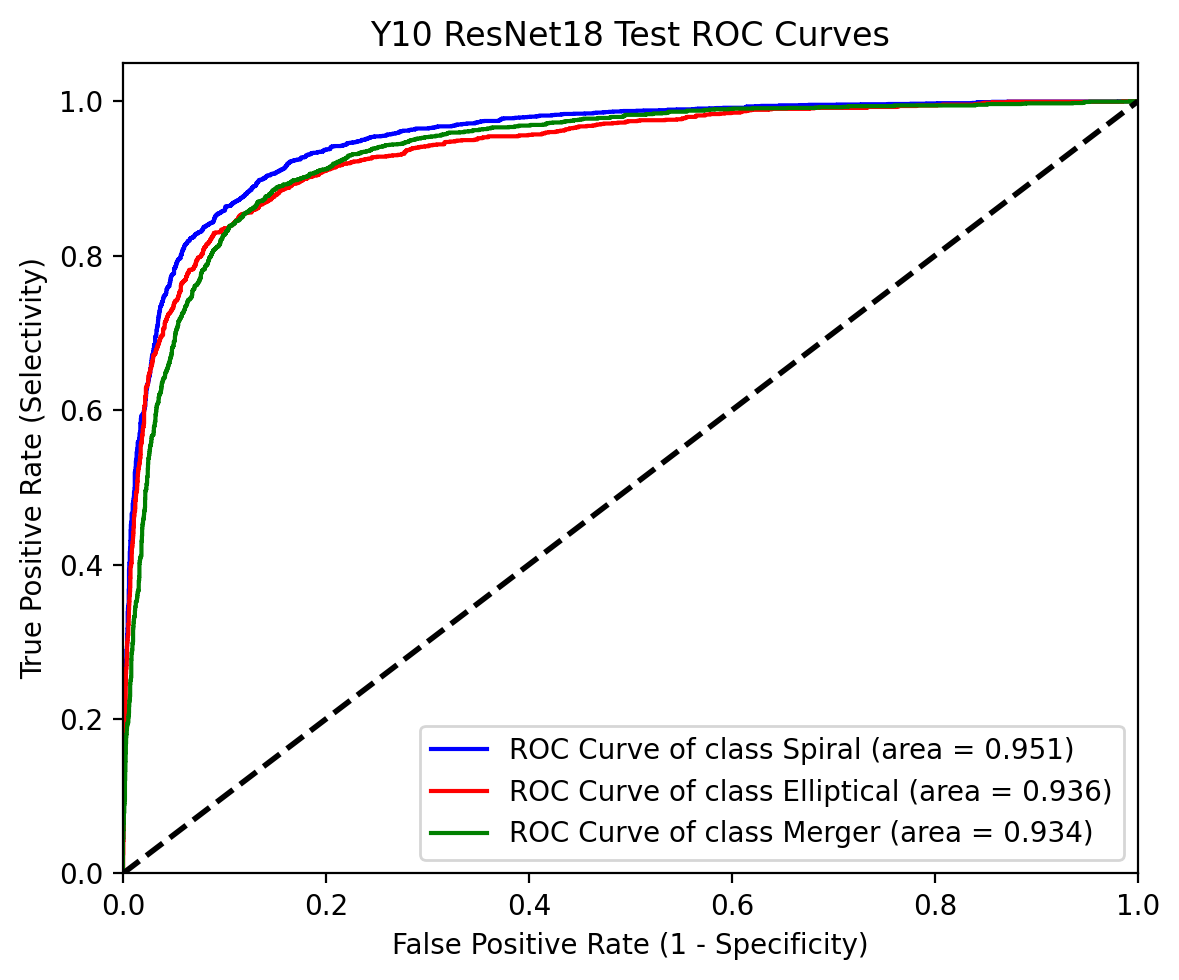

In [26]:
# Make Classification report, Confusion Matrix, and compute ROC & AUC for each class in each dataset
y_pred = resnet18_model.predict(X_test_10)
        
# Classification report
classification_metrics = classification_report(np.argmax(Y_test, axis=1), 
                                               np.argmax(y_pred, axis=1), 
                                               target_names=class_names)
print("Test:\n" + classification_metrics + '\n')

# Confusion Matrix
cm = confusion_matrix(np.argmax(Y_test, axis=1), 
                      np.argmax(resnet18_model.predict(X_test_10), axis=1),
                      labels=[0, 1, 2])
cm = cm.astype('float')
cd = ConfusionMatrixDisplay(cm, display_labels=class_names)
cd.plot(values_format='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Y10 ResNet18 Test Confusion Matrix')
plt.tight_layout()
plt.savefig('Y10_ResNet18_test_CM')
plt.show()

## ROC curves & AUC for a categorical classifier
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], thresholds = roc_curve(Y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize = (6, 5), tight_layout=True)
colors = ['blue', 'red', 'green', 'brown', 'purple', 'pink', 'orange', 'black', 'yellow', 'cyan']
for i, color, lbl in zip(range(NUM_CLASSES), colors, class_names):
    plt.plot(fpr[i], tpr[i], color = color, lw = 1.5,
    label = 'ROC Curve of class {0} (area = {1:0.3f})'.format(lbl, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Selectivity)')
plt.legend(loc="lower right")
plt.title('Y10 ResNet18 Test ROC Curves')
plt.savefig('Y10_ResNet18_test_ROC')
plt.show()

105/105 [==============================] - 4s 38ms/step
Train:
              precision    recall  f1-score   support

      Spiral       0.89      0.85      0.87      1432
  Elliptical       0.68      0.87      0.76       815
      Merger       0.86      0.75      0.80      1108

    accuracy                           0.82      3355
   macro avg       0.81      0.82      0.81      3355
weighted avg       0.83      0.82      0.82      3355


105/105 [==============================] - 5s 46ms/step


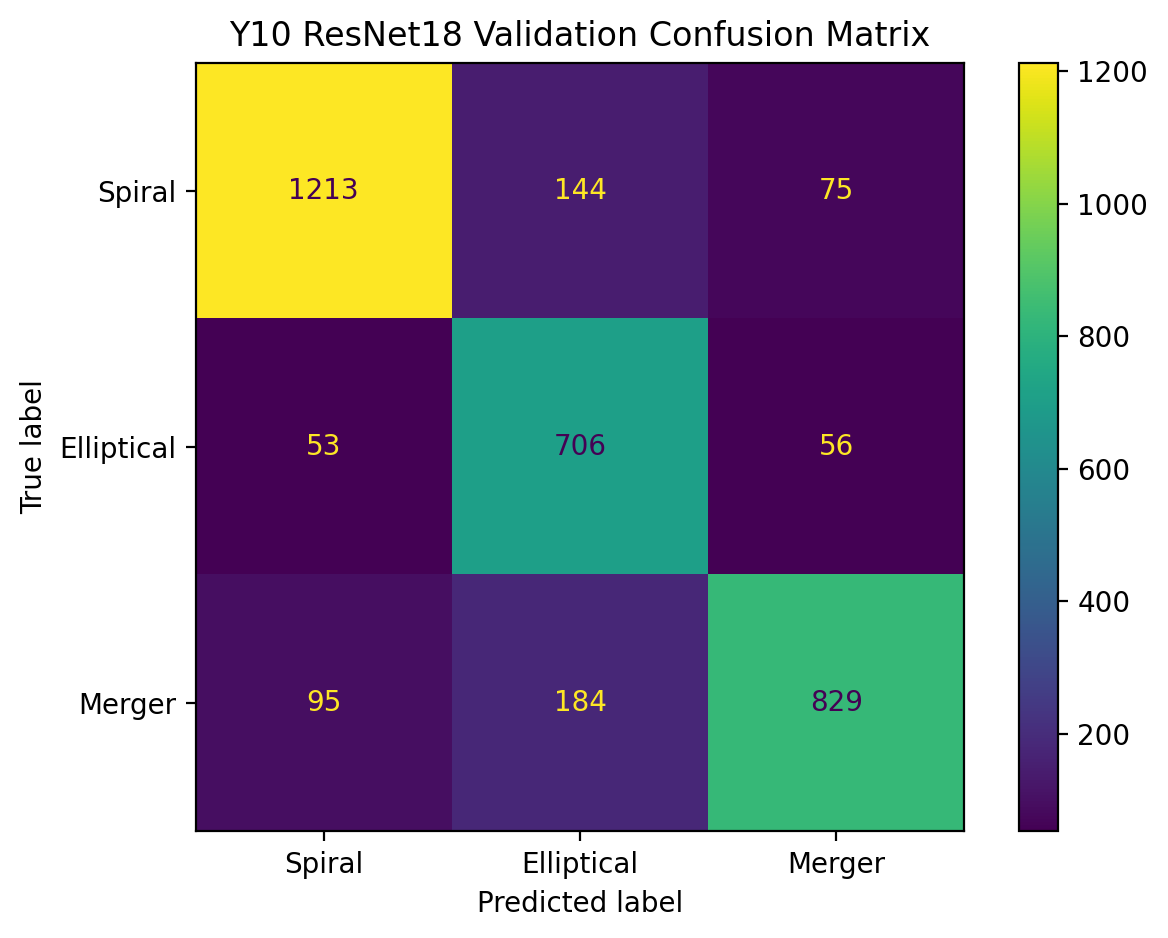

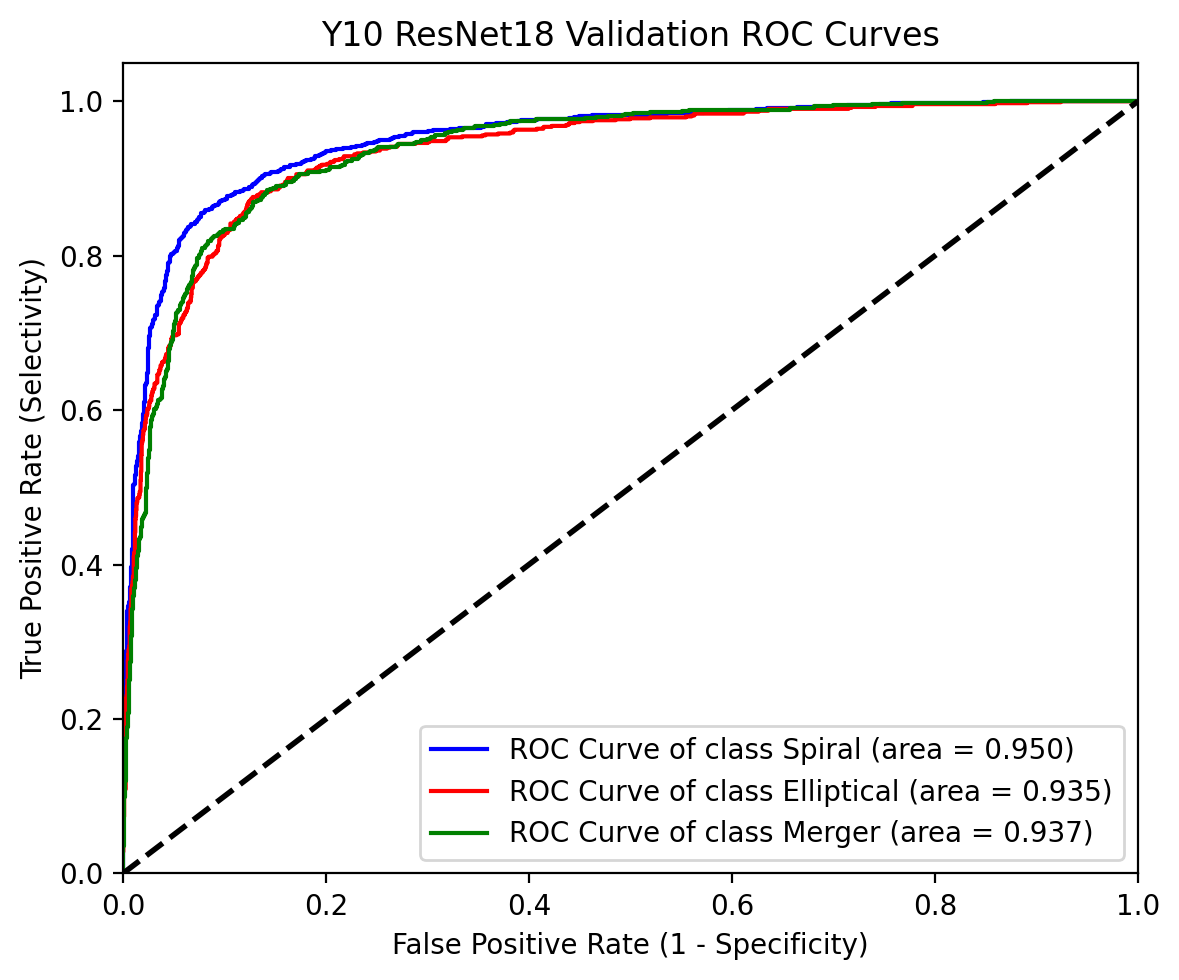

In [29]:
# Make Classification report, Confusion Matrix, and compute ROC & AUC for each class in each dataset
y_pred = resnet18_model.predict(X_valid_10)
        
# Classification report
classification_metrics = classification_report(np.argmax(Y_valid, axis=1), 
                                               np.argmax(y_pred, axis=1), 
                                               target_names=class_names)
print("Validation:\n" + classification_metrics + '\n')

# Confusion Matrix
cm = confusion_matrix(np.argmax(Y_valid, axis=1), 
                      np.argmax(resnet18_model.predict(X_valid_10), axis=1),
                      labels=[0, 1, 2])
cm = cm.astype('float')
cd = ConfusionMatrixDisplay(cm, display_labels=class_names)
cd.plot(values_format='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Y10 ResNet18 Validation Confusion Matrix')
plt.tight_layout()
plt.savefig('Y10_ResNet18_valid_CM')
plt.show()

## ROC curves & AUC for a categorical classifier
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], thresholds = roc_curve(Y_valid[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize = (6, 5), tight_layout=True)
colors = ['blue', 'red', 'green', 'brown', 'purple', 'pink', 'orange', 'black', 'yellow', 'cyan']
for i, color, lbl in zip(range(NUM_CLASSES), colors, class_names):
    plt.plot(fpr[i], tpr[i], color = color, lw = 1.5,
    label = 'ROC Curve of class {0} (area = {1:0.3f})'.format(lbl, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Selectivity)')
plt.legend(loc="lower right")
plt.title('Y10 ResNet18 Validation ROC Curves')
plt.savefig('Y10_ResNet18_validation_ROC')
plt.show()

In [28]:
# Make Classification report
y_pred = resnet18_model.predict(X_test_1)
        
# Classification report
classification_metrics = classification_report(np.argmax(Y_test, axis=1), 
                                               np.argmax(y_pred, axis=1), 
                                               target_names=class_names)
print("Year 1 Test:\n" + classification_metrics + '\n')

210/210 [==============================] - 9s 41ms/step
Year 1 Test:
              precision    recall  f1-score   support

      Spiral       0.80      0.58      0.67      2863
  Elliptical       0.52      0.26      0.34      1631
      Merger       0.48      0.82      0.61      2221

    accuracy                           0.58      6715
   macro avg       0.60      0.55      0.54      6715
weighted avg       0.63      0.58      0.57      6715




## ResNet18 with Dropout 0.5

In [12]:
# Set seed for reproducibility
random.seed(0)

def conv3x3(x, out_planes, stride=1, name=None):
    x = ZeroPadding2D(padding=1, name=f'{name}_pad')(x)
    return Conv2D(filters=out_planes, kernel_size=3, 
                  strides=stride, use_bias=False, name=name)(x)

# Residual block
def basic_block(x, planes, stride=1, downsample=None, name=None):
    # Original input
    identity = x

    # First convolutional layer per block
    out = conv3x3(x, planes, stride=stride, name=f'{name}.conv1')
    out = BatchNormalization(name=f'{name}.bn1')(out)
    out = Activation('relu', name=f'{name}.relu1')(out)

    # Second convolutional layer per block
    out = conv3x3(out, planes, name=f'{name}.conv2')
    out = BatchNormalization(name=f'{name}.bn2')(out)

    if downsample is not None:
        for layer in downsample:
            identity = layer(identity)

    out = Add(name=f'{name}.add')([identity, out])
    out = Activation('relu', name=f'{name}.relu2')(out)

    return out

def make_layer(x, planes, blocks, stride=1, name=None):
    downsample = None
    inplanes = x.shape[3]
    # Do downsample if stride not 1
    if stride != 1 or inplanes != planes:
        # Use kernel size 1, stride 2 for convolutional layers in residual blocks 2 and after
        downsample = [
            Conv2D(filters=planes, kernel_size=1, strides=stride, 
                   use_bias=False, name=f'{name}.0.downsample.0'),
            BatchNormalization(name=f'{name}.0.downsample.1'),
        ]
    # Create residual block; blocks 2 and after will have downsample
    x = basic_block(x, planes, stride, downsample, name=f'{name}.0')
    
    # Create 2 residual blocks per module
    for i in range(1, blocks):
        x = basic_block(x, planes, name=f'{name}.{i}')

    return x

def resnet(x, blocks_per_layer, num_classes=NUM_CLASSES):
    # First convolutional layer is 7x7 with 64 output channels and stride 2, then Max-pooling layer with stride 2
    x = ZeroPadding2D(padding=3, name='conv1_pad')(x)
    x = Conv2D(filters=64, kernel_size=7, strides=2, use_bias=False, name='conv1')(x)
    x = BatchNormalization(name='bn1')(x)
    x = Activation('relu', name='relu1')(x)
    x = ZeroPadding2D(padding=1, name='maxpool_pad')(x)
    x = MaxPool2D(pool_size=3, strides=2, name='maxpool')(x)

    # ResNet18 uses two residual blocks for each module (filter size) here, 4 convolutional layers per module
    # First 2 blocks use stride 1
    x = make_layer(x, 64, blocks_per_layer[0], name='layer1')
    # All layers after this use stride 2
    x = make_layer(x, 128, blocks_per_layer[1], stride=2, name='layer2')
    x = make_layer(x, 256, blocks_per_layer[2], stride=2, name='layer3')
    x = make_layer(x, 512, blocks_per_layer[3], stride=2, name='layer4')

    # Final layers
    x = Dropout(0.5)(x)
    x = GlobalAveragePooling2D(name='avgpool')(x)
    outputs = Dense(units=num_classes, activation = "softmax", name='fc')(x)

    return outputs

def resnet18(x, **kwargs):
    return resnet(x, [2, 2, 2, 2], **kwargs)

In [11]:
# Initialize ResNet-18 model
inputs = Input(shape = (3, 100, 100))
outputs = resnet18(inputs)
Y10_resnet18_model_dropout = Model(inputs, outputs)

## Compile Model
loss = CategoricalCrossentropy(from_logits=True)
optimizer = Adam(learning_rate = 1e-6)
Y10_resnet18_model_dropout.compile(loss = loss, optimizer = optimizer, metrics = ['accuracy'])
Y10_resnet18_model_dropout.summary()

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-01-08 05:15:09.738924: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-08 05:15:09.740423: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 3, 100, 100  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 9, 106, 100)  0           ['input_1[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 2, 50, 64)    313600      ['conv1_pad[0][0]']              
                                                                                                  
 bn1 (BatchNormalization)       (None, 2, 50, 64)    256         ['conv1[0][0]']              

In [13]:
# Visualize and save model architecture plot with Visualkeras
font = ImageFont.truetype("FreeMono.ttf", 30)
visualkeras.layered_view(Y10_resnet18_model_dropout, legend = True, 
                         font = font,
                         type_ignore = [ZeroPadding2D, Dropout],
                         background_fill = 'white',
                         padding = 15,
                         to_file = 'Y10_ResNet18_Dropout_ZPad.png').show()

In [15]:
## Define Callback Functions

# Add tensorboard callback and log output folder
log_dir = "Y10_logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + f" {Y10_resnet18_model_dropout.name}"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

es = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5), 
      ModelCheckpoint(filepath='Y10_resnet18_dropout_best_weights', monitor='val_accuracy', 
                      mode='max', verbose=1, save_best_only=True),
      tensorboard_callback
      ]

In [16]:
# Set seed for reproducibility
random.seed(0)

## Train Model
batch_size = 128
NUM_EPOCH = 200
history_resnet18b = Y10_resnet18_model_dropout.fit(X_train_10, Y_train,
                                                    batch_size = batch_size,
                                                    epochs = NUM_EPOCH,
                                                    validation_data = (X_valid_10, Y_valid),                
                                                    shuffle = True,
                                                    class_weight = class_weights,
                                                    verbose = 1,
                                                    callbacks = es
                                                    )

Epoch 1/300


2023-01-08 09:51:58.886373: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-08 09:52:00.141520: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


184/184 [==============================] - ETA: 0s - loss: 1.3602 - accuracy: 0.3674

2023-01-08 09:52:29.317027: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.24292, saving model to Y10_resnet18_dropout_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_best_weights/assets


184/184 [==============================] - 39s 202ms/step - loss: 1.3602 - accuracy: 0.3674 - val_loss: 1.3254 - val_accuracy: 0.2429
Epoch 2/300
184/184 [==============================] - ETA: 0s - loss: 1.2123 - accuracy: 0.4380
Epoch 2: val_accuracy improved from 0.24292 to 0.29508, saving model to Y10_resnet18_dropout_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_best_weights/assets


184/184 [==============================] - 34s 185ms/step - loss: 1.2123 - accuracy: 0.4380 - val_loss: 1.5387 - val_accuracy: 0.2951
Epoch 3/300
184/184 [==============================] - ETA: 0s - loss: 1.1620 - accuracy: 0.4654
Epoch 3: val_accuracy improved from 0.29508 to 0.32519, saving model to Y10_resnet18_dropout_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_best_weights/assets


184/184 [==============================] - 36s 193ms/step - loss: 1.1620 - accuracy: 0.4654 - val_loss: 1.6061 - val_accuracy: 0.3252
Epoch 4/300
184/184 [==============================] - ETA: 0s - loss: 1.1111 - accuracy: 0.4928
Epoch 4: val_accuracy improved from 0.32519 to 0.51088, saving model to Y10_resnet18_dropout_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_best_weights/assets


184/184 [==============================] - 35s 188ms/step - loss: 1.1111 - accuracy: 0.4928 - val_loss: 1.0108 - val_accuracy: 0.5109
Epoch 5/300
184/184 [==============================] - ETA: 0s - loss: 1.0750 - accuracy: 0.5060
Epoch 5: val_accuracy did not improve from 0.51088
184/184 [==============================] - 28s 153ms/step - loss: 1.0750 - accuracy: 0.5060 - val_loss: 1.1184 - val_accuracy: 0.4468
Epoch 6/300
184/184 [==============================] - ETA: 0s - loss: 1.0536 - accuracy: 0.5161
Epoch 6: val_accuracy did not improve from 0.51088
184/184 [==============================] - 28s 152ms/step - loss: 1.0536 - accuracy: 0.5161 - val_loss: 1.0748 - val_accuracy: 0.4587
Epoch 7/300
184/184 [==============================] - ETA: 0s - loss: 1.0219 - accuracy: 0.5363
Epoch 7: val_accuracy did not improve from 0.51088
184/184 [==============================] - 28s 150ms/step - loss: 1.0219 - accuracy: 0.5363 - val_loss: 1.1154 - val_accuracy: 0.4498
Epoch 8/300
184/184 

INFO:tensorflow:Assets written to: Y10_resnet18_dropout_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_best_weights/assets


184/184 [==============================] - 34s 187ms/step - loss: 0.9986 - accuracy: 0.5441 - val_loss: 0.9754 - val_accuracy: 0.5300
Epoch 9/300
184/184 [==============================] - ETA: 0s - loss: 0.9839 - accuracy: 0.5465
Epoch 9: val_accuracy improved from 0.52996 to 0.54456, saving model to Y10_resnet18_dropout_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_best_weights/assets


184/184 [==============================] - 35s 188ms/step - loss: 0.9839 - accuracy: 0.5465 - val_loss: 0.9690 - val_accuracy: 0.5446
Epoch 10/300
184/184 [==============================] - ETA: 0s - loss: 0.9591 - accuracy: 0.5613
Epoch 10: val_accuracy did not improve from 0.54456
184/184 [==============================] - 28s 150ms/step - loss: 0.9591 - accuracy: 0.5613 - val_loss: 1.1132 - val_accuracy: 0.4542
Epoch 11/300
184/184 [==============================] - ETA: 0s - loss: 0.9408 - accuracy: 0.5728
Epoch 11: val_accuracy did not improve from 0.54456
184/184 [==============================] - 28s 149ms/step - loss: 0.9408 - accuracy: 0.5728 - val_loss: 1.0987 - val_accuracy: 0.4712
Epoch 12/300
184/184 [==============================] - ETA: 0s - loss: 0.9192 - accuracy: 0.5841
Epoch 12: val_accuracy improved from 0.54456 to 0.57943, saving model to Y10_resnet18_dropout_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_best_weights/assets


184/184 [==============================] - 34s 186ms/step - loss: 0.9192 - accuracy: 0.5841 - val_loss: 0.9218 - val_accuracy: 0.5794
Epoch 13/300
184/184 [==============================] - ETA: 0s - loss: 0.9109 - accuracy: 0.5873
Epoch 13: val_accuracy did not improve from 0.57943
184/184 [==============================] - 28s 151ms/step - loss: 0.9109 - accuracy: 0.5873 - val_loss: 1.0701 - val_accuracy: 0.4817
Epoch 14/300
184/184 [==============================] - ETA: 0s - loss: 0.8955 - accuracy: 0.5938
Epoch 14: val_accuracy did not improve from 0.57943
184/184 [==============================] - 28s 151ms/step - loss: 0.8955 - accuracy: 0.5938 - val_loss: 1.0258 - val_accuracy: 0.5094
Epoch 15/300
184/184 [==============================] - ETA: 0s - loss: 0.8833 - accuracy: 0.5984
Epoch 15: val_accuracy improved from 0.57943 to 0.58480, saving model to Y10_resnet18_dropout_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_best_weights/assets


184/184 [==============================] - 34s 186ms/step - loss: 0.8833 - accuracy: 0.5984 - val_loss: 0.8943 - val_accuracy: 0.5848
Epoch 16/300
184/184 [==============================] - ETA: 0s - loss: 0.8687 - accuracy: 0.6060
Epoch 16: val_accuracy did not improve from 0.58480
184/184 [==============================] - 28s 152ms/step - loss: 0.8687 - accuracy: 0.6060 - val_loss: 0.9231 - val_accuracy: 0.5768
Epoch 17/300
184/184 [==============================] - ETA: 0s - loss: 0.8565 - accuracy: 0.6116
Epoch 17: val_accuracy did not improve from 0.58480
184/184 [==============================] - 28s 150ms/step - loss: 0.8565 - accuracy: 0.6116 - val_loss: 0.9486 - val_accuracy: 0.5562
Epoch 18/300
184/184 [==============================] - ETA: 0s - loss: 0.8415 - accuracy: 0.6212
Epoch 18: val_accuracy improved from 0.58480 to 0.60298, saving model to Y10_resnet18_dropout_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_best_weights/assets


184/184 [==============================] - 35s 188ms/step - loss: 0.8415 - accuracy: 0.6212 - val_loss: 0.8817 - val_accuracy: 0.6030
Epoch 19/300
184/184 [==============================] - ETA: 0s - loss: 0.8349 - accuracy: 0.6239
Epoch 19: val_accuracy did not improve from 0.60298
184/184 [==============================] - 28s 154ms/step - loss: 0.8349 - accuracy: 0.6239 - val_loss: 0.9840 - val_accuracy: 0.5216
Epoch 20/300
184/184 [==============================] - ETA: 0s - loss: 0.8243 - accuracy: 0.6299
Epoch 20: val_accuracy did not improve from 0.60298
184/184 [==============================] - 27s 149ms/step - loss: 0.8243 - accuracy: 0.6299 - val_loss: 0.8764 - val_accuracy: 0.6015
Epoch 21/300
184/184 [==============================] - ETA: 0s - loss: 0.8038 - accuracy: 0.6393
Epoch 21: val_accuracy did not improve from 0.60298
184/184 [==============================] - 28s 150ms/step - loss: 0.8038 - accuracy: 0.6393 - val_loss: 1.0632 - val_accuracy: 0.4817
Epoch 22/300
1

In [ ]:
%tensorboard --logdir logs/fit

INFO:tensorflow:Assets written to: Y10_ResNet18_Dropout/assets


INFO:tensorflow:Assets written to: Y10_ResNet18_Dropout/assets


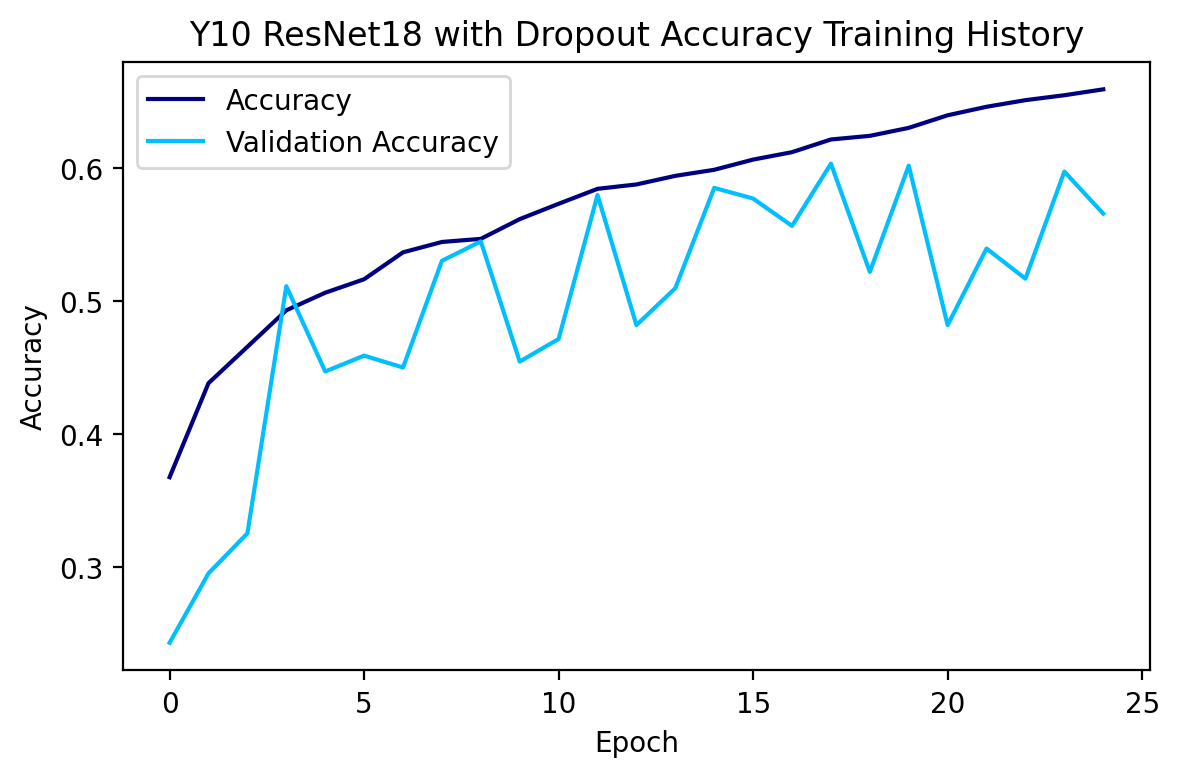

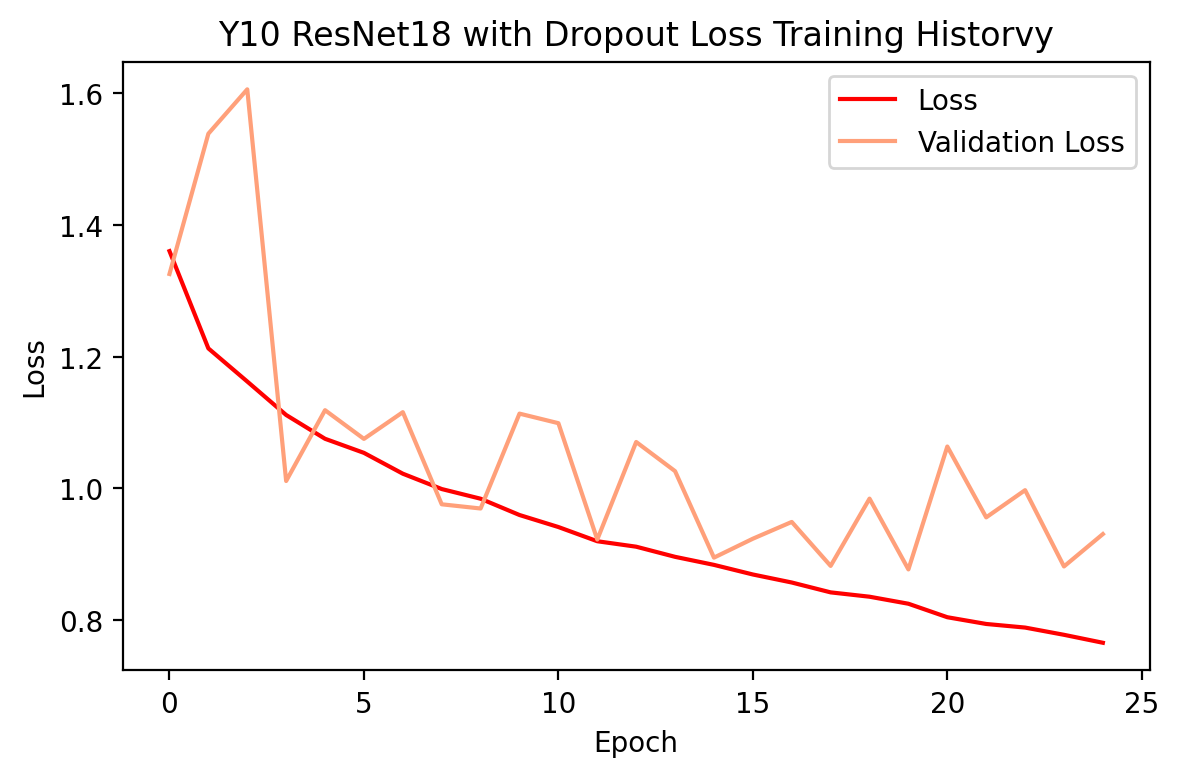

In [17]:
# Save model data
Y10_resnet18_model_dropout.save(filepath = f'Y10_ResNet18_Dropout', include_optimizer = True, overwrite = True)
    
# Saving history as .npy file for future use
np.save(f'Y1_ResNet18_Dropout2_history.npy', history_resnet18b.history)

# Plot training history
acc = history_resnet18b.history['accuracy']
val_acc = history_resnet18b.history['val_accuracy']

loss = history_resnet18b.history['loss']
val_loss = history_resnet18b.history['val_loss']
epochs = list(range(len(loss)))

# Plot accuracy
figsize=(6, 4)
figure = plt.figure(figsize=figsize)
plt.plot(epochs, acc, 'navy', label='Accuracy')
plt.plot(epochs, val_acc, 'deepskyblue', label= "Validation Accuracy")    
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f"Y10 ResNet18 with Dropout Accuracy Training History")
plt.legend(loc='best')
plt.tight_layout()
plt.savefig("Y10 ResNet18 with Dropout Accuracy Training History")
plt.show()

# Plot loss
figsize=(6, 4)
figure = plt.figure(figsize=figsize)
plt.plot(epochs, loss, 'red', label='Loss')
plt.plot(epochs, val_loss, 'lightsalmon', label= "Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f"Y10 ResNet18 with Dropout Loss Training Historvy")
plt.legend(loc='best')
plt.tight_layout()
plt.savefig("Y10 ResNet18 with Dropout Loss Training History")
plt.show()

2023-01-08 10:06:03.138146: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


734/734 [==============================] - 10s 12ms/step
Y10 Train:
              precision    recall  f1-score   support

      Spiral       0.87      0.40      0.55     10017
  Elliptical       0.56      0.63      0.59      5705
      Merger       0.50      0.81      0.62      7765

    accuracy                           0.59     23487
   macro avg       0.64      0.61      0.58     23487
weighted avg       0.67      0.59      0.58     23487


734/734 [==============================] - 10s 13ms/step


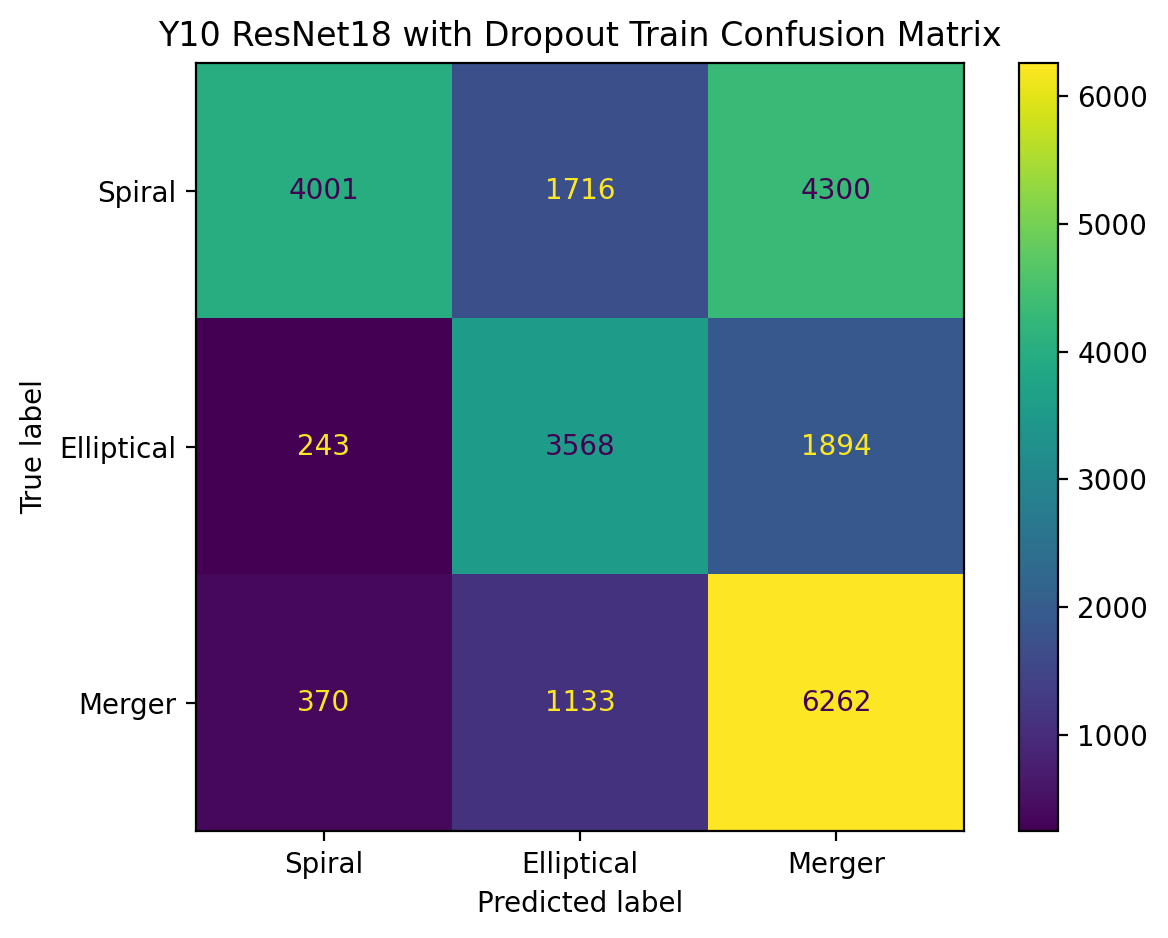

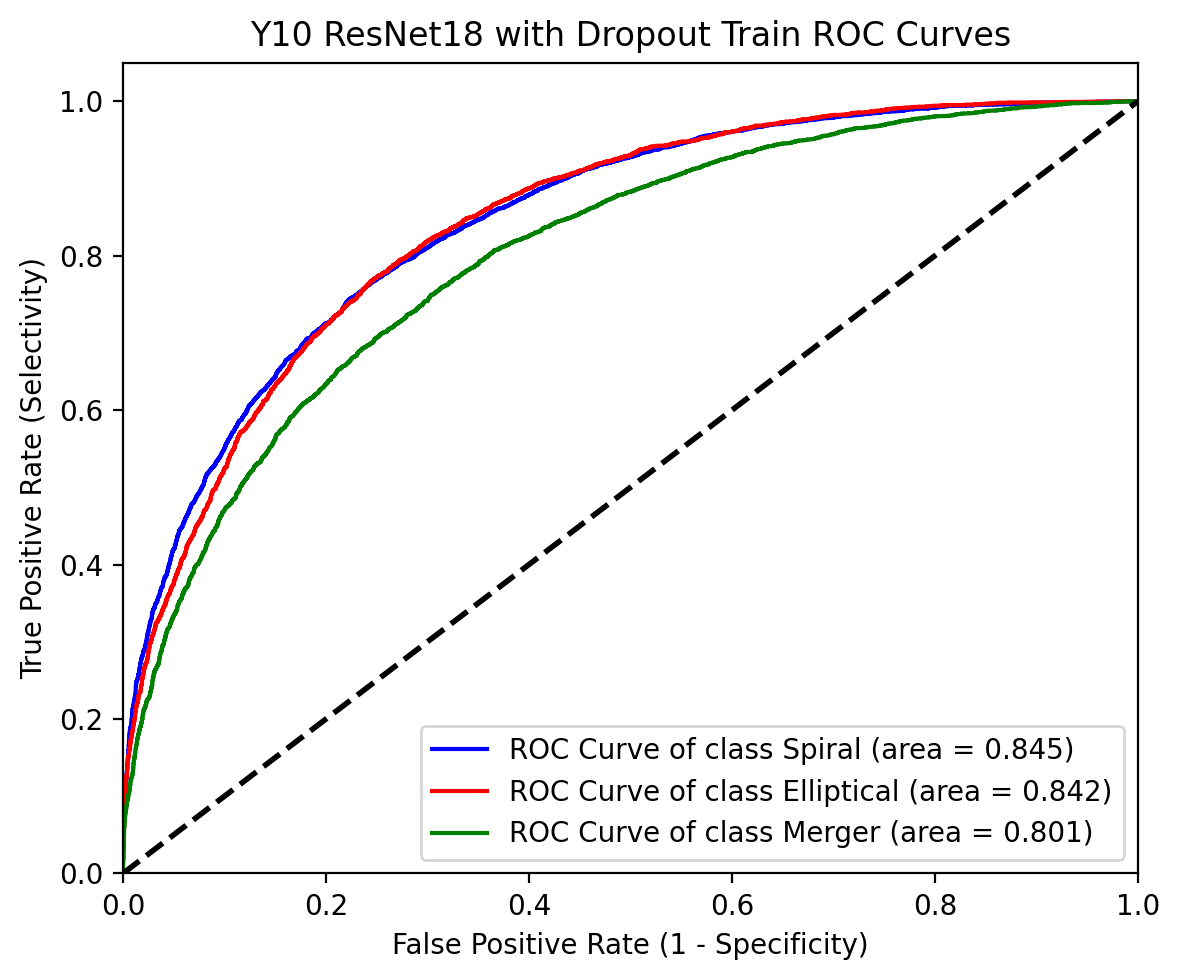

In [18]:
# Make Classification report, Confusion Matrix, and compute ROC & AUC for each class in each dataset
y_pred = Y10_resnet18_model_dropout.predict(X_train_10)
        
# Classification report
classification_metrics = classification_report(np.argmax(Y_train, axis=1), 
                                               np.argmax(y_pred, axis=1), 
                                               target_names=class_names)
print("Y10 Train:\n" + classification_metrics + '\n')

# Confusion Matrix
cm = confusion_matrix(np.argmax(Y_train, axis=1), 
                      np.argmax(Y10_resnet18_model_dropout.predict(X_train_10), axis=1),
                      labels=[0, 1, 2])
cm = cm.astype('float')
cd = ConfusionMatrixDisplay(cm, display_labels=class_names)
cd.plot(values_format='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Y10 ResNet18 with Dropout Train Confusion Matrix')
plt.tight_layout()
plt.savefig('Y10_ResNet18_Dropout_train_CM')
plt.show()

## ROC curves & AUC for a categorical classifier
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], thresholds = roc_curve(Y_train[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize = (6, 5), tight_layout=True)
colors = ['blue', 'red', 'green', 'brown', 'purple', 'pink', 'orange', 'black', 'yellow', 'cyan']
for i, color, lbl in zip(range(NUM_CLASSES), colors, class_names):
    plt.plot(fpr[i], tpr[i], color = color, lw = 1.5,
    label = 'ROC Curve of class {0} (area = {1:0.3f})'.format(lbl, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Selectivity)')
plt.legend(loc="lower right")
plt.title('Y10 ResNet18 with Dropout Train ROC Curves')
plt.savefig('Y10_ResNet18_Dropout_train_ROC')
plt.show()

210/210 [==============================] - 3s 15ms/step
Y10 Test:
              precision    recall  f1-score   support

      Spiral       0.82      0.37      0.51      2863
  Elliptical       0.51      0.59      0.55      1631
      Merger       0.48      0.76      0.58      2221

    accuracy                           0.55      6715
   macro avg       0.60      0.57      0.55      6715
weighted avg       0.63      0.55      0.55      6715


210/210 [==============================] - 3s 14ms/step


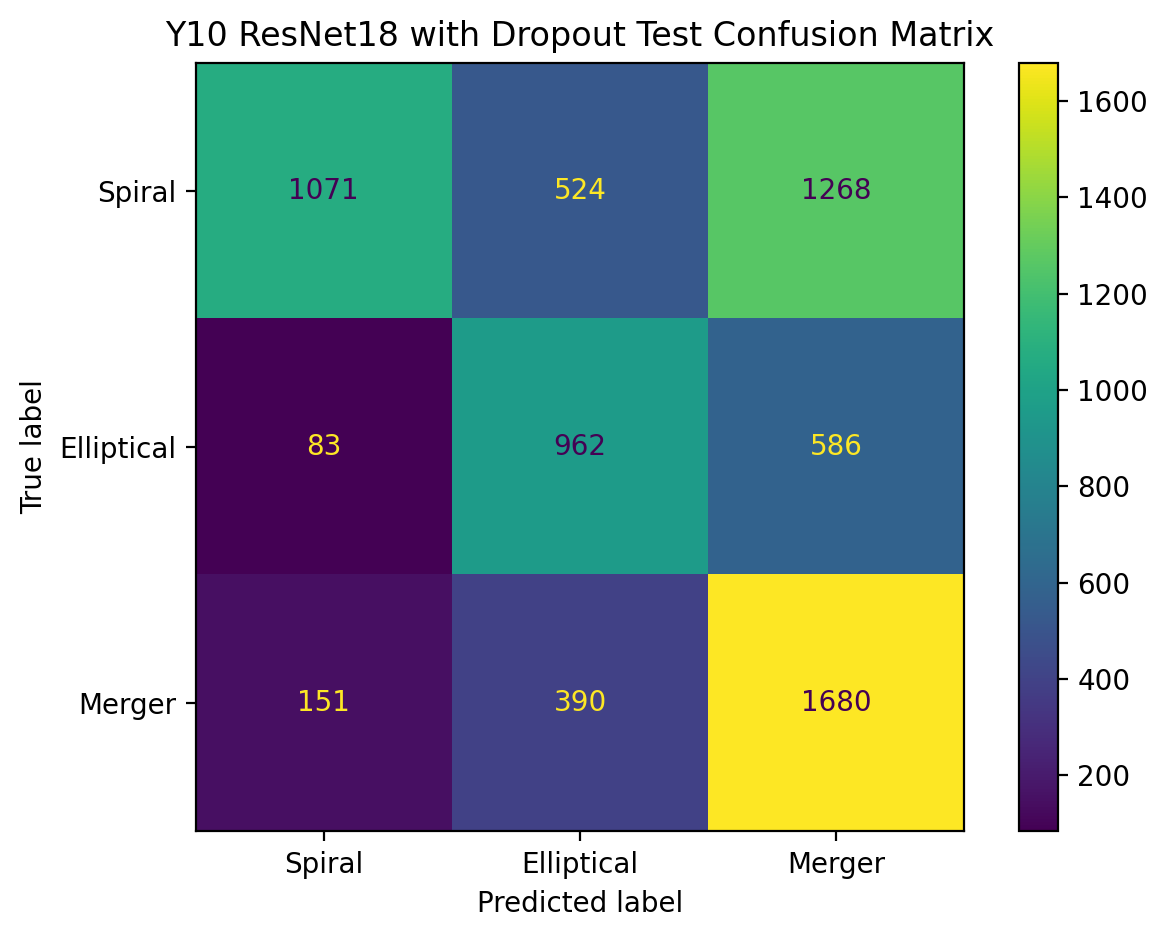

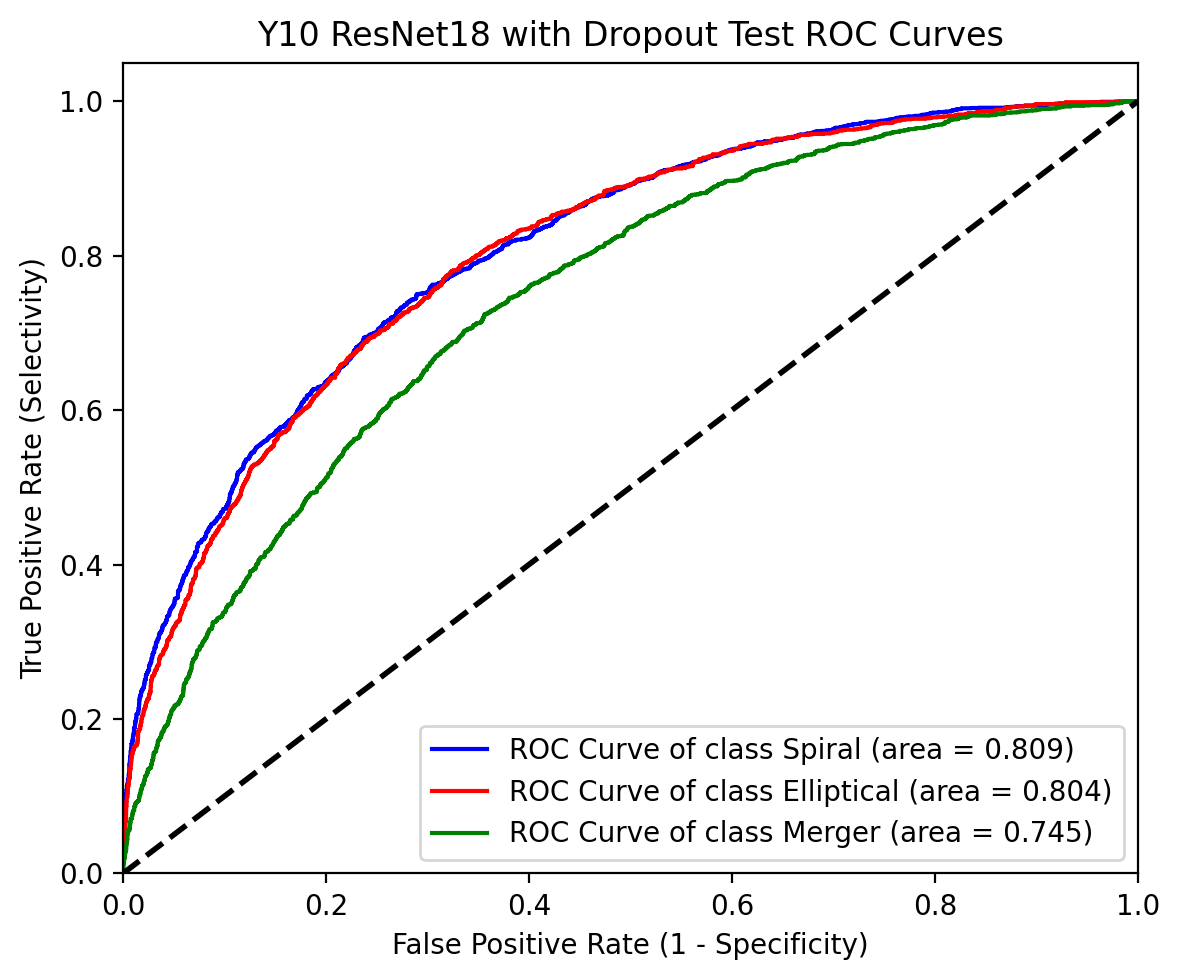

In [19]:
# Make Classification report, Confusion Matrix, and compute ROC & AUC for each class in each dataset
y_pred = Y10_resnet18_model_dropout.predict(X_test_10)
        
# Classification report
classification_metrics = classification_report(np.argmax(Y_test, axis=1), 
                                               np.argmax(y_pred, axis=1), 
                                               target_names=class_names)
print("Y10 Test:\n" + classification_metrics + '\n')

# Confusion Matrix
cm = confusion_matrix(np.argmax(Y_test, axis=1), 
                      np.argmax(Y10_resnet18_model_dropout.predict(X_test_10), axis=1),
                      labels=[0, 1, 2])
cm = cm.astype('float')
cd = ConfusionMatrixDisplay(cm, display_labels=class_names)
cd.plot(values_format='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Y10 ResNet18 with Dropout Test Confusion Matrix')
plt.tight_layout()
plt.savefig('Y10_ResNet18_Dropout_test_CM')
plt.show()

## ROC curves & AUC for a categorical classifier
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], thresholds = roc_curve(Y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize = (6, 5), tight_layout=True)
colors = ['blue', 'red', 'green', 'brown', 'purple', 'pink', 'orange', 'black', 'yellow', 'cyan']
for i, color, lbl in zip(range(NUM_CLASSES), colors, class_names):
    plt.plot(fpr[i], tpr[i], color = color, lw = 1.5,
    label = 'ROC Curve of class {0} (area = {1:0.3f})'.format(lbl, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Selectivity)')
plt.legend(loc="lower right")
plt.title('Y10 ResNet18 with Dropout Test ROC Curves')
plt.savefig('Y10_ResNet18_Dropout_test_ROC')
plt.show()

105/105 [==============================] - 1s 13ms/step
Validation:
              precision    recall  f1-score   support

      Spiral       0.88      0.39      0.54      1432
  Elliptical       0.52      0.57      0.55       815
      Merger       0.48      0.78      0.59      1108

    accuracy                           0.57      3355
   macro avg       0.63      0.58      0.56      3355
weighted avg       0.66      0.57      0.56      3355


105/105 [==============================] - 1s 13ms/step


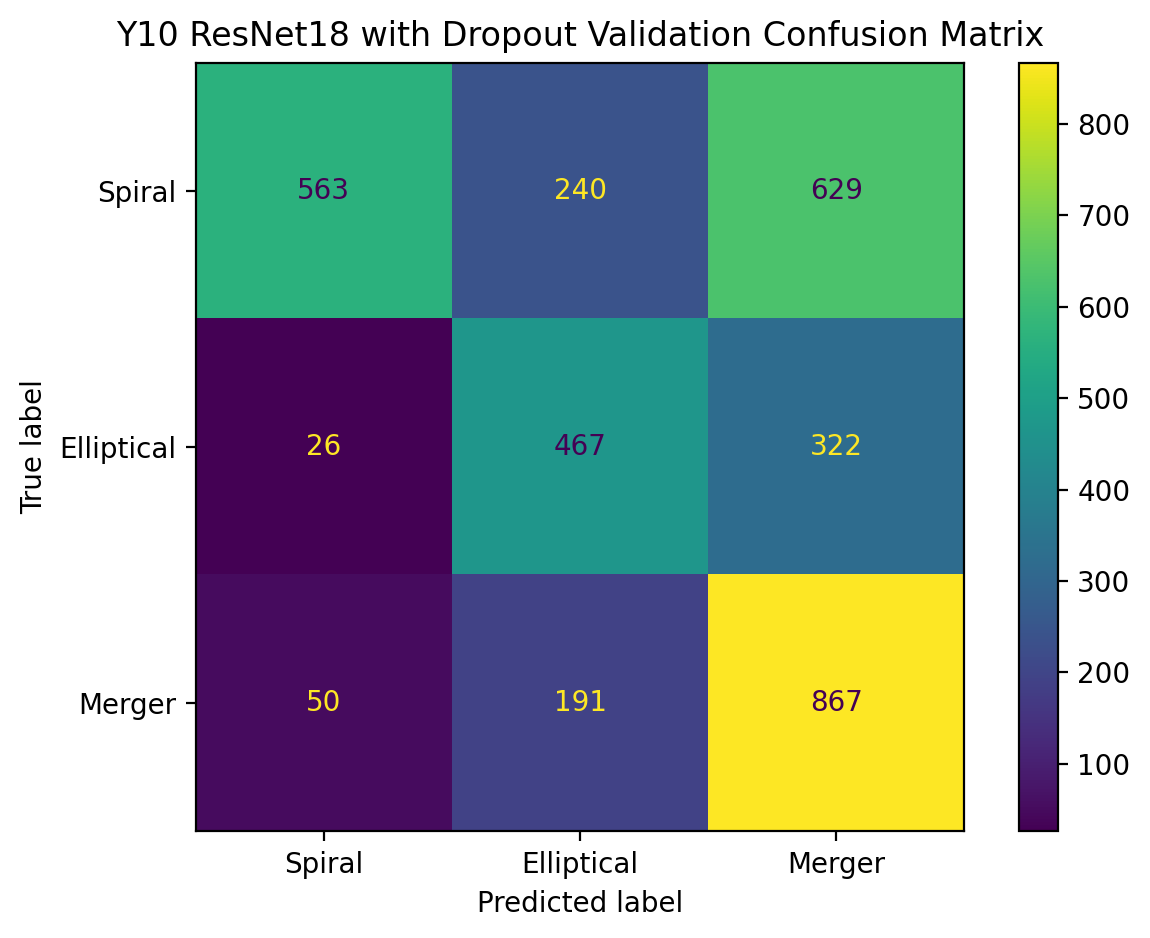

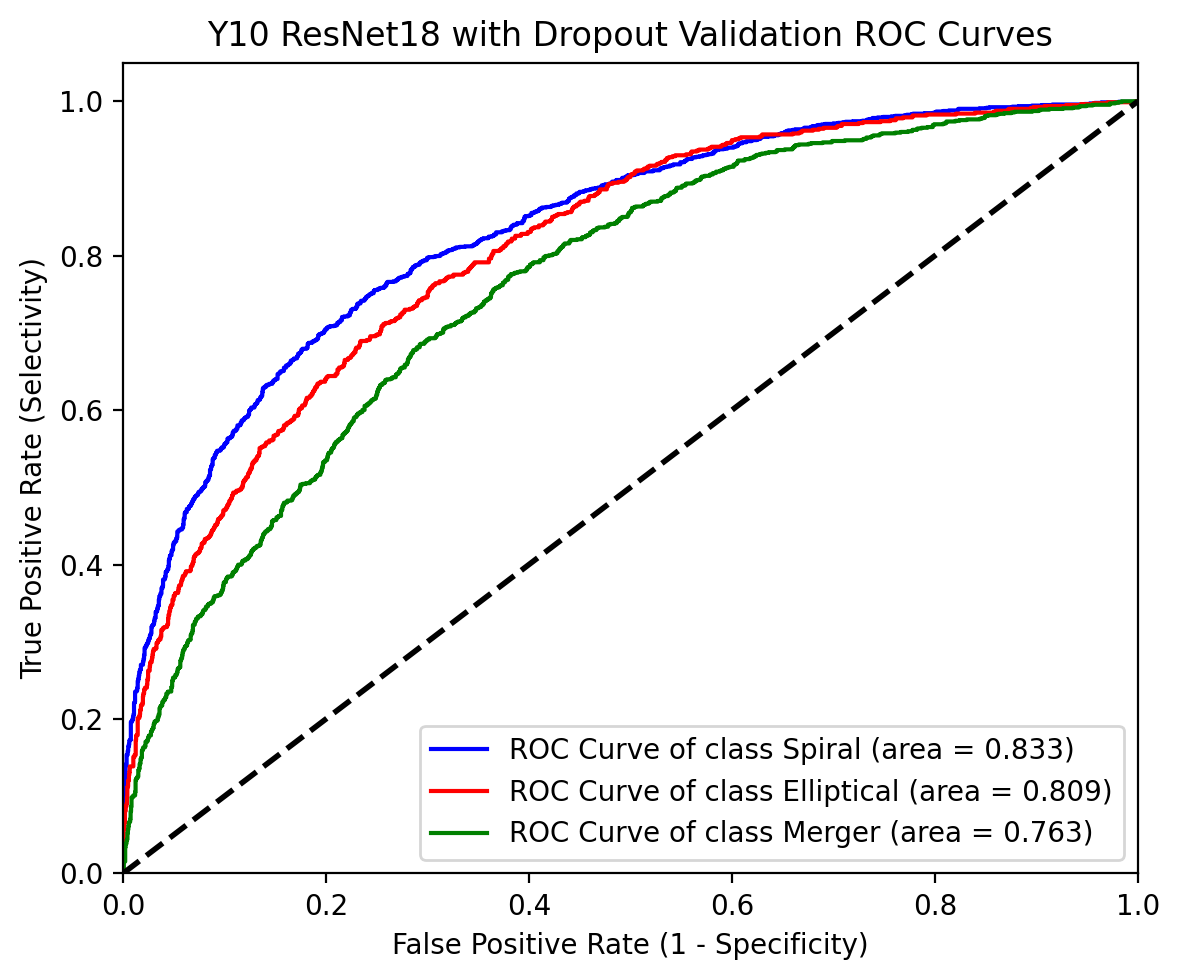

In [20]:
# Make Classification report, Confusion Matrix, and compute ROC & AUC for each class in each dataset
y_pred = Y10_resnet18_model_dropout.predict(X_valid_10)
        
# Classification report
classification_metrics = classification_report(np.argmax(Y_valid, axis=1), 
                                               np.argmax(y_pred, axis=1), 
                                               target_names=class_names)
print("Validation:\n" + classification_metrics + '\n')

# Confusion Matrix
cm = confusion_matrix(np.argmax(Y_valid, axis=1), 
                      np.argmax(Y10_resnet18_model_dropout.predict(X_valid_10), axis=1),
                      labels=[0, 1, 2])
cm = cm.astype('float')
cd = ConfusionMatrixDisplay(cm, display_labels=class_names)
cd.plot(values_format='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Y10 ResNet18 with Dropout Validation Confusion Matrix')
plt.tight_layout()
plt.savefig('Y10_ResNet18_Dropout_validation_CM')
plt.show()

## ROC curves & AUC for a categorical classifier
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], thresholds = roc_curve(Y_valid[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize = (6, 5), tight_layout=True)
colors = ['blue', 'red', 'green', 'brown', 'purple', 'pink', 'orange', 'black', 'yellow', 'cyan']
for i, color, lbl in zip(range(NUM_CLASSES), colors, class_names):
    plt.plot(fpr[i], tpr[i], color = color, lw = 1.5,
    label = 'ROC Curve of class {0} (area = {1:0.3f})'.format(lbl, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Selectivity)')
plt.legend(loc="lower right")
plt.title('Y10 ResNet18 with Dropout Validation ROC Curves')
plt.savefig('Y10_ResNet18_Dropout_validation_ROC')
plt.show()

210/210 [==============================] - 3s 13ms/step
Y1 Test:
              precision    recall  f1-score   support

      Spiral       0.60      0.02      0.04      2863
  Elliptical       0.44      0.03      0.06      1631
      Merger       0.33      0.97      0.50      2221

    accuracy                           0.34      6715
   macro avg       0.46      0.34      0.20      6715
weighted avg       0.47      0.34      0.20      6715


210/210 [==============================] - 3s 13ms/step


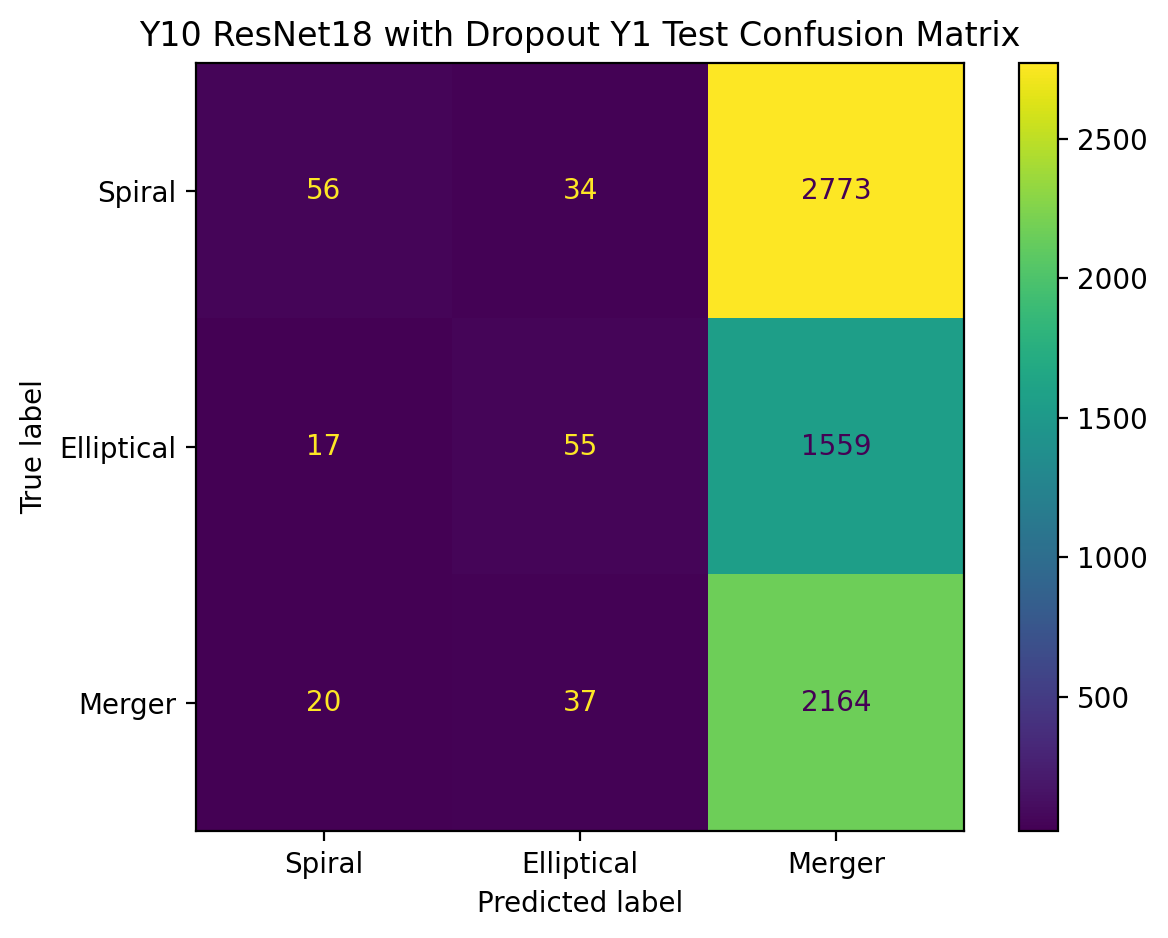

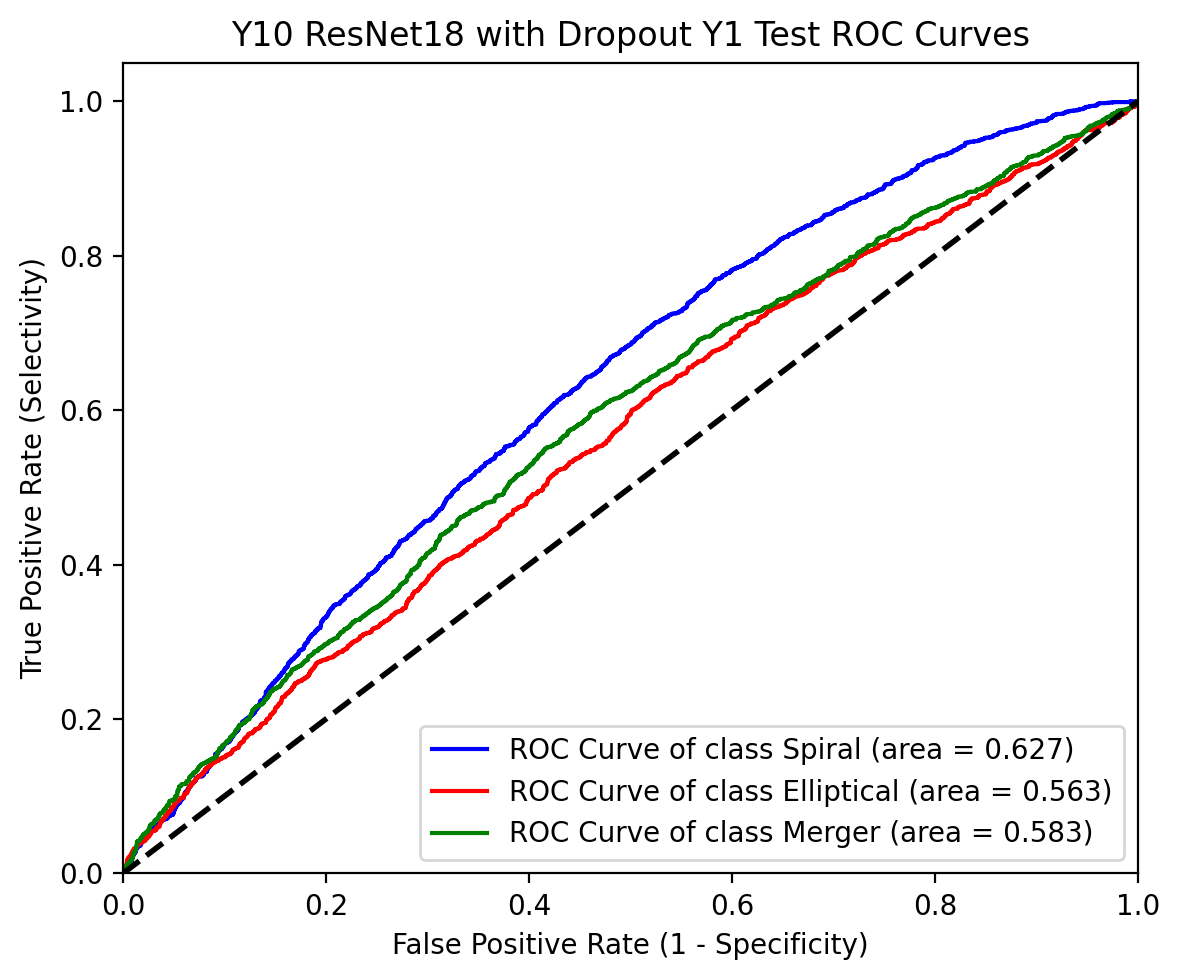

In [22]:
# Evaluate on Y1 test data
# Make Classification report, Confusion Matrix, and compute ROC & AUC for each class in each dataset
y_pred = Y10_resnet18_model_dropout.predict(X_test_1)
        
# Classification report
classification_metrics = classification_report(np.argmax(Y_test, axis=1), 
                                               np.argmax(y_pred, axis=1), 
                                               target_names=class_names)
print("Y1 Test:\n" + classification_metrics + '\n')

# Confusion Matrix
cm = confusion_matrix(np.argmax(Y_test, axis=1), 
                      np.argmax(Y10_resnet18_model_dropout.predict(X_test_1), axis=1),
                      labels=[0, 1, 2])
cm = cm.astype('float')
cd = ConfusionMatrixDisplay(cm, display_labels=class_names)
cd.plot(values_format='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Y10 ResNet18 with Dropout Y1 Test Confusion Matrix')
plt.tight_layout()
plt.savefig('Y10_ResNet18_Dropout_Y1_test_CM')
plt.show()

## ROC curves & AUC for a categorical classifier
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], thresholds = roc_curve(Y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize = (6, 5), tight_layout=True)
colors = ['blue', 'red', 'green', 'brown', 'purple', 'pink', 'orange', 'black', 'yellow', 'cyan']
for i, color, lbl in zip(range(NUM_CLASSES), colors, class_names):
    plt.plot(fpr[i], tpr[i], color = color, lw = 1.5,
    label = 'ROC Curve of class {0} (area = {1:0.3f})'.format(lbl, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Selectivity)')
plt.legend(loc="lower right")
plt.title('Y10 ResNet18 with Dropout Y1 Test ROC Curves')
plt.savefig('Y10_ResNet18_Dropout_Y1_test_ROC')
plt.show()

# Transfer Learning

Take the best model trained on Y1 data, test it on Y1 data. Initialize network using pre-trained weights, train for small number of epochs with the Y1 training set (use a smaller learning rate, maybe even smaller than current), then re-test on Y1 test set. Trying to transfer ability to extract features over to new dataset.

## Method 1: Try doing Transfer Learning without making previous layers non-trainable

In [33]:
## Reload a fresh ResNet18 w/ Dropout model from the saved best trained model, compile with same arguments as original
best_model = load_model("Y10_ResNet18_Dropout")

# Check for trainable and non-trainable variables
print("\nBest model has {} trainable variables: {}, ...".format(
          len(best_model.trainable_variables),
          ", ".join([v.name for v in best_model.trainable_variables])))

trainable_variable_ids = {id(v) for v in best_model.trainable_variables}
non_trainable_variables = [v for v in best_model.variables
                           if id(v) not in trainable_variable_ids]
print("\nBest model also has {} non-trainable variables: {}, ...".format(
          len(non_trainable_variables),
          ", ".join([v.name for v in non_trainable_variables])))


Best model has 62 trainable variables: conv1/kernel:0, bn1/gamma:0, bn1/beta:0, layer1.0.conv1/kernel:0, layer1.0.bn1/gamma:0, layer1.0.bn1/beta:0, layer1.0.conv2/kernel:0, layer1.0.bn2/gamma:0, layer1.0.bn2/beta:0, layer1.1.conv1/kernel:0, layer1.1.bn1/gamma:0, layer1.1.bn1/beta:0, layer1.1.conv2/kernel:0, layer1.1.bn2/gamma:0, layer1.1.bn2/beta:0, layer2.0.conv1/kernel:0, layer2.0.bn1/gamma:0, layer2.0.bn1/beta:0, layer2.0.downsample.0/kernel:0, layer2.0.conv2/kernel:0, layer2.0.downsample.1/gamma:0, layer2.0.downsample.1/beta:0, layer2.0.bn2/gamma:0, layer2.0.bn2/beta:0, layer2.1.conv1/kernel:0, layer2.1.bn1/gamma:0, layer2.1.bn1/beta:0, layer2.1.conv2/kernel:0, layer2.1.bn2/gamma:0, layer2.1.bn2/beta:0, layer3.0.conv1/kernel:0, layer3.0.bn1/gamma:0, layer3.0.bn1/beta:0, layer3.0.downsample.0/kernel:0, layer3.0.conv2/kernel:0, layer3.0.downsample.1/gamma:0, layer3.0.downsample.1/beta:0, layer3.0.bn2/gamma:0, layer3.0.bn2/beta:0, layer3.1.conv1/kernel:0, layer3.1.bn1/gamma:0, layer3

In [34]:
# Make last layer the output and initialize model
last = best_model.layers[-4].output
x = Dropout(0.5)(last)
x = GlobalAveragePooling2D(name='avgpool')(x)
outputs = Dense(units=NUM_CLASSES, activation="softmax", name='fc')(x)
Y10_resnet18_TL_trainable = Model(inputs = best_model.input, outputs = outputs)

## Compile Model
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
optimizer = Adam(learning_rate = 1e-7)
Y10_resnet18_TL_trainable.compile(loss = loss, optimizer = optimizer, metrics = ['accuracy'])
Y10_resnet18_TL_trainable.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 3, 100, 100  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 9, 106, 100)  0           ['input_1[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 2, 50, 64)    313600      ['conv1_pad[0][0]']              
                                                                                                  
 bn1 (BatchNormalization)       (None, 2, 50, 64)    256         ['conv1[0][0]']            

In [35]:
## Define Callback Functions

# Add tensorboard callback and log output folder
log_dir = "Y10_logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + f" {Y10_resnet18_TL_trainable.name}"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

es = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5), 
      ModelCheckpoint(filepath='Y10_resnet18_dropout_TL_trainable_best_weights', monitor='val_accuracy', 
                      mode='max', verbose=1, save_best_only=True),
      tensorboard_callback,
      ReduceLROnPlateau(monitor='val_loss', mode='min', verbose=1, patience=5, factor=0.1)
      ]

In [36]:
# Train the new layers on the Y1 train dataset
# Set seed for reproducibility
random.seed(0)

## Train Model
batch_size = 128
NUM_EPOCH = 200
history_resnet18_TL_trainable = Y10_resnet18_TL_trainable.fit(X_train_1, Y_train,
                                                                batch_size = batch_size,
                                                                epochs = NUM_EPOCH,
                                                                validation_data = (X_valid_1, Y_valid),                
                                                                shuffle = True,
                                                                class_weight = class_weights,
                                                                verbose = 1,
                                                                callbacks = es
                                                                )

Epoch 1/200


2023-01-08 14:47:00.473363: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


184/184 [==============================] - ETA: 0s - loss: 1.1856 - accuracy: 0.4359

2023-01-08 14:47:32.717717: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.45127, saving model to Y10_resnet18_dropout_TL_trainable_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_trainable_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_trainable_best_weights/assets


184/184 [==============================] - 45s 221ms/step - loss: 1.1856 - accuracy: 0.4359 - val_loss: 1.1205 - val_accuracy: 0.4513 - lr: 1.0000e-07
Epoch 2/200
184/184 [==============================] - ETA: 0s - loss: 1.1774 - accuracy: 0.4419
Epoch 2: val_accuracy improved from 0.45127 to 0.46319, saving model to Y10_resnet18_dropout_TL_trainable_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_trainable_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_trainable_best_weights/assets


184/184 [==============================] - 37s 202ms/step - loss: 1.1774 - accuracy: 0.4419 - val_loss: 1.0777 - val_accuracy: 0.4632 - lr: 1.0000e-07
Epoch 3/200
184/184 [==============================] - ETA: 0s - loss: 1.1688 - accuracy: 0.4461
Epoch 3: val_accuracy improved from 0.46319 to 0.46677, saving model to Y10_resnet18_dropout_TL_trainable_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_trainable_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_trainable_best_weights/assets


184/184 [==============================] - 37s 203ms/step - loss: 1.1688 - accuracy: 0.4461 - val_loss: 1.0751 - val_accuracy: 0.4668 - lr: 1.0000e-07
Epoch 4/200
184/184 [==============================] - ETA: 0s - loss: 1.1550 - accuracy: 0.4518
Epoch 4: val_accuracy improved from 0.46677 to 0.46915, saving model to Y10_resnet18_dropout_TL_trainable_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_trainable_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_trainable_best_weights/assets


184/184 [==============================] - 38s 204ms/step - loss: 1.1550 - accuracy: 0.4518 - val_loss: 1.0704 - val_accuracy: 0.4692 - lr: 1.0000e-07
Epoch 5/200
184/184 [==============================] - ETA: 0s - loss: 1.1498 - accuracy: 0.4533
Epoch 5: val_accuracy improved from 0.46915 to 0.48525, saving model to Y10_resnet18_dropout_TL_trainable_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_trainable_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_trainable_best_weights/assets


184/184 [==============================] - 37s 202ms/step - loss: 1.1498 - accuracy: 0.4533 - val_loss: 1.0437 - val_accuracy: 0.4852 - lr: 1.0000e-07
Epoch 6/200
184/184 [==============================] - ETA: 0s - loss: 1.1441 - accuracy: 0.4595
Epoch 6: val_accuracy did not improve from 0.48525
184/184 [==============================] - 29s 160ms/step - loss: 1.1441 - accuracy: 0.4595 - val_loss: 1.0558 - val_accuracy: 0.4778 - lr: 1.0000e-07
Epoch 7/200
184/184 [==============================] - ETA: 0s - loss: 1.1374 - accuracy: 0.4626
Epoch 7: val_accuracy improved from 0.48525 to 0.48584, saving model to Y10_resnet18_dropout_TL_trainable_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_trainable_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_trainable_best_weights/assets


184/184 [==============================] - 37s 200ms/step - loss: 1.1374 - accuracy: 0.4626 - val_loss: 1.0394 - val_accuracy: 0.4858 - lr: 1.0000e-07
Epoch 8/200
184/184 [==============================] - ETA: 0s - loss: 1.1332 - accuracy: 0.4624
Epoch 8: val_accuracy improved from 0.48584 to 0.48823, saving model to Y10_resnet18_dropout_TL_trainable_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_trainable_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_trainable_best_weights/assets


184/184 [==============================] - 38s 205ms/step - loss: 1.1332 - accuracy: 0.4624 - val_loss: 1.0361 - val_accuracy: 0.4882 - lr: 1.0000e-07
Epoch 9/200
184/184 [==============================] - ETA: 0s - loss: 1.1237 - accuracy: 0.4698
Epoch 9: val_accuracy did not improve from 0.48823
184/184 [==============================] - 29s 159ms/step - loss: 1.1237 - accuracy: 0.4698 - val_loss: 1.0280 - val_accuracy: 0.4879 - lr: 1.0000e-07
Epoch 10/200
184/184 [==============================] - ETA: 0s - loss: 1.1243 - accuracy: 0.4745
Epoch 10: val_accuracy did not improve from 0.48823
184/184 [==============================] - 29s 158ms/step - loss: 1.1243 - accuracy: 0.4745 - val_loss: 1.0349 - val_accuracy: 0.4873 - lr: 1.0000e-07
Epoch 11/200
184/184 [==============================] - ETA: 0s - loss: 1.1160 - accuracy: 0.4720
Epoch 11: val_accuracy improved from 0.48823 to 0.49300, saving model to Y10_resnet18_dropout_TL_trainable_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_trainable_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_trainable_best_weights/assets


184/184 [==============================] - 37s 202ms/step - loss: 1.1160 - accuracy: 0.4720 - val_loss: 1.0332 - val_accuracy: 0.4930 - lr: 1.0000e-07
Epoch 12/200
184/184 [==============================] - ETA: 0s - loss: 1.1152 - accuracy: 0.4735
Epoch 12: val_accuracy did not improve from 0.49300
184/184 [==============================] - 30s 161ms/step - loss: 1.1152 - accuracy: 0.4735 - val_loss: 1.0291 - val_accuracy: 0.4909 - lr: 1.0000e-07
Epoch 13/200
184/184 [==============================] - ETA: 0s - loss: 1.1102 - accuracy: 0.4800
Epoch 13: val_accuracy did not improve from 0.49300
184/184 [==============================] - 31s 167ms/step - loss: 1.1102 - accuracy: 0.4800 - val_loss: 1.0360 - val_accuracy: 0.4885 - lr: 1.0000e-07
Epoch 14/200
184/184 [==============================] - ETA: 0s - loss: 1.1067 - accuracy: 0.4781
Epoch 14: val_accuracy improved from 0.49300 to 0.50045, saving model to Y10_resnet18_dropout_TL_trainable_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_trainable_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_trainable_best_weights/assets


184/184 [==============================] - 38s 207ms/step - loss: 1.1067 - accuracy: 0.4781 - val_loss: 1.0177 - val_accuracy: 0.5004 - lr: 1.0000e-07
Epoch 15/200
184/184 [==============================] - ETA: 0s - loss: 1.0998 - accuracy: 0.4816
Epoch 15: val_accuracy did not improve from 0.50045
184/184 [==============================] - 29s 160ms/step - loss: 1.0998 - accuracy: 0.4816 - val_loss: 1.0187 - val_accuracy: 0.4957 - lr: 1.0000e-07
Epoch 16/200
184/184 [==============================] - ETA: 0s - loss: 1.0995 - accuracy: 0.4809
Epoch 16: val_accuracy did not improve from 0.50045
184/184 [==============================] - 30s 162ms/step - loss: 1.0995 - accuracy: 0.4809 - val_loss: 1.0151 - val_accuracy: 0.4990 - lr: 1.0000e-07
Epoch 17/200
184/184 [==============================] - ETA: 0s - loss: 1.0982 - accuracy: 0.4827
Epoch 17: val_accuracy improved from 0.50045 to 0.50164, saving model to Y10_resnet18_dropout_TL_trainable_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_trainable_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_trainable_best_weights/assets


184/184 [==============================] - 39s 210ms/step - loss: 1.0982 - accuracy: 0.4827 - val_loss: 1.0134 - val_accuracy: 0.5016 - lr: 1.0000e-07
Epoch 18/200
184/184 [==============================] - ETA: 0s - loss: 1.0968 - accuracy: 0.4831
Epoch 18: val_accuracy improved from 0.50164 to 0.50224, saving model to Y10_resnet18_dropout_TL_trainable_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_trainable_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_trainable_best_weights/assets


184/184 [==============================] - 37s 201ms/step - loss: 1.0968 - accuracy: 0.4831 - val_loss: 1.0117 - val_accuracy: 0.5022 - lr: 1.0000e-07
Epoch 19/200
184/184 [==============================] - ETA: 0s - loss: 1.0891 - accuracy: 0.4889
Epoch 19: val_accuracy did not improve from 0.50224
184/184 [==============================] - 29s 158ms/step - loss: 1.0891 - accuracy: 0.4889 - val_loss: 1.0202 - val_accuracy: 0.4942 - lr: 1.0000e-07
Epoch 20/200
184/184 [==============================] - ETA: 0s - loss: 1.0849 - accuracy: 0.4918
Epoch 20: val_accuracy improved from 0.50224 to 0.50283, saving model to Y10_resnet18_dropout_TL_trainable_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_trainable_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_trainable_best_weights/assets


184/184 [==============================] - 37s 199ms/step - loss: 1.0849 - accuracy: 0.4918 - val_loss: 1.0090 - val_accuracy: 0.5028 - lr: 1.0000e-07
Epoch 21/200
184/184 [==============================] - ETA: 0s - loss: 1.0830 - accuracy: 0.4906
Epoch 21: val_accuracy improved from 0.50283 to 0.50373, saving model to Y10_resnet18_dropout_TL_trainable_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_trainable_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_trainable_best_weights/assets


184/184 [==============================] - 36s 196ms/step - loss: 1.0830 - accuracy: 0.4906 - val_loss: 1.0072 - val_accuracy: 0.5037 - lr: 1.0000e-07
Epoch 22/200
184/184 [==============================] - ETA: 0s - loss: 1.0845 - accuracy: 0.4927
Epoch 22: val_accuracy did not improve from 0.50373
184/184 [==============================] - 29s 158ms/step - loss: 1.0845 - accuracy: 0.4927 - val_loss: 1.0041 - val_accuracy: 0.5031 - lr: 1.0000e-07
Epoch 23/200
184/184 [==============================] - ETA: 0s - loss: 1.0793 - accuracy: 0.4967
Epoch 23: val_accuracy did not improve from 0.50373
184/184 [==============================] - 29s 158ms/step - loss: 1.0793 - accuracy: 0.4967 - val_loss: 1.0103 - val_accuracy: 0.5031 - lr: 1.0000e-07
Epoch 24/200
184/184 [==============================] - ETA: 0s - loss: 1.0772 - accuracy: 0.4907
Epoch 24: val_accuracy improved from 0.50373 to 0.50939, saving model to Y10_resnet18_dropout_TL_trainable_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_trainable_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_trainable_best_weights/assets


184/184 [==============================] - 36s 196ms/step - loss: 1.0772 - accuracy: 0.4907 - val_loss: 1.0026 - val_accuracy: 0.5094 - lr: 1.0000e-07
Epoch 25/200
184/184 [==============================] - ETA: 0s - loss: 1.0705 - accuracy: 0.4961
Epoch 25: val_accuracy did not improve from 0.50939
184/184 [==============================] - 29s 156ms/step - loss: 1.0705 - accuracy: 0.4961 - val_loss: 1.0061 - val_accuracy: 0.5061 - lr: 1.0000e-07
Epoch 26/200
184/184 [==============================] - ETA: 0s - loss: 1.0669 - accuracy: 0.4941
Epoch 26: val_accuracy improved from 0.50939 to 0.51386, saving model to Y10_resnet18_dropout_TL_trainable_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_trainable_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_trainable_best_weights/assets


184/184 [==============================] - 36s 198ms/step - loss: 1.0669 - accuracy: 0.4941 - val_loss: 0.9950 - val_accuracy: 0.5139 - lr: 1.0000e-07
Epoch 27/200
184/184 [==============================] - ETA: 0s - loss: 1.0689 - accuracy: 0.4951
Epoch 27: val_accuracy did not improve from 0.51386
184/184 [==============================] - 29s 157ms/step - loss: 1.0689 - accuracy: 0.4951 - val_loss: 0.9973 - val_accuracy: 0.5127 - lr: 1.0000e-07
Epoch 28/200
184/184 [==============================] - ETA: 0s - loss: 1.0659 - accuracy: 0.4986
Epoch 28: val_accuracy improved from 0.51386 to 0.51833, saving model to Y10_resnet18_dropout_TL_trainable_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_trainable_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_trainable_best_weights/assets


184/184 [==============================] - 35s 192ms/step - loss: 1.0659 - accuracy: 0.4986 - val_loss: 0.9914 - val_accuracy: 0.5183 - lr: 1.0000e-07
Epoch 29/200
184/184 [==============================] - ETA: 0s - loss: 1.0538 - accuracy: 0.5064
Epoch 29: val_accuracy did not improve from 0.51833
184/184 [==============================] - 28s 154ms/step - loss: 1.0538 - accuracy: 0.5064 - val_loss: 0.9946 - val_accuracy: 0.5103 - lr: 1.0000e-07
Epoch 30/200
184/184 [==============================] - ETA: 0s - loss: 1.0573 - accuracy: 0.5018
Epoch 30: val_accuracy did not improve from 0.51833
184/184 [==============================] - 28s 154ms/step - loss: 1.0573 - accuracy: 0.5018 - val_loss: 0.9917 - val_accuracy: 0.5139 - lr: 1.0000e-07
Epoch 31/200
184/184 [==============================] - ETA: 0s - loss: 1.0499 - accuracy: 0.5040
Epoch 31: val_accuracy improved from 0.51833 to 0.51893, saving model to Y10_resnet18_dropout_TL_trainable_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_trainable_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_trainable_best_weights/assets


184/184 [==============================] - 36s 196ms/step - loss: 1.0499 - accuracy: 0.5040 - val_loss: 0.9866 - val_accuracy: 0.5189 - lr: 1.0000e-07
Epoch 32/200
184/184 [==============================] - ETA: 0s - loss: 1.0541 - accuracy: 0.5025
Epoch 32: val_accuracy did not improve from 0.51893
184/184 [==============================] - 28s 154ms/step - loss: 1.0541 - accuracy: 0.5025 - val_loss: 0.9868 - val_accuracy: 0.5124 - lr: 1.0000e-07
Epoch 33/200
184/184 [==============================] - ETA: 0s - loss: 1.0478 - accuracy: 0.5082
Epoch 33: val_accuracy did not improve from 0.51893
184/184 [==============================] - 29s 155ms/step - loss: 1.0478 - accuracy: 0.5082 - val_loss: 0.9952 - val_accuracy: 0.5094 - lr: 1.0000e-07
Epoch 34/200
184/184 [==============================] - ETA: 0s - loss: 1.0469 - accuracy: 0.5093
Epoch 34: val_accuracy did not improve from 0.51893
184/184 [==============================] - 28s 155ms/step - loss: 1.0469 - accuracy: 0.5093 - val

INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_trainable_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_trainable_best_weights/assets


184/184 [==============================] - 35s 191ms/step - loss: 1.0386 - accuracy: 0.5122 - val_loss: 0.9741 - val_accuracy: 0.5285 - lr: 1.0000e-07
Epoch 36/200
184/184 [==============================] - ETA: 0s - loss: 1.0462 - accuracy: 0.5129
Epoch 36: val_accuracy did not improve from 0.52846
184/184 [==============================] - 28s 154ms/step - loss: 1.0462 - accuracy: 0.5129 - val_loss: 0.9875 - val_accuracy: 0.5186 - lr: 1.0000e-07
Epoch 37/200
184/184 [==============================] - ETA: 0s - loss: 1.0421 - accuracy: 0.5132
Epoch 37: val_accuracy did not improve from 0.52846
184/184 [==============================] - 28s 155ms/step - loss: 1.0421 - accuracy: 0.5132 - val_loss: 0.9872 - val_accuracy: 0.5142 - lr: 1.0000e-07
Epoch 38/200
184/184 [==============================] - ETA: 0s - loss: 1.0358 - accuracy: 0.5096
Epoch 38: val_accuracy did not improve from 0.52846
184/184 [==============================] - 28s 153ms/step - loss: 1.0358 - accuracy: 0.5096 - val

In [ ]:
%tensorboard --logdir logs/fit

INFO:tensorflow:Assets written to: Y10_ResNet18_Dropout_TL_trainable/assets


INFO:tensorflow:Assets written to: Y10_ResNet18_Dropout_TL_trainable/assets


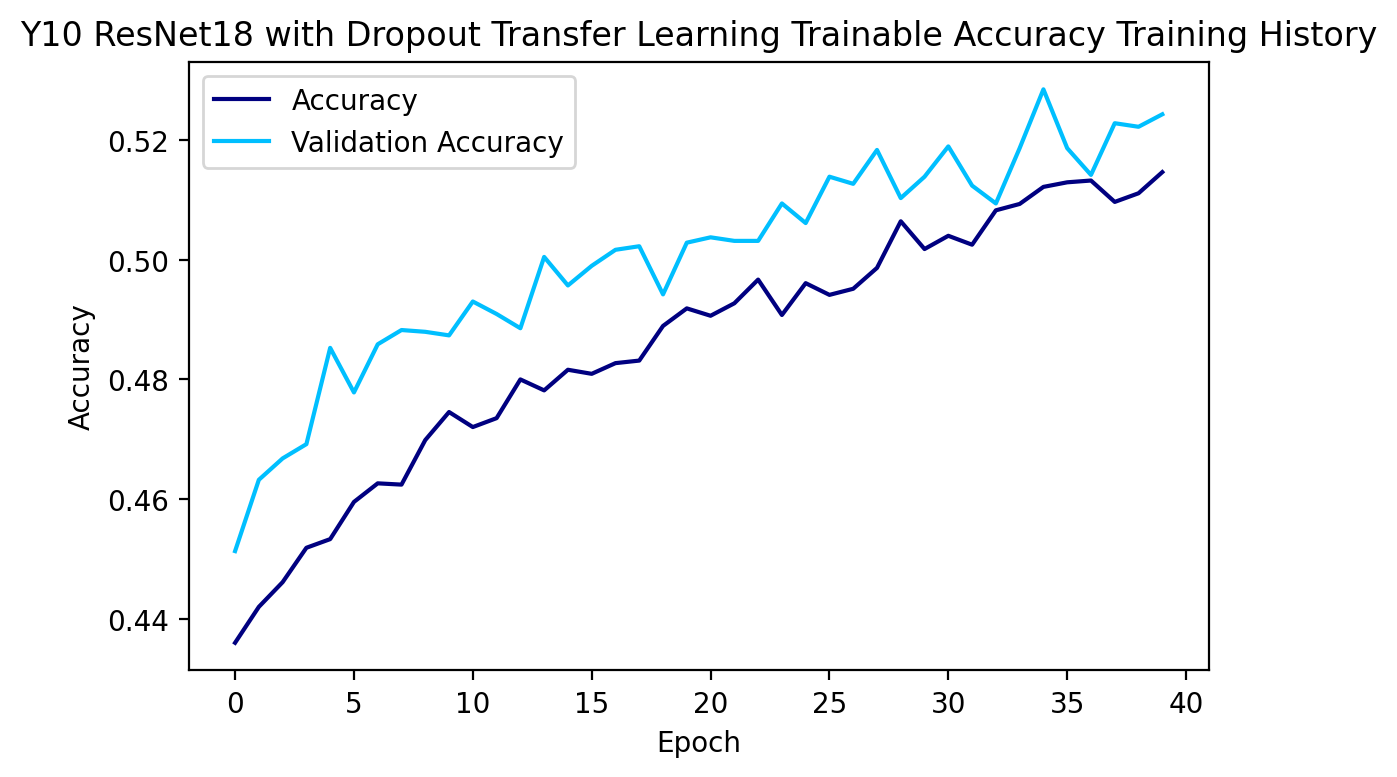

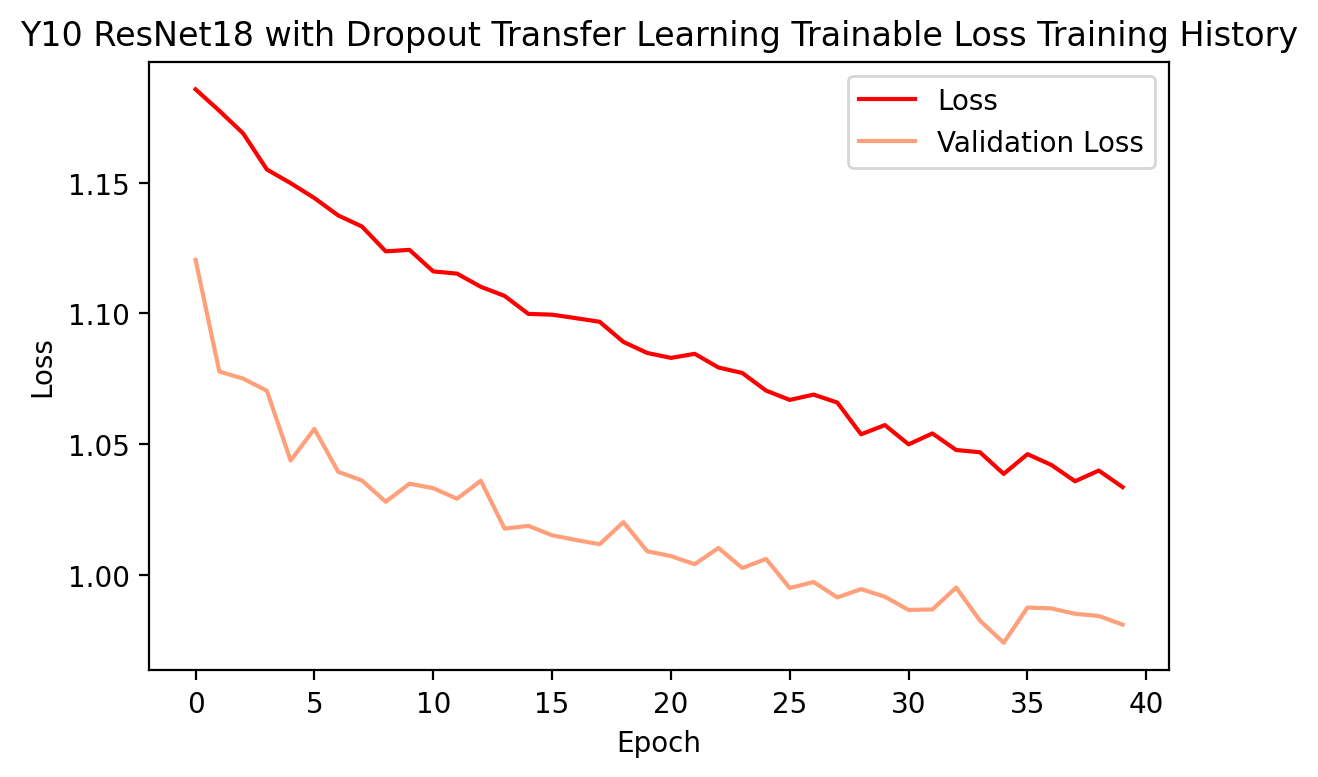

In [39]:
# Save model data
Y10_resnet18_TL_trainable.save(filepath = f'Y10_ResNet18_Dropout_TL_trainable', include_optimizer = True, overwrite = True)
    
# Saving history as .npy file for future use
np.save(f'Y10_ResNet18_Dropout_TL_trainable_history.npy', history_resnet18_TL_trainable.history)

# Plot training history
acc = history_resnet18_TL_trainable.history['accuracy']
val_acc = history_resnet18_TL_trainable.history['val_accuracy']

loss = history_resnet18_TL_trainable.history['loss']
val_loss = history_resnet18_TL_trainable.history['val_loss']
epochs = list(range(len(loss)))

# Plot accuracy
figsize=(6, 4)
figure = plt.figure(figsize=figsize)
plt.plot(epochs, acc, 'navy', label='Accuracy')
plt.plot(epochs, val_acc, 'deepskyblue', label= "Validation Accuracy")    
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f"Y10 ResNet18 with Dropout Transfer Learning Trainable Accuracy Training History")
plt.legend(loc='best')
plt.tight_layout()
plt.savefig("Y10 ResNet18 with Dropout Transfer Learning Trainable Accuracy Training History")
plt.show()

# Plot loss
figsize=(6, 4)
figure = plt.figure(figsize=figsize)
plt.plot(epochs, loss, 'red', label='Loss')
plt.plot(epochs, val_loss, 'lightsalmon', label= "Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f"Y10 ResNet18 with Dropout Transfer Learning Trainable Loss Training History")
plt.legend(loc='best')
plt.tight_layout()
plt.savefig("Y10 ResNet18 with Dropout Transfer Learning Trainable Loss Training History")
plt.show()

210/210 [==============================] - 3s 12ms/step
Y1 Test:
              precision    recall  f1-score   support

      Spiral       0.63      0.54      0.58      2863
  Elliptical       0.41      0.55      0.47      1631
      Merger       0.48      0.45      0.47      2221

    accuracy                           0.51      6715
   macro avg       0.51      0.51      0.50      6715
weighted avg       0.53      0.51      0.52      6715


210/210 [==============================] - 2s 12ms/step


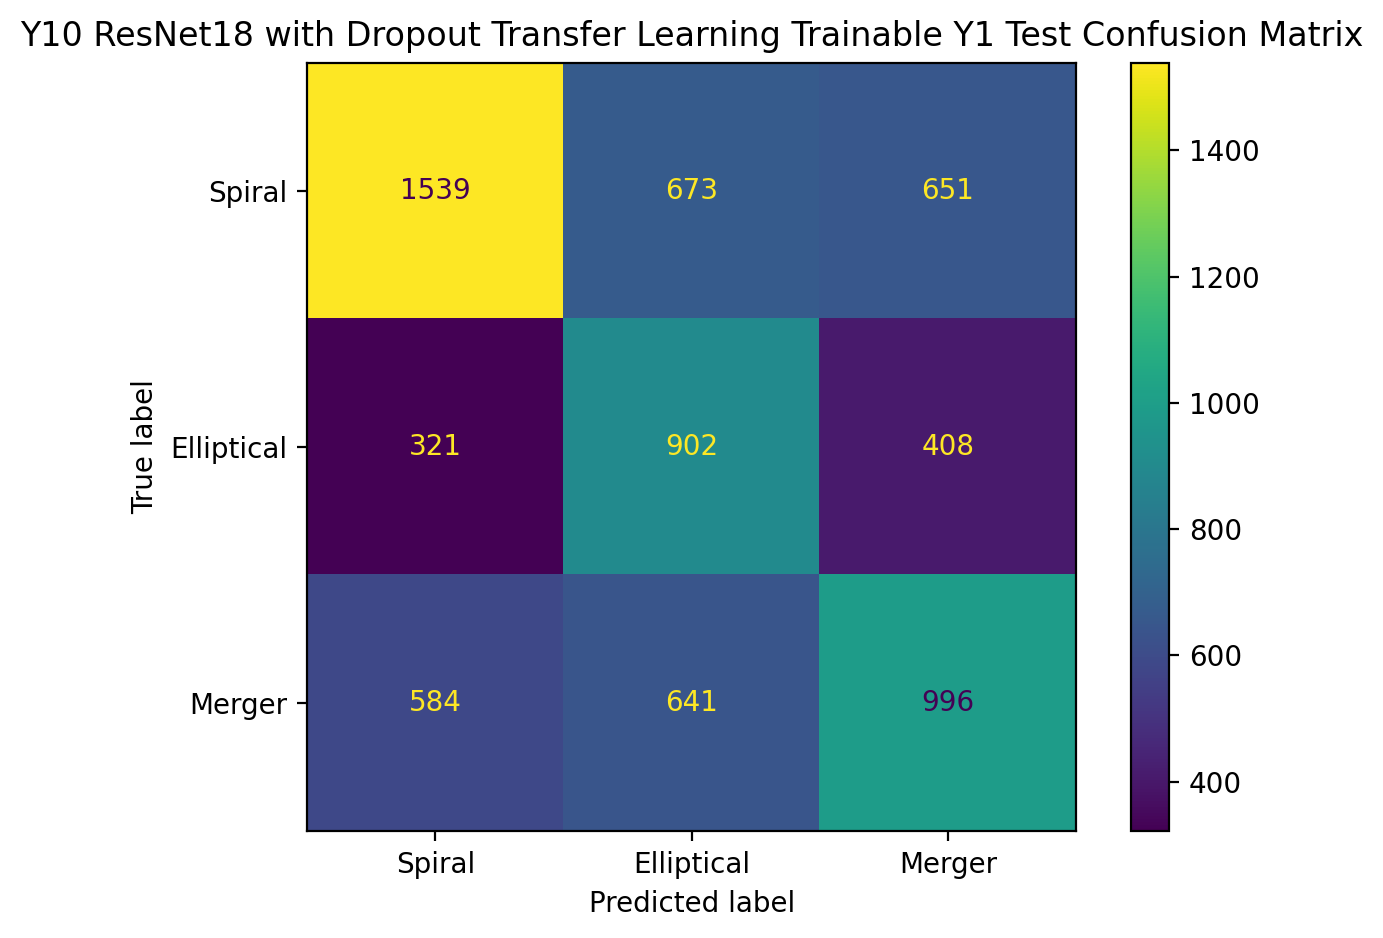

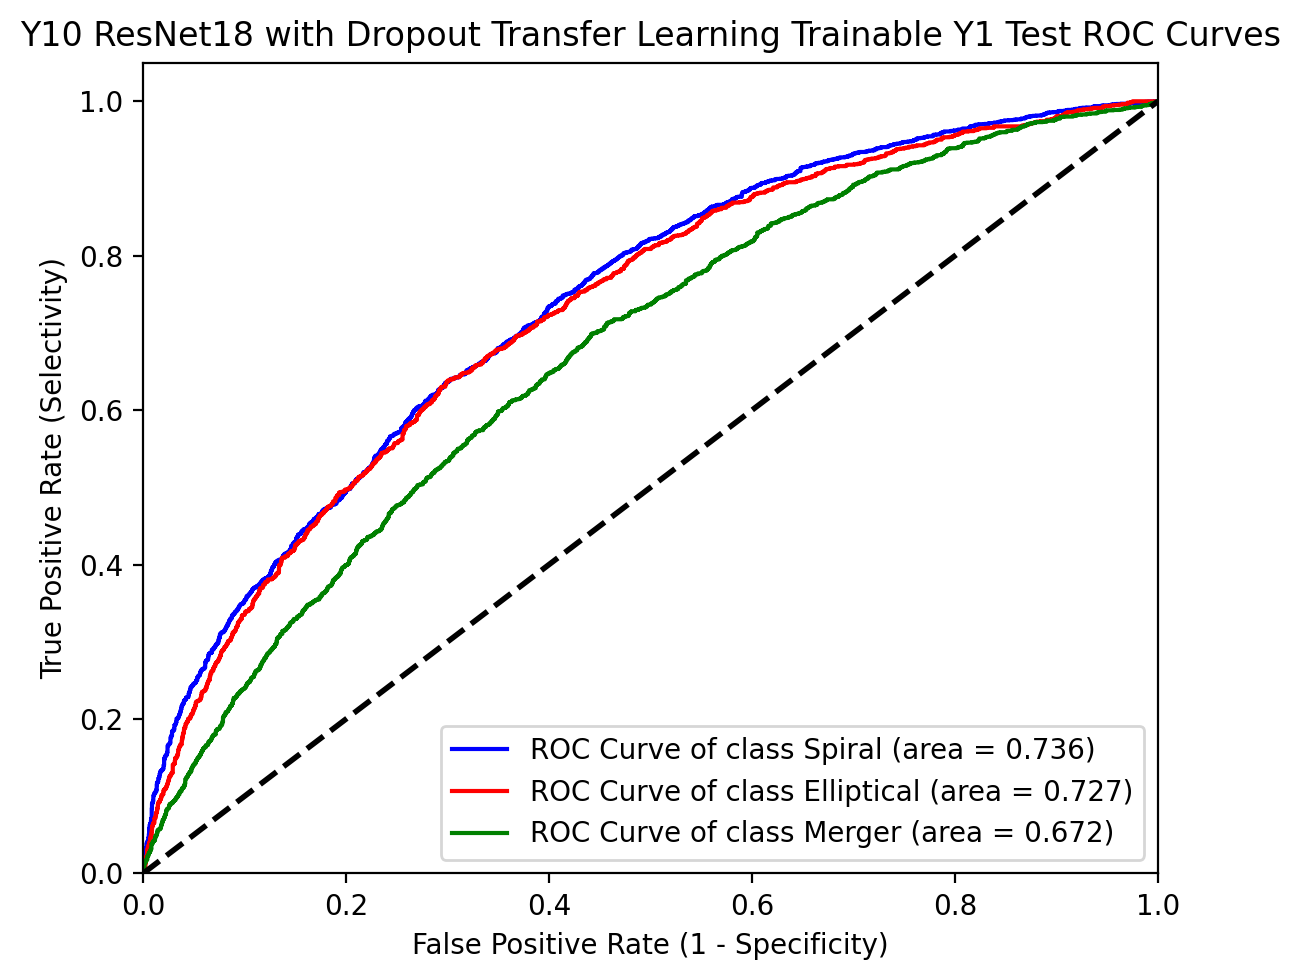

In [40]:
# Re-evaluate on Y1 test data
# Make Classification report, Confusion Matrix, and compute ROC & AUC for each class in each dataset
y_pred = Y10_resnet18_TL_trainable.predict(X_test_1)
        
# Classification report
classification_metrics = classification_report(np.argmax(Y_test, axis=1), 
                                               np.argmax(y_pred, axis=1), 
                                               target_names=class_names)
print("Y1 Test:\n" + classification_metrics + '\n')

# Confusion Matrix
cm = confusion_matrix(np.argmax(Y_test, axis=1), 
                      np.argmax(Y10_resnet18_TL_trainable.predict(X_test_1), axis=1),
                      labels=[0, 1, 2])
cm = cm.astype('float')
cd = ConfusionMatrixDisplay(cm, display_labels=class_names)
cd.plot(values_format='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Y10 ResNet18 with Dropout Transfer Learning Trainable Y1 Test Confusion Matrix')
plt.tight_layout()
plt.savefig('Y10_ResNet18_Dropout_TL_trainable_Y1_test_CM')
plt.show()

## ROC curves & AUC for a categorical classifier
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], thresholds = roc_curve(Y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize = (6, 5), tight_layout=True)
colors = ['blue', 'red', 'green', 'brown', 'purple', 'pink', 'orange', 'black', 'yellow', 'cyan']
for i, color, lbl in zip(range(NUM_CLASSES), colors, class_names):
    plt.plot(fpr[i], tpr[i], color = color, lw = 1.5,
    label = 'ROC Curve of class {0} (area = {1:0.3f})'.format(lbl, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Selectivity)')
plt.legend(loc="lower right")
plt.title('Y10 ResNet18 with Dropout Transfer Learning Trainable Y1 Test ROC Curves')
plt.savefig('Y10_ResNet18_Dropout_TL_trainable_Y1_test_ROC')
plt.show()

210/210 [==============================] - 2s 12ms/step
Y10 Test:
              precision    recall  f1-score   support

      Spiral       0.50      0.87      0.64      2863
  Elliptical       0.48      0.43      0.45      1631
      Merger       0.63      0.08      0.14      2221

    accuracy                           0.50      6715
   macro avg       0.54      0.46      0.41      6715
weighted avg       0.54      0.50      0.43      6715


210/210 [==============================] - 2s 12ms/step


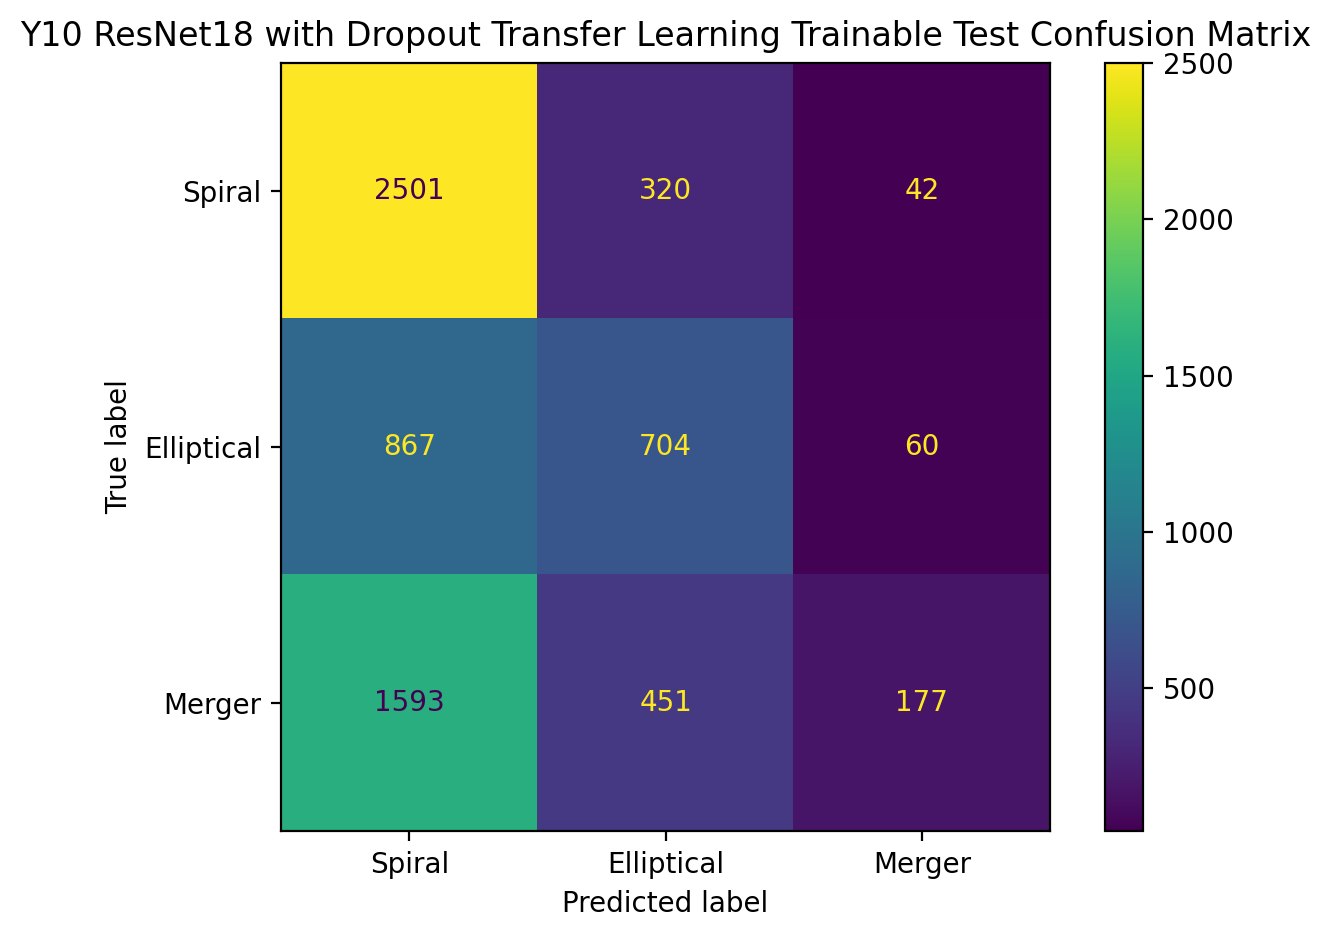

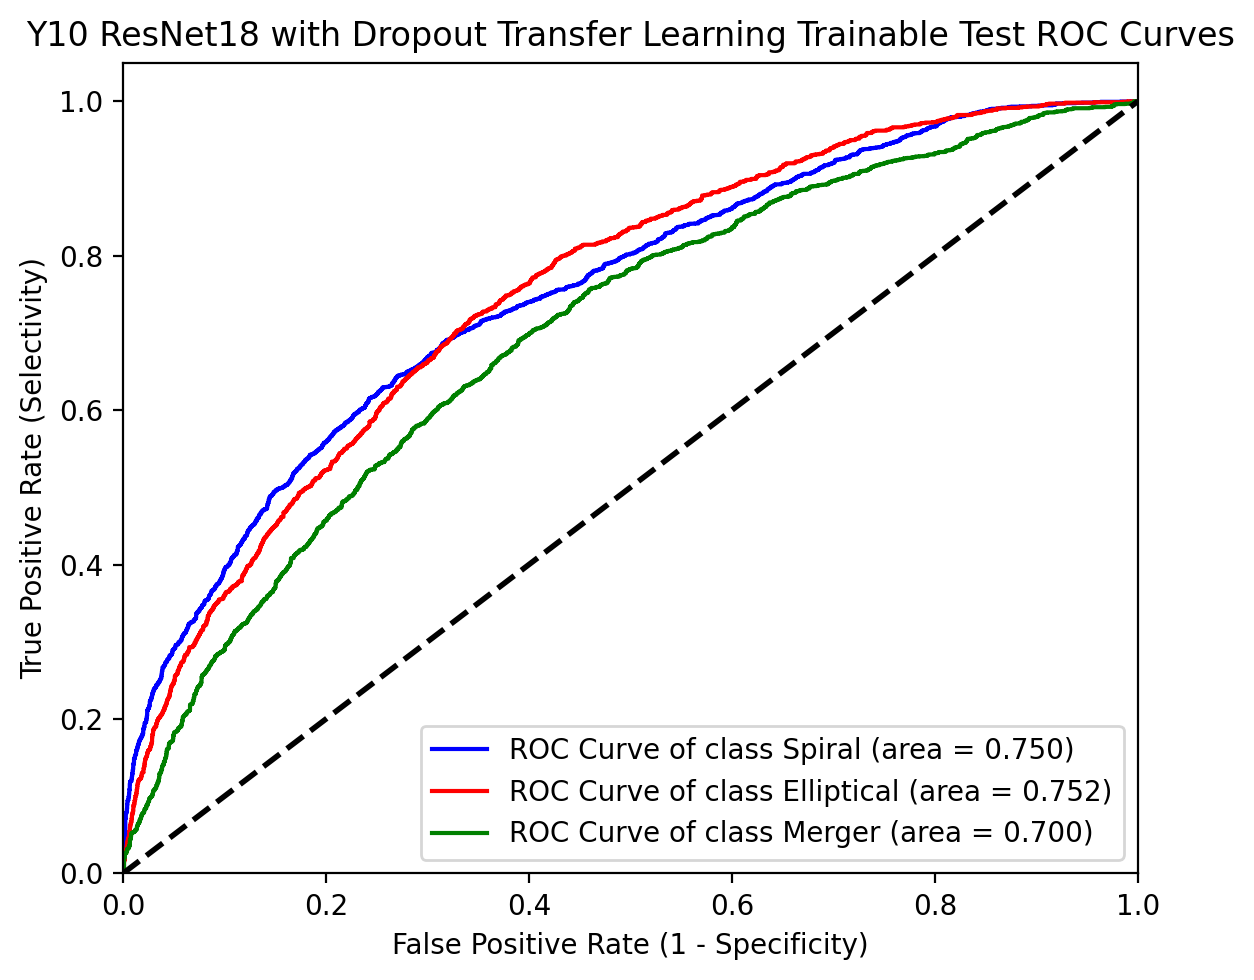

In [41]:
# Re-evaluate on Y10 test data
# Make Classification report, Confusion Matrix, and compute ROC & AUC for each class in each dataset
y_pred = Y10_resnet18_TL_trainable.predict(X_test_10)
        
# Classification report
classification_metrics = classification_report(np.argmax(Y_test, axis=1), 
                                               np.argmax(y_pred, axis=1), 
                                               target_names=class_names)
print("Y10 Test:\n" + classification_metrics + '\n')

# Confusion Matrix
cm = confusion_matrix(np.argmax(Y_test, axis=1), 
                      np.argmax(Y10_resnet18_TL_trainable.predict(X_test_10), axis=1),
                      labels=[0, 1, 2])
cm = cm.astype('float')
cd = ConfusionMatrixDisplay(cm, display_labels=class_names)
cd.plot(values_format='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Y10 ResNet18 with Dropout Transfer Learning Trainable Test Confusion Matrix')
plt.tight_layout()
plt.savefig('Y10_ResNet18_Dropout_TL_trainable_test_CM')
plt.show()

## ROC curves & AUC for a categorical classifier
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], thresholds = roc_curve(Y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize = (6, 5), tight_layout=True)
colors = ['blue', 'red', 'green', 'brown', 'purple', 'pink', 'orange', 'black', 'yellow', 'cyan']
for i, color, lbl in zip(range(NUM_CLASSES), colors, class_names):
    plt.plot(fpr[i], tpr[i], color = color, lw = 1.5,
    label = 'ROC Curve of class {0} (area = {1:0.3f})'.format(lbl, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Selectivity)')
plt.legend(loc="lower right")
plt.title('Y10 ResNet18 with Dropout Transfer Learning Trainable Test ROC Curves')
plt.savefig('Y10_ResNet18_Dropout_TL_trainable_test_ROC')
plt.show()

## Method 2: Try doing Transfer Learning and make all previous layers non-trainable

In [42]:
## Reload a fresh ResNet18 w/ Dropout model from the saved best trained model, compile with same arguments as original
best_model = load_model("Y10_ResNet18_Dropout")

# Check for trainable and non-trainable variables
print("\nBest model has {} trainable variables: {}, ...".format(
          len(best_model.trainable_variables),
          ", ".join([v.name for v in best_model.trainable_variables])))

trainable_variable_ids = {id(v) for v in best_model.trainable_variables}
non_trainable_variables = [v for v in best_model.variables
                           if id(v) not in trainable_variable_ids]
print("\nBest model also has {} non-trainable variables: {}, ...".format(
          len(non_trainable_variables),
          ", ".join([v.name for v in non_trainable_variables])))


Best model has 62 trainable variables: conv1/kernel:0, bn1/gamma:0, bn1/beta:0, layer1.0.conv1/kernel:0, layer1.0.bn1/gamma:0, layer1.0.bn1/beta:0, layer1.0.conv2/kernel:0, layer1.0.bn2/gamma:0, layer1.0.bn2/beta:0, layer1.1.conv1/kernel:0, layer1.1.bn1/gamma:0, layer1.1.bn1/beta:0, layer1.1.conv2/kernel:0, layer1.1.bn2/gamma:0, layer1.1.bn2/beta:0, layer2.0.conv1/kernel:0, layer2.0.bn1/gamma:0, layer2.0.bn1/beta:0, layer2.0.downsample.0/kernel:0, layer2.0.conv2/kernel:0, layer2.0.downsample.1/gamma:0, layer2.0.downsample.1/beta:0, layer2.0.bn2/gamma:0, layer2.0.bn2/beta:0, layer2.1.conv1/kernel:0, layer2.1.bn1/gamma:0, layer2.1.bn1/beta:0, layer2.1.conv2/kernel:0, layer2.1.bn2/gamma:0, layer2.1.bn2/beta:0, layer3.0.conv1/kernel:0, layer3.0.bn1/gamma:0, layer3.0.bn1/beta:0, layer3.0.downsample.0/kernel:0, layer3.0.conv2/kernel:0, layer3.0.downsample.1/gamma:0, layer3.0.downsample.1/beta:0, layer3.0.bn2/gamma:0, layer3.0.bn2/beta:0, layer3.1.conv1/kernel:0, layer3.1.bn1/gamma:0, layer3

In [43]:
# Make last layer the output, freeze previous layers, and initialize new model
for layers in (best_model.layers)[:-4]:
    print(layers)
    layers.trainable = False
    
last = best_model.layers[-4].output
x = Dropout(0.5)(last)
x = GlobalAveragePooling2D(name='avgpool')(x)
outputs = Dense(units=NUM_CLASSES, activation="softmax", name='fc')(x)
Y10_resnet18_TL = Model(inputs = best_model.input, outputs = outputs)

## Compile new Model
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
optimizer = Adam(learning_rate = 1e-7)
Y10_resnet18_TL.compile(loss = loss, optimizer = optimizer, metrics = ['accuracy'])
Y10_resnet18_TL.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 3, 100, 100  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 9, 106, 100)  0           ['input_1[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 2, 50, 64)    313600      ['conv1_pad[0][0]']              
                                                                                                  
 bn1 (BatchNormalization)       (None, 2, 50, 64)    256         ['conv1[0][0]']            

In [44]:
## Define Callback Functions

# Add tensorboard callback and log output folder
log_dir = "Y10_logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + f" {Y10_resnet18_TL.name}"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

es = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5), 
      ModelCheckpoint(filepath='Y10_resnet18_dropout_TL_best_weights', monitor='val_accuracy', 
                      mode='max', verbose=1, save_best_only=True),
      tensorboard_callback,
      ReduceLROnPlateau(monitor='val_loss', mode='min', verbose=1, patience=5, factor=0.1)
      ]

In [45]:
# Train the new layers on the Y1 train dataset
# Set seed for reproducibility
random.seed(0)

## Train Model
batch_size = 128
NUM_EPOCH = 200
history_resnet18_TL = Y10_resnet18_TL.fit(X_train_1, Y_train,
                                            batch_size = batch_size,
                                            epochs = NUM_EPOCH,
                                            validation_data = (X_valid_1, Y_valid),                
                                            shuffle = True,
                                            class_weight = class_weights,
                                            verbose = 1,
                                            callbacks = es
                                            )

Epoch 1/200


2023-01-08 15:20:49.875845: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


184/184 [==============================] - ETA: 0s - loss: 1.9191 - accuracy: 0.3427

2023-01-08 15:21:02.810405: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.33800, saving model to Y10_resnet18_dropout_TL_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


184/184 [==============================] - 25s 121ms/step - loss: 1.9191 - accuracy: 0.3427 - val_loss: 1.8757 - val_accuracy: 0.3380 - lr: 1.0000e-07
Epoch 2/200
184/184 [==============================] - ETA: 0s - loss: 1.9024 - accuracy: 0.3461
Epoch 2: val_accuracy did not improve from 0.33800
184/184 [==============================] - 11s 60ms/step - loss: 1.9024 - accuracy: 0.3461 - val_loss: 1.8675 - val_accuracy: 0.3380 - lr: 1.0000e-07
Epoch 3/200
184/184 [==============================] - ETA: 0s - loss: 1.8969 - accuracy: 0.3430
Epoch 3: val_accuracy did not improve from 0.33800
184/184 [==============================] - 11s 59ms/step - loss: 1.8969 - accuracy: 0.3430 - val_loss: 1.8592 - val_accuracy: 0.3377 - lr: 1.0000e-07
Epoch 4/200
184/184 [==============================] - ETA: 0s - loss: 1.8798 - accuracy: 0.3456
Epoch 4: val_accuracy did not improve from 0.33800
184/184 [==============================] - 11s 60ms/step - loss: 1.8798 - accuracy: 0.3456 - val_loss: 1.

INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


184/184 [==============================] - 18s 96ms/step - loss: 1.8751 - accuracy: 0.3461 - val_loss: 1.8349 - val_accuracy: 0.3383 - lr: 1.0000e-07
Epoch 7/200
184/184 [==============================] - ETA: 0s - loss: 1.8749 - accuracy: 0.3456
Epoch 7: val_accuracy improved from 0.33830 to 0.33920, saving model to Y10_resnet18_dropout_TL_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


184/184 [==============================] - 17s 93ms/step - loss: 1.8749 - accuracy: 0.3456 - val_loss: 1.8270 - val_accuracy: 0.3392 - lr: 1.0000e-07
Epoch 8/200
184/184 [==============================] - ETA: 0s - loss: 1.8641 - accuracy: 0.3472
Epoch 8: val_accuracy improved from 0.33920 to 0.33979, saving model to Y10_resnet18_dropout_TL_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


184/184 [==============================] - 17s 91ms/step - loss: 1.8641 - accuracy: 0.3472 - val_loss: 1.8191 - val_accuracy: 0.3398 - lr: 1.0000e-07
Epoch 9/200
184/184 [==============================] - ETA: 0s - loss: 1.8588 - accuracy: 0.3441
Epoch 9: val_accuracy improved from 0.33979 to 0.34009, saving model to Y10_resnet18_dropout_TL_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


184/184 [==============================] - 19s 102ms/step - loss: 1.8588 - accuracy: 0.3441 - val_loss: 1.8113 - val_accuracy: 0.3401 - lr: 1.0000e-07
Epoch 10/200
184/184 [==============================] - ETA: 0s - loss: 1.8421 - accuracy: 0.3475
Epoch 10: val_accuracy improved from 0.34009 to 0.34039, saving model to Y10_resnet18_dropout_TL_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


184/184 [==============================] - 16s 90ms/step - loss: 1.8421 - accuracy: 0.3475 - val_loss: 1.8036 - val_accuracy: 0.3404 - lr: 1.0000e-07
Epoch 11/200
184/184 [==============================] - ETA: 0s - loss: 1.8458 - accuracy: 0.3486
Epoch 11: val_accuracy improved from 0.34039 to 0.34098, saving model to Y10_resnet18_dropout_TL_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


184/184 [==============================] - 18s 96ms/step - loss: 1.8458 - accuracy: 0.3486 - val_loss: 1.7958 - val_accuracy: 0.3410 - lr: 1.0000e-07
Epoch 12/200
184/184 [==============================] - ETA: 0s - loss: 1.8385 - accuracy: 0.3479
Epoch 12: val_accuracy improved from 0.34098 to 0.34158, saving model to Y10_resnet18_dropout_TL_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


184/184 [==============================] - 17s 90ms/step - loss: 1.8385 - accuracy: 0.3479 - val_loss: 1.7881 - val_accuracy: 0.3416 - lr: 1.0000e-07
Epoch 13/200
184/184 [==============================] - ETA: 0s - loss: 1.8240 - accuracy: 0.3482
Epoch 13: val_accuracy improved from 0.34158 to 0.34277, saving model to Y10_resnet18_dropout_TL_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


184/184 [==============================] - 18s 97ms/step - loss: 1.8240 - accuracy: 0.3482 - val_loss: 1.7805 - val_accuracy: 0.3428 - lr: 1.0000e-07
Epoch 14/200
184/184 [==============================] - ETA: 0s - loss: 1.8194 - accuracy: 0.3479
Epoch 14: val_accuracy did not improve from 0.34277
184/184 [==============================] - 11s 59ms/step - loss: 1.8194 - accuracy: 0.3479 - val_loss: 1.7729 - val_accuracy: 0.3425 - lr: 1.0000e-07
Epoch 15/200
184/184 [==============================] - ETA: 0s - loss: 1.8094 - accuracy: 0.3468
Epoch 15: val_accuracy did not improve from 0.34277
184/184 [==============================] - 11s 58ms/step - loss: 1.8094 - accuracy: 0.3468 - val_loss: 1.7655 - val_accuracy: 0.3419 - lr: 1.0000e-07
Epoch 16/200
184/184 [==============================] - ETA: 0s - loss: 1.8113 - accuracy: 0.3491
Epoch 16: val_accuracy did not improve from 0.34277
184/184 [==============================] - 11s 58ms/step - loss: 1.8113 - accuracy: 0.3491 - val_los

INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


184/184 [==============================] - 19s 105ms/step - loss: 1.7376 - accuracy: 0.3502 - val_loss: 1.6870 - val_accuracy: 0.3434 - lr: 1.0000e-07
Epoch 27/200
184/184 [==============================] - ETA: 0s - loss: 1.7390 - accuracy: 0.3511
Epoch 27: val_accuracy did not improve from 0.34337
184/184 [==============================] - 12s 63ms/step - loss: 1.7390 - accuracy: 0.3511 - val_loss: 1.6802 - val_accuracy: 0.3434 - lr: 1.0000e-07
Epoch 28/200
184/184 [==============================] - ETA: 0s - loss: 1.7425 - accuracy: 0.3495
Epoch 28: val_accuracy improved from 0.34337 to 0.34396, saving model to Y10_resnet18_dropout_TL_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


184/184 [==============================] - 18s 99ms/step - loss: 1.7425 - accuracy: 0.3495 - val_loss: 1.6735 - val_accuracy: 0.3440 - lr: 1.0000e-07
Epoch 29/200
184/184 [==============================] - ETA: 0s - loss: 1.7133 - accuracy: 0.3507
Epoch 29: val_accuracy did not improve from 0.34396
184/184 [==============================] - 11s 60ms/step - loss: 1.7133 - accuracy: 0.3507 - val_loss: 1.6668 - val_accuracy: 0.3440 - lr: 1.0000e-07
Epoch 30/200
184/184 [==============================] - ETA: 0s - loss: 1.7288 - accuracy: 0.3485
Epoch 30: val_accuracy improved from 0.34396 to 0.34456, saving model to Y10_resnet18_dropout_TL_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


184/184 [==============================] - 17s 90ms/step - loss: 1.7288 - accuracy: 0.3485 - val_loss: 1.6602 - val_accuracy: 0.3446 - lr: 1.0000e-07
Epoch 31/200
184/184 [==============================] - ETA: 0s - loss: 1.7210 - accuracy: 0.3476
Epoch 31: val_accuracy did not improve from 0.34456
184/184 [==============================] - 11s 60ms/step - loss: 1.7210 - accuracy: 0.3476 - val_loss: 1.6536 - val_accuracy: 0.3440 - lr: 1.0000e-07
Epoch 32/200
184/184 [==============================] - ETA: 0s - loss: 1.7078 - accuracy: 0.3490
Epoch 32: val_accuracy did not improve from 0.34456
184/184 [==============================] - 11s 59ms/step - loss: 1.7078 - accuracy: 0.3490 - val_loss: 1.6470 - val_accuracy: 0.3446 - lr: 1.0000e-07
Epoch 33/200
184/184 [==============================] - ETA: 0s - loss: 1.7019 - accuracy: 0.3482
Epoch 33: val_accuracy did not improve from 0.34456
184/184 [==============================] - 11s 58ms/step - loss: 1.7019 - accuracy: 0.3482 - val_los

INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


184/184 [==============================] - 18s 99ms/step - loss: 1.6979 - accuracy: 0.3470 - val_loss: 1.6280 - val_accuracy: 0.3452 - lr: 1.0000e-07
Epoch 36/200
184/184 [==============================] - ETA: 0s - loss: 1.6891 - accuracy: 0.3549
Epoch 36: val_accuracy did not improve from 0.34516
184/184 [==============================] - 11s 60ms/step - loss: 1.6891 - accuracy: 0.3549 - val_loss: 1.6216 - val_accuracy: 0.3452 - lr: 1.0000e-07
Epoch 37/200
184/184 [==============================] - ETA: 0s - loss: 1.6844 - accuracy: 0.3520
Epoch 37: val_accuracy improved from 0.34516 to 0.34605, saving model to Y10_resnet18_dropout_TL_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


184/184 [==============================] - 18s 99ms/step - loss: 1.6844 - accuracy: 0.3520 - val_loss: 1.6155 - val_accuracy: 0.3461 - lr: 1.0000e-07
Epoch 38/200
184/184 [==============================] - ETA: 0s - loss: 1.6758 - accuracy: 0.3516
Epoch 38: val_accuracy improved from 0.34605 to 0.34635, saving model to Y10_resnet18_dropout_TL_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


184/184 [==============================] - 17s 95ms/step - loss: 1.6758 - accuracy: 0.3516 - val_loss: 1.6094 - val_accuracy: 0.3463 - lr: 1.0000e-07
Epoch 39/200
184/184 [==============================] - ETA: 0s - loss: 1.6704 - accuracy: 0.3544
Epoch 39: val_accuracy did not improve from 0.34635
184/184 [==============================] - 11s 61ms/step - loss: 1.6704 - accuracy: 0.3544 - val_loss: 1.6033 - val_accuracy: 0.3461 - lr: 1.0000e-07
Epoch 40/200
184/184 [==============================] - ETA: 0s - loss: 1.6640 - accuracy: 0.3563
Epoch 40: val_accuracy improved from 0.34635 to 0.34694, saving model to Y10_resnet18_dropout_TL_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


184/184 [==============================] - 18s 100ms/step - loss: 1.6640 - accuracy: 0.3563 - val_loss: 1.5972 - val_accuracy: 0.3469 - lr: 1.0000e-07
Epoch 41/200
184/184 [==============================] - ETA: 0s - loss: 1.6710 - accuracy: 0.3501
Epoch 41: val_accuracy did not improve from 0.34694
184/184 [==============================] - 11s 61ms/step - loss: 1.6710 - accuracy: 0.3501 - val_loss: 1.5912 - val_accuracy: 0.3466 - lr: 1.0000e-07
Epoch 42/200
184/184 [==============================] - ETA: 0s - loss: 1.6584 - accuracy: 0.3527
Epoch 42: val_accuracy improved from 0.34694 to 0.34724, saving model to Y10_resnet18_dropout_TL_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


184/184 [==============================] - 17s 92ms/step - loss: 1.6584 - accuracy: 0.3527 - val_loss: 1.5853 - val_accuracy: 0.3472 - lr: 1.0000e-07
Epoch 43/200
184/184 [==============================] - ETA: 0s - loss: 1.6502 - accuracy: 0.3538
Epoch 43: val_accuracy improved from 0.34724 to 0.34844, saving model to Y10_resnet18_dropout_TL_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


184/184 [==============================] - 18s 99ms/step - loss: 1.6502 - accuracy: 0.3538 - val_loss: 1.5795 - val_accuracy: 0.3484 - lr: 1.0000e-07
Epoch 44/200
184/184 [==============================] - ETA: 0s - loss: 1.6418 - accuracy: 0.3530
Epoch 44: val_accuracy improved from 0.34844 to 0.34873, saving model to Y10_resnet18_dropout_TL_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


184/184 [==============================] - 17s 90ms/step - loss: 1.6418 - accuracy: 0.3530 - val_loss: 1.5738 - val_accuracy: 0.3487 - lr: 1.0000e-07
Epoch 45/200
184/184 [==============================] - ETA: 0s - loss: 1.6409 - accuracy: 0.3541
Epoch 45: val_accuracy did not improve from 0.34873
184/184 [==============================] - 11s 59ms/step - loss: 1.6409 - accuracy: 0.3541 - val_loss: 1.5680 - val_accuracy: 0.3478 - lr: 1.0000e-07
Epoch 46/200
184/184 [==============================] - ETA: 0s - loss: 1.6366 - accuracy: 0.3551
Epoch 46: val_accuracy improved from 0.34873 to 0.34933, saving model to Y10_resnet18_dropout_TL_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


184/184 [==============================] - 18s 98ms/step - loss: 1.6366 - accuracy: 0.3551 - val_loss: 1.5624 - val_accuracy: 0.3493 - lr: 1.0000e-07
Epoch 47/200
184/184 [==============================] - ETA: 0s - loss: 1.6243 - accuracy: 0.3562
Epoch 47: val_accuracy improved from 0.34933 to 0.35082, saving model to Y10_resnet18_dropout_TL_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


184/184 [==============================] - 17s 92ms/step - loss: 1.6243 - accuracy: 0.3562 - val_loss: 1.5568 - val_accuracy: 0.3508 - lr: 1.0000e-07
Epoch 48/200
184/184 [==============================] - ETA: 0s - loss: 1.6282 - accuracy: 0.3568
Epoch 48: val_accuracy improved from 0.35082 to 0.35142, saving model to Y10_resnet18_dropout_TL_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


184/184 [==============================] - 18s 98ms/step - loss: 1.6282 - accuracy: 0.3568 - val_loss: 1.5513 - val_accuracy: 0.3514 - lr: 1.0000e-07
Epoch 49/200
184/184 [==============================] - ETA: 0s - loss: 1.6023 - accuracy: 0.3575
Epoch 49: val_accuracy improved from 0.35142 to 0.35171, saving model to Y10_resnet18_dropout_TL_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


184/184 [==============================] - 17s 92ms/step - loss: 1.6023 - accuracy: 0.3575 - val_loss: 1.5458 - val_accuracy: 0.3517 - lr: 1.0000e-07
Epoch 50/200
184/184 [==============================] - ETA: 0s - loss: 1.6109 - accuracy: 0.3567
Epoch 50: val_accuracy did not improve from 0.35171
184/184 [==============================] - 11s 61ms/step - loss: 1.6109 - accuracy: 0.3567 - val_loss: 1.5403 - val_accuracy: 0.3517 - lr: 1.0000e-07
Epoch 51/200
184/184 [==============================] - ETA: 0s - loss: 1.6113 - accuracy: 0.3574
Epoch 51: val_accuracy improved from 0.35171 to 0.35201, saving model to Y10_resnet18_dropout_TL_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


184/184 [==============================] - 18s 99ms/step - loss: 1.6113 - accuracy: 0.3574 - val_loss: 1.5350 - val_accuracy: 0.3520 - lr: 1.0000e-07
Epoch 52/200
184/184 [==============================] - ETA: 0s - loss: 1.6046 - accuracy: 0.3554
Epoch 52: val_accuracy did not improve from 0.35201
184/184 [==============================] - 11s 60ms/step - loss: 1.6046 - accuracy: 0.3554 - val_loss: 1.5297 - val_accuracy: 0.3505 - lr: 1.0000e-07
Epoch 53/200
184/184 [==============================] - ETA: 0s - loss: 1.6047 - accuracy: 0.3554
Epoch 53: val_accuracy did not improve from 0.35201
184/184 [==============================] - 11s 59ms/step - loss: 1.6047 - accuracy: 0.3554 - val_loss: 1.5244 - val_accuracy: 0.3514 - lr: 1.0000e-07
Epoch 54/200
184/184 [==============================] - ETA: 0s - loss: 1.5970 - accuracy: 0.3528
Epoch 54: val_accuracy improved from 0.35201 to 0.35231, saving model to Y10_resnet18_dropout_TL_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


184/184 [==============================] - 17s 92ms/step - loss: 1.5970 - accuracy: 0.3528 - val_loss: 1.5192 - val_accuracy: 0.3523 - lr: 1.0000e-07
Epoch 55/200
184/184 [==============================] - ETA: 0s - loss: 1.5972 - accuracy: 0.3548
Epoch 55: val_accuracy improved from 0.35231 to 0.35410, saving model to Y10_resnet18_dropout_TL_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


184/184 [==============================] - 18s 97ms/step - loss: 1.5972 - accuracy: 0.3548 - val_loss: 1.5141 - val_accuracy: 0.3541 - lr: 1.0000e-07
Epoch 56/200
184/184 [==============================] - ETA: 0s - loss: 1.5780 - accuracy: 0.3596
Epoch 56: val_accuracy improved from 0.35410 to 0.35529, saving model to Y10_resnet18_dropout_TL_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


184/184 [==============================] - 18s 95ms/step - loss: 1.5780 - accuracy: 0.3596 - val_loss: 1.5091 - val_accuracy: 0.3553 - lr: 1.0000e-07
Epoch 57/200
184/184 [==============================] - ETA: 0s - loss: 1.5850 - accuracy: 0.3533
Epoch 57: val_accuracy improved from 0.35529 to 0.35589, saving model to Y10_resnet18_dropout_TL_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


184/184 [==============================] - 17s 90ms/step - loss: 1.5850 - accuracy: 0.3533 - val_loss: 1.5041 - val_accuracy: 0.3559 - lr: 1.0000e-07
Epoch 58/200
184/184 [==============================] - ETA: 0s - loss: 1.5755 - accuracy: 0.3582
Epoch 58: val_accuracy improved from 0.35589 to 0.35648, saving model to Y10_resnet18_dropout_TL_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


184/184 [==============================] - 18s 98ms/step - loss: 1.5755 - accuracy: 0.3582 - val_loss: 1.4992 - val_accuracy: 0.3565 - lr: 1.0000e-07
Epoch 59/200
184/184 [==============================] - ETA: 0s - loss: 1.5853 - accuracy: 0.3541
Epoch 59: val_accuracy improved from 0.35648 to 0.35678, saving model to Y10_resnet18_dropout_TL_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


184/184 [==============================] - 17s 90ms/step - loss: 1.5853 - accuracy: 0.3541 - val_loss: 1.4943 - val_accuracy: 0.3568 - lr: 1.0000e-07
Epoch 60/200
184/184 [==============================] - ETA: 0s - loss: 1.5777 - accuracy: 0.3573
Epoch 60: val_accuracy did not improve from 0.35678
184/184 [==============================] - 11s 60ms/step - loss: 1.5777 - accuracy: 0.3573 - val_loss: 1.4896 - val_accuracy: 0.3565 - lr: 1.0000e-07
Epoch 61/200
184/184 [==============================] - ETA: 0s - loss: 1.5592 - accuracy: 0.3607
Epoch 61: val_accuracy improved from 0.35678 to 0.35738, saving model to Y10_resnet18_dropout_TL_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


184/184 [==============================] - 18s 96ms/step - loss: 1.5592 - accuracy: 0.3607 - val_loss: 1.4849 - val_accuracy: 0.3574 - lr: 1.0000e-07
Epoch 62/200
184/184 [==============================] - ETA: 0s - loss: 1.5605 - accuracy: 0.3601
Epoch 62: val_accuracy improved from 0.35738 to 0.35917, saving model to Y10_resnet18_dropout_TL_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


184/184 [==============================] - 18s 100ms/step - loss: 1.5605 - accuracy: 0.3601 - val_loss: 1.4802 - val_accuracy: 0.3592 - lr: 1.0000e-07
Epoch 63/200
184/184 [==============================] - ETA: 0s - loss: 1.5674 - accuracy: 0.3589
Epoch 63: val_accuracy did not improve from 0.35917
184/184 [==============================] - 11s 61ms/step - loss: 1.5674 - accuracy: 0.3589 - val_loss: 1.4756 - val_accuracy: 0.3592 - lr: 1.0000e-07
Epoch 64/200
184/184 [==============================] - ETA: 0s - loss: 1.5634 - accuracy: 0.3605
Epoch 64: val_accuracy improved from 0.35917 to 0.36006, saving model to Y10_resnet18_dropout_TL_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


184/184 [==============================] - 17s 93ms/step - loss: 1.5634 - accuracy: 0.3605 - val_loss: 1.4710 - val_accuracy: 0.3601 - lr: 1.0000e-07
Epoch 65/200
184/184 [==============================] - ETA: 0s - loss: 1.5502 - accuracy: 0.3593
Epoch 65: val_accuracy improved from 0.36006 to 0.36036, saving model to Y10_resnet18_dropout_TL_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


184/184 [==============================] - 18s 100ms/step - loss: 1.5502 - accuracy: 0.3593 - val_loss: 1.4666 - val_accuracy: 0.3604 - lr: 1.0000e-07
Epoch 66/200
184/184 [==============================] - ETA: 0s - loss: 1.5472 - accuracy: 0.3585
Epoch 66: val_accuracy did not improve from 0.36036
184/184 [==============================] - 12s 64ms/step - loss: 1.5472 - accuracy: 0.3585 - val_loss: 1.4621 - val_accuracy: 0.3601 - lr: 1.0000e-07
Epoch 67/200
184/184 [==============================] - ETA: 0s - loss: 1.5478 - accuracy: 0.3565
Epoch 67: val_accuracy did not improve from 0.36036
184/184 [==============================] - 11s 60ms/step - loss: 1.5478 - accuracy: 0.3565 - val_loss: 1.4578 - val_accuracy: 0.3586 - lr: 1.0000e-07
Epoch 68/200
184/184 [==============================] - ETA: 0s - loss: 1.5497 - accuracy: 0.3570
Epoch 68: val_accuracy did not improve from 0.36036
184/184 [==============================] - 11s 61ms/step - loss: 1.5497 - accuracy: 0.3570 - val_lo

INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


184/184 [==============================] - 17s 93ms/step - loss: 1.5433 - accuracy: 0.3588 - val_loss: 1.4450 - val_accuracy: 0.3615 - lr: 1.0000e-07
Epoch 71/200
184/184 [==============================] - ETA: 0s - loss: 1.5279 - accuracy: 0.3614
Epoch 71: val_accuracy improved from 0.36155 to 0.36185, saving model to Y10_resnet18_dropout_TL_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


184/184 [==============================] - 18s 100ms/step - loss: 1.5279 - accuracy: 0.3614 - val_loss: 1.4409 - val_accuracy: 0.3618 - lr: 1.0000e-07
Epoch 72/200
184/184 [==============================] - ETA: 0s - loss: 1.5183 - accuracy: 0.3602
Epoch 72: val_accuracy did not improve from 0.36185
184/184 [==============================] - 11s 60ms/step - loss: 1.5183 - accuracy: 0.3602 - val_loss: 1.4368 - val_accuracy: 0.3618 - lr: 1.0000e-07
Epoch 73/200
184/184 [==============================] - ETA: 0s - loss: 1.5181 - accuracy: 0.3630
Epoch 73: val_accuracy improved from 0.36185 to 0.36244, saving model to Y10_resnet18_dropout_TL_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


184/184 [==============================] - 17s 93ms/step - loss: 1.5181 - accuracy: 0.3630 - val_loss: 1.4328 - val_accuracy: 0.3624 - lr: 1.0000e-07
Epoch 74/200
184/184 [==============================] - ETA: 0s - loss: 1.5151 - accuracy: 0.3622
Epoch 74: val_accuracy did not improve from 0.36244
184/184 [==============================] - 11s 61ms/step - loss: 1.5151 - accuracy: 0.3622 - val_loss: 1.4289 - val_accuracy: 0.3618 - lr: 1.0000e-07
Epoch 75/200
184/184 [==============================] - ETA: 0s - loss: 1.5126 - accuracy: 0.3595
Epoch 75: val_accuracy did not improve from 0.36244
184/184 [==============================] - 11s 60ms/step - loss: 1.5126 - accuracy: 0.3595 - val_loss: 1.4250 - val_accuracy: 0.3624 - lr: 1.0000e-07
Epoch 76/200
184/184 [==============================] - ETA: 0s - loss: 1.5048 - accuracy: 0.3599
Epoch 76: val_accuracy did not improve from 0.36244
184/184 [==============================] - 11s 60ms/step - loss: 1.5048 - accuracy: 0.3599 - val_los

INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


184/184 [==============================] - 18s 100ms/step - loss: 1.4965 - accuracy: 0.3628 - val_loss: 1.3995 - val_accuracy: 0.3630 - lr: 1.0000e-07
Epoch 83/200
184/184 [==============================] - ETA: 0s - loss: 1.4880 - accuracy: 0.3606
Epoch 83: val_accuracy did not improve from 0.36304
184/184 [==============================] - 11s 60ms/step - loss: 1.4880 - accuracy: 0.3606 - val_loss: 1.3961 - val_accuracy: 0.3618 - lr: 1.0000e-07
Epoch 84/200
184/184 [==============================] - ETA: 0s - loss: 1.4887 - accuracy: 0.3629
Epoch 84: val_accuracy did not improve from 0.36304
184/184 [==============================] - 11s 59ms/step - loss: 1.4887 - accuracy: 0.3629 - val_loss: 1.3927 - val_accuracy: 0.3615 - lr: 1.0000e-07
Epoch 85/200
184/184 [==============================] - ETA: 0s - loss: 1.4835 - accuracy: 0.3647
Epoch 85: val_accuracy did not improve from 0.36304
184/184 [==============================] - 11s 59ms/step - loss: 1.4835 - accuracy: 0.3647 - val_lo

INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


184/184 [==============================] - 17s 90ms/step - loss: 1.4141 - accuracy: 0.3679 - val_loss: 1.3025 - val_accuracy: 0.3633 - lr: 1.0000e-07
Epoch 123/200
184/184 [==============================] - ETA: 0s - loss: 1.4169 - accuracy: 0.3727
Epoch 123: val_accuracy improved from 0.36334 to 0.36393, saving model to Y10_resnet18_dropout_TL_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


184/184 [==============================] - 18s 96ms/step - loss: 1.4169 - accuracy: 0.3727 - val_loss: 1.3010 - val_accuracy: 0.3639 - lr: 1.0000e-07
Epoch 124/200
184/184 [==============================] - ETA: 0s - loss: 1.4091 - accuracy: 0.3695
Epoch 124: val_accuracy did not improve from 0.36393
184/184 [==============================] - 11s 59ms/step - loss: 1.4091 - accuracy: 0.3695 - val_loss: 1.2995 - val_accuracy: 0.3630 - lr: 1.0000e-07
Epoch 125/200
184/184 [==============================] - ETA: 0s - loss: 1.4134 - accuracy: 0.3670
Epoch 125: val_accuracy did not improve from 0.36393
184/184 [==============================] - 11s 58ms/step - loss: 1.4134 - accuracy: 0.3670 - val_loss: 1.2980 - val_accuracy: 0.3639 - lr: 1.0000e-07
Epoch 126/200
184/184 [==============================] - ETA: 0s - loss: 1.3980 - accuracy: 0.3756
Epoch 126: val_accuracy improved from 0.36393 to 0.36602, saving model to Y10_resnet18_dropout_TL_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


184/184 [==============================] - 16s 89ms/step - loss: 1.3980 - accuracy: 0.3756 - val_loss: 1.2966 - val_accuracy: 0.3660 - lr: 1.0000e-07
Epoch 127/200
184/184 [==============================] - ETA: 0s - loss: 1.4009 - accuracy: 0.3731
Epoch 127: val_accuracy did not improve from 0.36602
184/184 [==============================] - 11s 58ms/step - loss: 1.4009 - accuracy: 0.3731 - val_loss: 1.2952 - val_accuracy: 0.3660 - lr: 1.0000e-07
Epoch 128/200
184/184 [==============================] - ETA: 0s - loss: 1.4117 - accuracy: 0.3676
Epoch 128: val_accuracy did not improve from 0.36602
184/184 [==============================] - 11s 58ms/step - loss: 1.4117 - accuracy: 0.3676 - val_loss: 1.2938 - val_accuracy: 0.3660 - lr: 1.0000e-07
Epoch 129/200
184/184 [==============================] - ETA: 0s - loss: 1.4084 - accuracy: 0.3694
Epoch 129: val_accuracy did not improve from 0.36602
184/184 [==============================] - 11s 58ms/step - loss: 1.4084 - accuracy: 0.3694 - v

INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


184/184 [==============================] - 18s 96ms/step - loss: 1.4021 - accuracy: 0.3741 - val_loss: 1.2912 - val_accuracy: 0.3675 - lr: 1.0000e-07
Epoch 131/200
184/184 [==============================] - ETA: 0s - loss: 1.4057 - accuracy: 0.3711
Epoch 131: val_accuracy did not improve from 0.36751
184/184 [==============================] - 11s 58ms/step - loss: 1.4057 - accuracy: 0.3711 - val_loss: 1.2899 - val_accuracy: 0.3672 - lr: 1.0000e-07
Epoch 132/200
184/184 [==============================] - ETA: 0s - loss: 1.3947 - accuracy: 0.3780
Epoch 132: val_accuracy improved from 0.36751 to 0.36811, saving model to Y10_resnet18_dropout_TL_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


184/184 [==============================] - 17s 93ms/step - loss: 1.3947 - accuracy: 0.3780 - val_loss: 1.2886 - val_accuracy: 0.3681 - lr: 1.0000e-07
Epoch 133/200
184/184 [==============================] - ETA: 0s - loss: 1.3994 - accuracy: 0.3739
Epoch 133: val_accuracy improved from 0.36811 to 0.36841, saving model to Y10_resnet18_dropout_TL_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


184/184 [==============================] - 17s 91ms/step - loss: 1.3994 - accuracy: 0.3739 - val_loss: 1.2874 - val_accuracy: 0.3684 - lr: 1.0000e-07
Epoch 134/200
184/184 [==============================] - ETA: 0s - loss: 1.3950 - accuracy: 0.3768
Epoch 134: val_accuracy improved from 0.36841 to 0.36930, saving model to Y10_resnet18_dropout_TL_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


184/184 [==============================] - 18s 98ms/step - loss: 1.3950 - accuracy: 0.3768 - val_loss: 1.2861 - val_accuracy: 0.3693 - lr: 1.0000e-07
Epoch 135/200
184/184 [==============================] - ETA: 0s - loss: 1.3984 - accuracy: 0.3761
Epoch 135: val_accuracy did not improve from 0.36930
184/184 [==============================] - 12s 63ms/step - loss: 1.3984 - accuracy: 0.3761 - val_loss: 1.2850 - val_accuracy: 0.3678 - lr: 1.0000e-07
Epoch 136/200
184/184 [==============================] - ETA: 0s - loss: 1.3924 - accuracy: 0.3753
Epoch 136: val_accuracy did not improve from 0.36930
184/184 [==============================] - 11s 62ms/step - loss: 1.3924 - accuracy: 0.3753 - val_loss: 1.2839 - val_accuracy: 0.3669 - lr: 1.0000e-07
Epoch 137/200
184/184 [==============================] - ETA: 0s - loss: 1.3801 - accuracy: 0.3765
Epoch 137: val_accuracy did not improve from 0.36930
184/184 [==============================] - 11s 60ms/step - loss: 1.3801 - accuracy: 0.3765 - v

INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


184/184 [==============================] - 17s 92ms/step - loss: 1.3898 - accuracy: 0.3737 - val_loss: 1.2634 - val_accuracy: 0.3696 - lr: 1.0000e-07
Epoch 161/200
184/184 [==============================] - ETA: 0s - loss: 1.3844 - accuracy: 0.3768
Epoch 161: val_accuracy did not improve from 0.36960
184/184 [==============================] - 11s 59ms/step - loss: 1.3844 - accuracy: 0.3768 - val_loss: 1.2627 - val_accuracy: 0.3687 - lr: 1.0000e-07
Epoch 162/200
184/184 [==============================] - ETA: 0s - loss: 1.3857 - accuracy: 0.3794
Epoch 162: val_accuracy improved from 0.36960 to 0.37019, saving model to Y10_resnet18_dropout_TL_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


184/184 [==============================] - 18s 96ms/step - loss: 1.3857 - accuracy: 0.3794 - val_loss: 1.2620 - val_accuracy: 0.3702 - lr: 1.0000e-07
Epoch 163/200
184/184 [==============================] - ETA: 0s - loss: 1.3773 - accuracy: 0.3784
Epoch 163: val_accuracy did not improve from 0.37019
184/184 [==============================] - 11s 58ms/step - loss: 1.3773 - accuracy: 0.3784 - val_loss: 1.2614 - val_accuracy: 0.3702 - lr: 1.0000e-07
Epoch 164/200
184/184 [==============================] - ETA: 0s - loss: 1.3836 - accuracy: 0.3773
Epoch 164: val_accuracy did not improve from 0.37019
184/184 [==============================] - 11s 58ms/step - loss: 1.3836 - accuracy: 0.3773 - val_loss: 1.2608 - val_accuracy: 0.3702 - lr: 1.0000e-07
Epoch 165/200
184/184 [==============================] - ETA: 0s - loss: 1.3831 - accuracy: 0.3782
Epoch 165: val_accuracy improved from 0.37019 to 0.37049, saving model to Y10_resnet18_dropout_TL_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


184/184 [==============================] - 16s 89ms/step - loss: 1.3831 - accuracy: 0.3782 - val_loss: 1.2603 - val_accuracy: 0.3705 - lr: 1.0000e-07
Epoch 166/200
184/184 [==============================] - ETA: 0s - loss: 1.3818 - accuracy: 0.3803
Epoch 166: val_accuracy did not improve from 0.37049
184/184 [==============================] - 11s 59ms/step - loss: 1.3818 - accuracy: 0.3803 - val_loss: 1.2597 - val_accuracy: 0.3702 - lr: 1.0000e-07
Epoch 167/200
184/184 [==============================] - ETA: 0s - loss: 1.3812 - accuracy: 0.3780
Epoch 167: val_accuracy improved from 0.37049 to 0.37139, saving model to Y10_resnet18_dropout_TL_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_dropout_TL_best_weights/assets


184/184 [==============================] - 17s 92ms/step - loss: 1.3812 - accuracy: 0.3780 - val_loss: 1.2592 - val_accuracy: 0.3714 - lr: 1.0000e-07
Epoch 168/200
 76/184 [===========>..................] - ETA: 53:52 - loss: 1.3877 - accuracy: 0.3779

In [ ]:
%tensorboard --logdir logs/fit

In [ ]:
# Save model data
Y10_resnet18_TL.save(filepath = f'Y10_ResNet18_Dropout_TL', include_optimizer = True, overwrite = True)
    
# Saving history as .npy file for future use
np.save(f'Y10_ResNet18_Dropout_TL_history.npy', history_resnet18_TL.history)

# Plot training history
acc = history_resnet18_TL.history['accuracy']
val_acc = history_resnet18_TL.history['val_accuracy']

loss = history_resnet18_TL.history['loss']
val_loss = history_resnet18_TL.history['val_loss']
epochs = list(range(len(loss)))

# Plot accuracy
figsize=(6, 4)
figure = plt.figure(figsize=figsize)
plt.plot(epochs, acc, 'navy', label='Accuracy')
plt.plot(epochs, val_acc, 'deepskyblue', label= "Validation Accuracy")    
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f"Y10 ResNet18 with Dropout Transfer Learning Accuracy Training History")
plt.legend(loc='best')
plt.tight_layout()
plt.savefig("Y10 ResNet18 with Dropout Transfer Learning Accuracy Training History")
plt.show()

# Plot loss
figsize=(6, 4)
figure = plt.figure(figsize=figsize)
plt.plot(epochs, loss, 'red', label='Loss')
plt.plot(epochs, val_loss, 'lightsalmon', label= "Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f"Y10 ResNet18 with Dropout Transfer Learning Loss Training Historvy")
plt.legend(loc='best')
plt.tight_layout()
plt.savefig("Y10 ResNet18 with Dropout Transfer Learning Loss Training History")
plt.show()

In [ ]:
# Re-test on Y1 test data
# Make Classification report, Confusion Matrix, and compute ROC & AUC for each class in each dataset
y_pred = Y10_resnet18_TL.predict(X_test_1)
        
# Classification report
classification_metrics = classification_report(np.argmax(Y_test, axis=1), 
                                               np.argmax(y_pred, axis=1), 
                                               target_names=class_names)
print("Y1 Test:\n" + classification_metrics + '\n')

# Confusion Matrix
cm = confusion_matrix(np.argmax(Y_test, axis=1), 
                      np.argmax(Y10_resnet18_TL.predict(X_test_1), axis=1),
                      labels=[0, 1, 2])
cm = cm.astype('float')
cd = ConfusionMatrixDisplay(cm, display_labels=class_names)
cd.plot(values_format='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Y10 ResNet18 with Dropout Transfer Learning Y1 Test Confusion Matrix')
plt.tight_layout()
plt.savefig('Y10_ResNet18_Dropout_TL_Y1_test_CM')
plt.show()

## ROC curves & AUC for a categorical classifier
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], thresholds = roc_curve(Y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize = (6, 5), tight_layout=True)
colors = ['blue', 'red', 'green', 'brown', 'purple', 'pink', 'orange', 'black', 'yellow', 'cyan']
for i, color, lbl in zip(range(NUM_CLASSES), colors, class_names):
    plt.plot(fpr[i], tpr[i], color = color, lw = 1.5,
    label = 'ROC Curve of class {0} (area = {1:0.3f})'.format(lbl, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Selectivity)')
plt.legend(loc="lower right")
plt.title('Y10 ResNet18 with Dropout Transfer Learning Y1 Test ROC Curves')
plt.savefig('Y10_ResNet18_Dropout_TL_Y1_test_ROC')
plt.show()

In [ ]:
# Re-test on Y10 test data
# Make Classification report, Confusion Matrix, and compute ROC & AUC for each class in each dataset
y_pred = Y10_resnet18_TL.predict(X_test_10)
        
# Classification report
classification_metrics = classification_report(np.argmax(Y_test, axis=1), 
                                               np.argmax(y_pred, axis=1), 
                                               target_names=class_names)
print("Y10 Test:\n" + classification_metrics + '\n')

# Confusion Matrix
cm = confusion_matrix(np.argmax(Y_test, axis=1), 
                      np.argmax(Y10_resnet18_TL.predict(X_test_10), axis=1),
                      labels=[0, 1, 2])
cm = cm.astype('float')
cd = ConfusionMatrixDisplay(cm, display_labels=class_names)
cd.plot(values_format='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Y10 ResNet18 with Dropout Transfer Learning Test Confusion Matrix')
plt.tight_layout()
plt.savefig('Y10_ResNet18_Dropout_TL_test_CM')
plt.show()

## ROC curves & AUC for a categorical classifier
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], thresholds = roc_curve(Y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize = (6, 5), tight_layout=True)
colors = ['blue', 'red', 'green', 'brown', 'purple', 'pink', 'orange', 'black', 'yellow', 'cyan']
for i, color, lbl in zip(range(NUM_CLASSES), colors, class_names):
    plt.plot(fpr[i], tpr[i], color = color, lw = 1.5,
    label = 'ROC Curve of class {0} (area = {1:0.3f})'.format(lbl, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Selectivity)')
plt.legend(loc="lower right")
plt.title('Y10 ResNet18 with Dropout Transfer Learning Test ROC Curves')
plt.savefig('Y10_ResNet18_Dropout_TL_test_ROC')
plt.show()